# Setup

In [1]:
import os

os.chdir('..')

print(os.getcwd())

c:\Users\marcu\projects\FPL_player_points


In [2]:
import matplotlib.pyplot as plt
import joblib 
import pandas as pd 
import numpy as np 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [4]:
from src.util.read_multiple_csv import import_csv_files
from src.ml.training.algo_and_hyperparameters import algorithms_params

# Import data

In [5]:
data = import_csv_files('artifacts/data/')
df = pd.concat([data['X'], data['y']], axis=1)

In [6]:
numerical_cols = data['cols_df'][data['cols_df']['type'] == 'numeric']['col'].tolist()
categorical_cols = data['cols_df'][data['cols_df']['type'] == 'categorical']['col'].tolist()
target = data['cols_df'][data['cols_df']['type'] == 'target']['col'][0]

In [7]:
df

team opponent  season_start_year  round player_position  minutes  \
0      SHU      BOU                 19    1.0        Defender      0.0   
1      SHU      CRY                 19    2.0        Defender      1.0   
2      SHU      LEI                 19    3.0        Defender      0.0   
3      SHU      CHE                 19    4.0        Defender      0.0   
4      SHU      SOU                 19    5.0        Defender      0.0   
...    ...      ...                ...    ...             ...      ...   
74493  CHE      NEW                 23   13.0         Striker      0.0   
74494  CHE      CRY                 24    3.0         Striker      0.0   
74495  CHE      BOU                 24    4.0         Striker      0.0   
74496  CHE      WHU                 24    5.0         Striker      0.0   
74497  BRE      TOT                 24    5.0      Midfielder     11.0   

       total_points  total_points_per_minute  goals_scored  \
0               0.0                 0.000000           0.0   
1               1.0                 1.000000           0.0   
2               0.0                 0.000000           0.0   
3               0.0                 0.000000           0.0   
4               0.0                 0.000000           0.0   
...             ...                      ...           ...   
74493           0.0                 0.000000           0.0   
74494           0.0                 0.000000           0.0   
74495           0.0                 0.000000           0.0   
74496           0.0                 0.000000           0.0   
74497           1.0                 0.090909           0.0   

       goals_scored_per_minute  ...  loss  next_opponent  next_game_home  \
0                          0.0  ...     0            CRY               1   
1                          0.0  ...     0            LEI               1   
2                          0.0  ...     1            CHE               0   
3                          0.0  ...     0            SOU               1   
4                          0.0  ...     1            EVE               0   
...                        ...  ...   ...            ...             ...   
74493                      0.0  ...     1            BHA               1   
74494                      0.0  ...     0            BOU               0   
74495                      0.0  ...     0            WHU               0   
74496                      0.0  ...     0            BHA               1   
74497                      0.0  ...     1            WHU               1   

       team_scored_rolling_avg  team_conceded_rolling_avg  home_rolling_avg  \
0                     1.000000                   1.000000          0.000000   
1                     1.000000                   0.500000          0.500000   
2                     1.000000                   1.000000          0.666667   
3                     1.250000                   1.250000          0.500000   
4                     1.000000                   1.250000          0.750000   
...                        ...                        ...               ...   
74493                 2.250000                   2.750000          0.500000   
74494                 2.333333                   1.666667          0.666667   
74495                 2.000000                   1.250000          0.500000   
74496                 2.750000                   0.750000          0.250000   
74497                 1.250000                   2.000000          0.250000   

       win_rolling_avg  draw_rolling_avg  loss_rolling_avg  target  
0             0.000000          1.000000          0.000000     1.0  
1             0.500000          0.500000          0.000000     0.0  
2             0.333333          0.333333          0.333333     0.0  
3             0.250000          0.500000          0.250000     0.0  
4             0.250000          0.250000          0.500000     1.0  
...                ...               ...               ...     ...  
74493         0.250000     

# Checks on data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74498 entries, 0 to 74497
Columns: 115 entries, team to target
dtypes: float64(105), int64(6), object(4)
memory usage: 65.4+ MB


In [9]:
# count features nan-values
df.isna().sum().sort_values(ascending=False)

team                                      0
yellow_cards_per_minute_rolling_avg       0
saves_per_minute_rolling_avg              0
penalties_saved_per_minute_rolling_avg    0
own_goals_per_minute_rolling_avg          0
                                         ..
creativity_per_minute                     0
creativity                                0
influence_per_minute                      0
influence                                 0
target                                    0
Length: 115, dtype: int64

In [10]:
# count duplicated rows
df.duplicated().sum()

0

In [11]:
# check unique values in categorical features 
df[categorical_cols].nunique().sort_values(ascending=False)

team               27
opponent           27
next_opponent      27
player_position     4
dtype: int64

In [12]:
# count obserations per value in each categorical
for i in categorical_cols:
    print(df.groupby([i])['team'].count().sort_values(ascending = False))
    print("\n")

team
CHE    4328
MUN    4126
ARS    4006
TOT    3947
MCI    3870
LIV    3841
EVE    3720
NEW    3708
BHA    3668
WOL    3538
AVL    3528
WHU    3522
CRY    3491
LEI    3205
SOU    3194
BUR    2568
LEE    2190
BRE    2095
FUL    2062
BOU    2045
SHU    1894
WAT    1628
NFO    1506
NOR    1469
WBA     728
LUT     511
IPS     110
Name: team, dtype: int64


opponent
WOL    3756
CHE    3752
CRY    3745
EVE    3745
NEW    3744
MUN    3742
AVL    3726
BHA    3717
WHU    3716
MCI    3709
TOT    3698
LIV    3693
ARS    3692
SOU    3195
LEI    3180
BUR    2846
LEE    2352
BRE    2243
FUL    2176
BOU    2163
SHU    2029
NOR    1559
WAT    1545
NFO    1403
WBA     764
LUT     493
IPS     115
Name: team, dtype: int64


player_position
Midfielder    32717
Defender      25336
Striker       11362
Goalkeeper     5083
Name: team, dtype: int64


next_opponent
WOL    3746
NEW    3745
WHU    3744
EVE    3739
MUN    3738
CRY    3732
BHA    3731
AVL    3730
CHE    3722
ARS    3715
LIV    3704
TOT    3702
MCI

In [13]:
df.describe()

season_start_year         round       minutes  total_points  \
count       74498.000000  74498.000000  74498.000000  74498.000000   
mean           20.969771     18.594969     46.835808      1.958938   
std             1.431384     11.453044     40.811937      2.800012   
min            19.000000      1.000000      0.000000     -7.000000   
25%            20.000000      9.000000      0.000000      0.000000   
50%            21.000000     18.000000     58.000000      1.000000   
75%            22.000000     27.000000     90.000000      2.000000   
max            24.000000     46.000000     90.000000     26.000000   

       total_points_per_minute  goals_scored  goals_scored_per_minute  \
count             74498.000000  74498.000000             74498.000000   
mean                  0.049783      0.064525                 0.001143   
std                   0.144957      0.274438                 0.010144   
min                  -2.000000      0.000000                 0.000000   
25%                   0.000000      0.000000                 0.000000   
50%                   0.022222      0.000000                 0.000000   
75%                   0.047619      0.000000                 0.000000   
max                   7.000000      4.000000                 1.000000   

            assists  assists_per_minute  clean_sheets  ...          draw  \
count  74498.000000        74498.000000  74498.000000  ...  74498.000000   
mean       0.058297            0.001131      0.145722  ...      0.229805   
std        0.255149            0.013384      0.352830  ...      0.420710   
min        0.000000            0.000000      0.000000  ...      0.000000   
25%        0.000000            0.000000      0.000000  ...      0.000000   
50%        0.000000            0.000000      0.000000  ...      0.000000   
75%        0.000000            0.000000      0.000000  ...      0.000000   
max        4.000000            1.000000      1.000000  ...      1.000000   

               loss  next_game_home  team_scored_rolling_avg  \
count  74498.000000    74498.000000             74498.000000   
mean       0.382453        0.500134                 1.414880   
std        0.485990        0.500003                 0.778773   
min        0.000000        0.000000                 0.000000   
25%        0.000000        0.000000                 0.750000   
50%        0.000000        1.000000                 1.250000   
75%        1.000000        1.000000                 2.000000   
max        1.000000        1.000000                 5.000000   

       team_conceded_rolling_avg  home_rolling_avg  win_rolling_avg  \
count               74498.000000      74498.000000     74498.000000   
mean                    1.406081          0.499577         0.388744   
std                     0.733346          0.161751         0.284475   
min                     0.000000          0.000000         0.000000   
25%                     1.000000          0.500000         0.250000   
50%                     1.250000          0.500000         0.250000   
75%                     1.750000          0.500000         0.500000   
max                     5.000000          1.000000         1.000000   

       draw_rolling_avg  loss_rolling_avg        target  
count      74498.000000      74498.000000  74498.000000  
mean           0.226002          0.385254      1.913488  
std            0.220386          0.283265      2.799384  
min            0.000000          0.000000     -7.000000  
25%            0.000000          0.250000      0.000000  
50%            0.250000          0.333333      1.000000  
75%            0.250000          0.500000      2.000000  
max            1.000000          1.000000     26.000000  

[8 rows x 111 columns]

# Correlation

[Text(0.5, 0, 'season_start_year'),
 Text(4.5, 0, 'total_points_per_minute'),
 Text(8.5, 0, 'assists_per_minute'),
 Text(12.5, 0, 'own_goals'),
 Text(16.5, 0, 'saves'),
 Text(20.5, 0, 'yellow_cards'),
 Text(24.5, 0, 'bonus'),
 Text(28.5, 0, 'influence'),
 Text(32.5, 0, 'threat'),
 Text(36.5, 0, 'starts'),
 Text(40.5, 0, 'expected_assists_per_minute'),
 Text(44.5, 0, 'expected_goals_conceded_per_minute'),
 Text(48.5, 0, 'selected_index_change4'),
 Text(52.5, 0, 'total_points_rolling_avg'),
 Text(56.5, 0, 'clean_sheets_rolling_avg'),
 Text(60.5, 0, 'saves_rolling_avg'),
 Text(64.5, 0, 'bonus_rolling_avg'),
 Text(68.5, 0, 'threat_rolling_avg'),
 Text(72.5, 0, 'expected_assists_rolling_avg'),
 Text(76.5, 0, 'goals_scored_per_minute_rolling_avg'),
 Text(80.5, 0, 'penalties_saved_per_minute_rolling_avg'),
 Text(84.5, 0, 'red_cards_per_minute_rolling_avg'),
 Text(88.5, 0, 'creativity_per_minute_rolling_avg'),
 Text(92.5, 0, 'expected_assists_per_minute_rolling_avg'),
 Text(96.5, 0, 'pct_trans

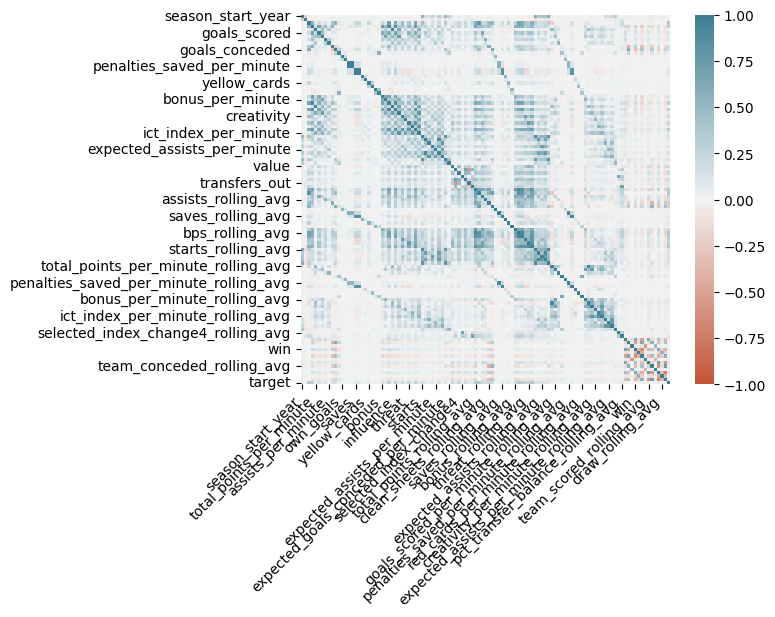

In [14]:
corr = df[numerical_cols + [target]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [15]:
corr.sort_values(target, ascending=False)[target].head(20)

target                      1.000000
minutes                     0.362713
minutes_rolling_avg         0.355461
ict_index_rolling_avg       0.353207
total_points_rolling_avg    0.343172
bps_rolling_avg             0.342417
influence_rolling_avg       0.332946
ict_index                   0.315569
bps                         0.296295
influence                   0.277779
total_points                0.275074
threat_rolling_avg          0.274642
creativity_rolling_avg      0.263048
threat                      0.239977
creativity                  0.236035
clean_sheets_rolling_avg    0.234592
selected                    0.231874
bonus_rolling_avg           0.211973
value                       0.211440
goals_scored_rolling_avg    0.203359
Name: target, dtype: float64

# Histogram of target

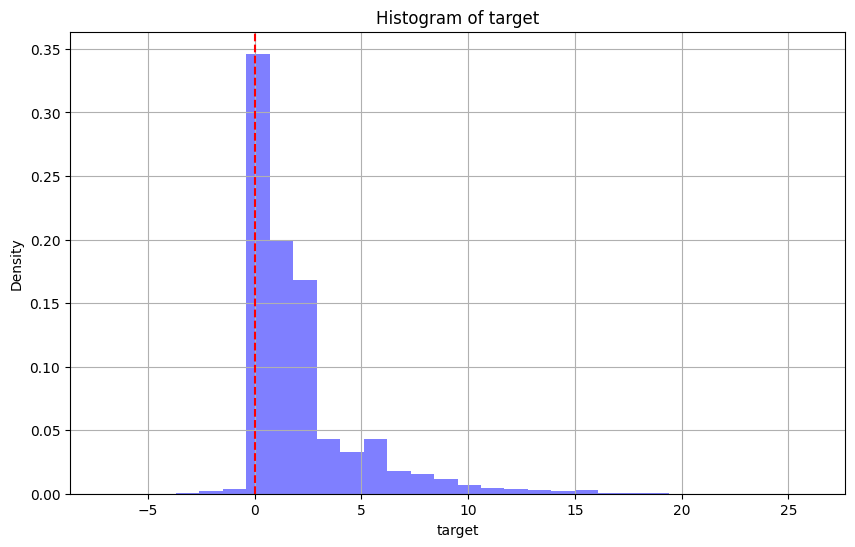

In [16]:
# Create a figure
plt.figure(figsize=(10, 6))

# Plot histogram for training residuals
plt.hist(df[target], bins=30, color='blue', alpha=0.5, label='Training Residuals', density=True)

# Add labels and title
plt.xlabel(target)
plt.ylabel("Density")
plt.title("Histogram of target")
plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')  # Line at zero
plt.grid()

plt.show()

In [17]:
#pd.options.display.max_rows = None
pd.options.display.max_columns = None

df.loc[df.target == 0][['round', 'minutes', 'minutes_rolling_avg', 'value', 'selected', 'total_points', 'total_points_rolling_avg']]

round  minutes  minutes_rolling_avg  value  selected  total_points  \
1        2.0      1.0             0.500000   45.0   43880.0           1.0   
2        3.0      0.0             0.333333   44.0   39627.0           0.0   
3        4.0      0.0             0.250000   44.0   36450.0           0.0   
5        6.0     26.0             6.500000   44.0   32307.0           1.0   
6        7.0      0.0             6.500000   43.0   31426.0           0.0   
...      ...      ...                  ...    ...       ...           ...   
74492   12.0      0.0             2.250000   45.0    6732.0           0.0   
74493   13.0      0.0             2.250000   45.0    6960.0           0.0   
74494    3.0      0.0             0.000000   50.0   10933.0           0.0   
74495    4.0      0.0             0.000000   50.0   13154.0           0.0   
74496    5.0      0.0             0.000000   50.0   14055.0           0.0   

       total_points_rolling_avg  
1                      0.500000  
2                      0.333333  
3                      0.250000  
5                      0.250000  
6                      0.250000  
...                         ...  
74492                  0.250000  
74493                  0.250000  
74494                  0.000000  
74495                  0.000000  
74496                  0.000000  

[28371 rows x 7 columns]

In [18]:
df.shape[0]

74498

In [19]:
df.loc[(df.minutes_rolling_avg > 0.0) | ((df.value >= 45)) | (df.total_points_rolling_avg != 0)].shape[0]


74498

In [20]:
df.loc[(df.minutes_rolling_avg > 0.0) | ((df.value >= 45) & (df.selected >= 100000)) | (df.total_points_rolling_avg != 0)].shape[0]


68102

In [21]:
df.loc[(df.minutes_rolling_avg > 0.0) | ((df.value >= 45) & (df.selected >= 10000)) | (df.total_points_rolling_avg != 0)].shape[0]

74498

In [22]:
df.loc[df.target == 0].shape[0] / df.shape[0] 

0.38082901554404147

In [23]:
df.loc[df.target == 0].shape[0]

28371

In [24]:
df.loc[(df.target == 0) & (df.selected <= 100000)].shape[0] 

20587

In [25]:
df.loc[(df.target != 0) & (df.selected <= 50000)].shape[0] 

17742

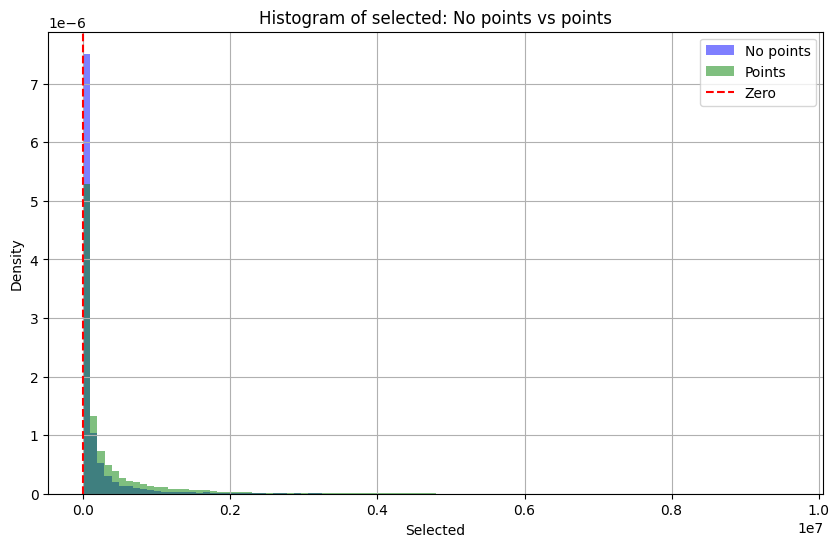

In [26]:

# Create a figure
plt.figure(figsize=(10, 6))

# Plot histogram for training residuals
plt.hist(df.loc[df.target == 0]['selected'], bins=100, color='blue', alpha=0.5, label='No points', density=True)

# Plot histogram for validation residuals
plt.hist(df.loc[df.target != 0]['selected'], bins=100, color='green', alpha=0.5, label='Points', density=True)

# Add labels and title
plt.xlabel("Selected")
plt.ylabel("Density")
plt.title("Histogram of selected: No points vs points")
plt.axvline(0, color='red', linestyle='--', label='Zero')  # Line at zero
plt.legend()
plt.grid()

plt.show()

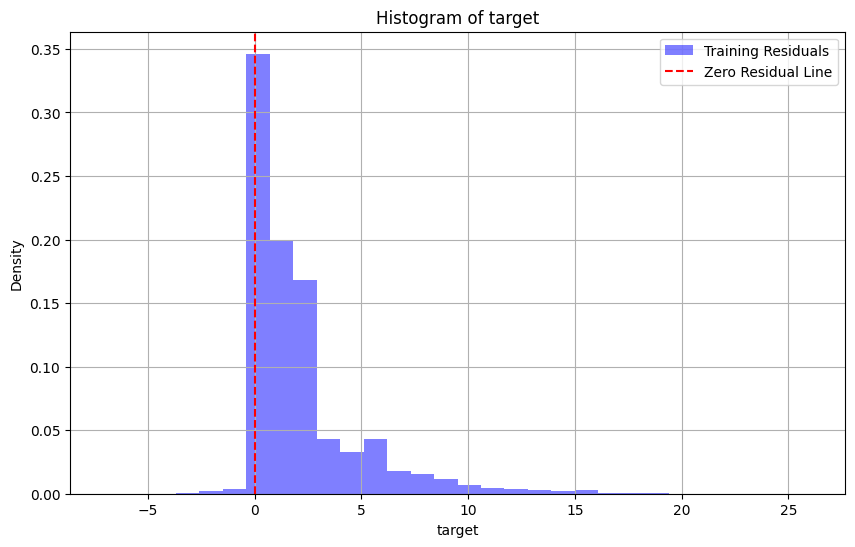

In [27]:
# Create a figure
plt.figure(figsize=(10, 6))

# Plot histogram for training residuals
plt.hist(df[target], bins=30, color='blue', alpha=0.5, label='Training Residuals', density=True)

# Add labels and title
plt.xlabel(target)
plt.ylabel("Density")
plt.title("Histogram of target")
plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')  # Line at zero
plt.legend()
plt.grid()

plt.show()

# Test and plot significant features

In [28]:
from src.ml.preprocess.feature_selection import test_significant

# Combine both numerical and categorical features
features = numerical_cols + categorical_cols

p_values = pd.DataFrame()  # To store p-values for all features
for p in features:
    # Test significance of each feature and store the result
    p_value = test_significant(df, p, target)
    p_values = pd.concat([p_values, p_value]).reset_index(drop=True)

p_values = p_values.sort_values("PR(>F)").reset_index(drop=True)


In [29]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def plot_feature_against_target(df, feature, target):
    
    if is_string_dtype(df[feature]) or (is_numeric_dtype(df[feature]) and len(df[feature].unique()) <= 13):
        dfg = df.groupby(feature).agg(
            mean = (target, np.mean),
            n = (target, np.size))
        #ax = dfg.plot.bar(figsize=(15, 7.5), ylabel='Average target', title = feature)
        dfg.plot(figsize=(15, 7.5), kind='bar', secondary_y= 'n', rot= 0, title = feature)
        print(dfg.sort_values('mean'))
        
    elif is_numeric_dtype(df[feature]):
        
        # Create bins based on percentiles to discretize the numeric feature
        bins = np.nanpercentile(df[feature], [0, 20, 40, 60, 80, 100])
        middle = bins[3]
        bins = [i for n, i in enumerate(bins) if i not in bins[:n]]  # Remove duplicates
        if len(bins) == 2 and bins[0] == middle:
            bins = [bins[0], bins[0]+0.1, bins[1]]
        elif len(bins) == 2 and bins[-1] == middle:
            bins = [bins[0], bins[1]-0.1, bins[1]]

        bins[0] = bins[0]-0.1
        bins[-1] = bins[-1]+0.1
        
        df_temp = pd.DataFrame({feature: df[feature], target: df[target]})
        df_temp[feature+'_bins'] = pd.cut(pd.to_numeric(df[feature]), bins, include_lowest=True)
        
        dfg = df_temp.groupby(feature+'_bins').agg(
            mean = (target, np.mean),
            n = (target, np.size))
        #ax = dfg.plot.bar(figsize=(15, 7.5), ylabel='Average target', title = feature)
        dfg.plot(figsize=(15, 7.5), kind='bar', secondary_y= 'n', rot= 0, title = feature)
        print(dfg)

        
    plt.show()

                              mean      n
clean_sheets_rolling_avg                 
0.000000                  1.375255  45044
0.250000                  2.532554  17801
0.333333                  2.665689    682
0.500000                  2.972858   8253
0.750000                  3.259341   1820
1.000000                  3.509987    751
0.666667                  4.088435    147


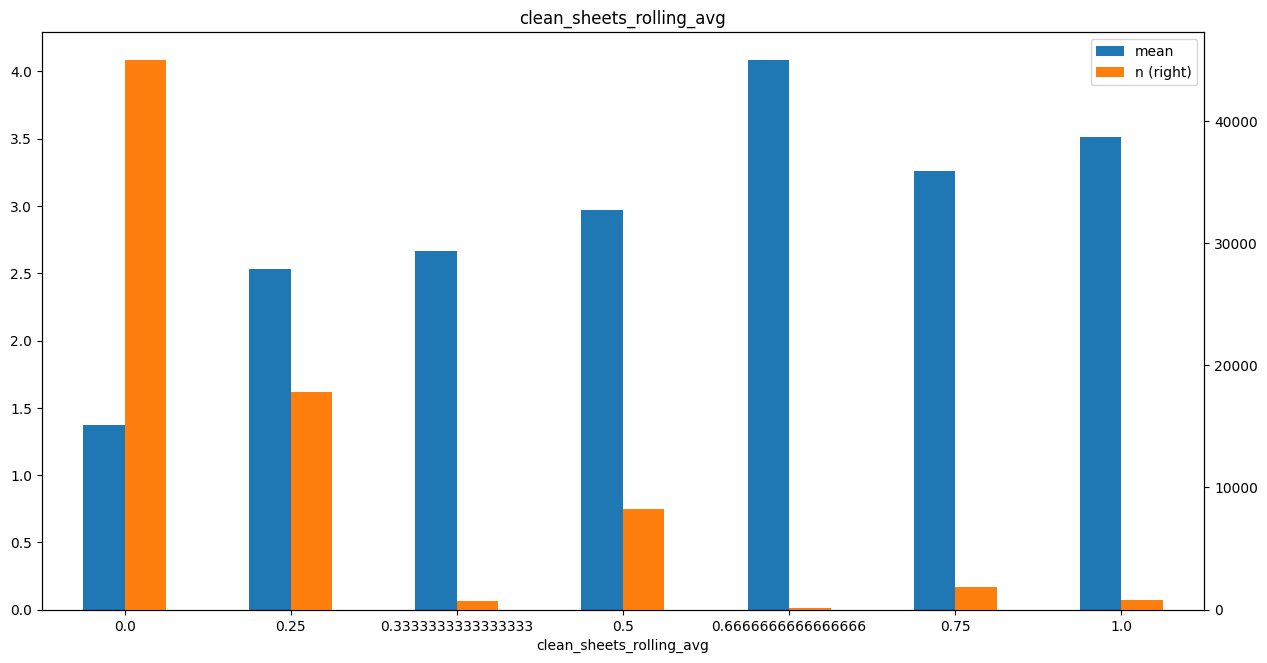

                               mean      n
influence_per_minute_bins                 
(-0.101, 0.0267]           0.864735  29823
(0.0267, 0.138]            2.524100  14896
(0.138, 0.251]             2.554398  14881
(0.251, 33.3]              2.762183  14898


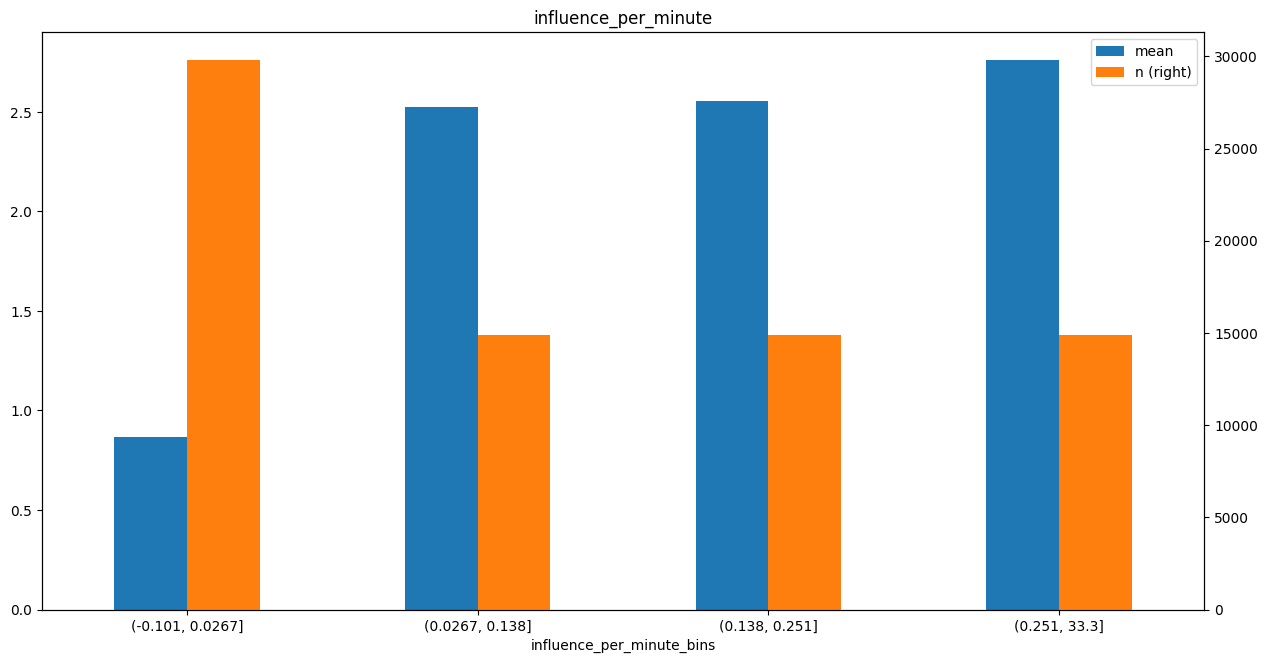

                                mean      n
creativity_per_minute_bins                 
(-0.101, 0.0367]            1.405032  44836
(0.0367, 0.184]             2.506874  14765
(0.184, 24.4]               2.855676  14897


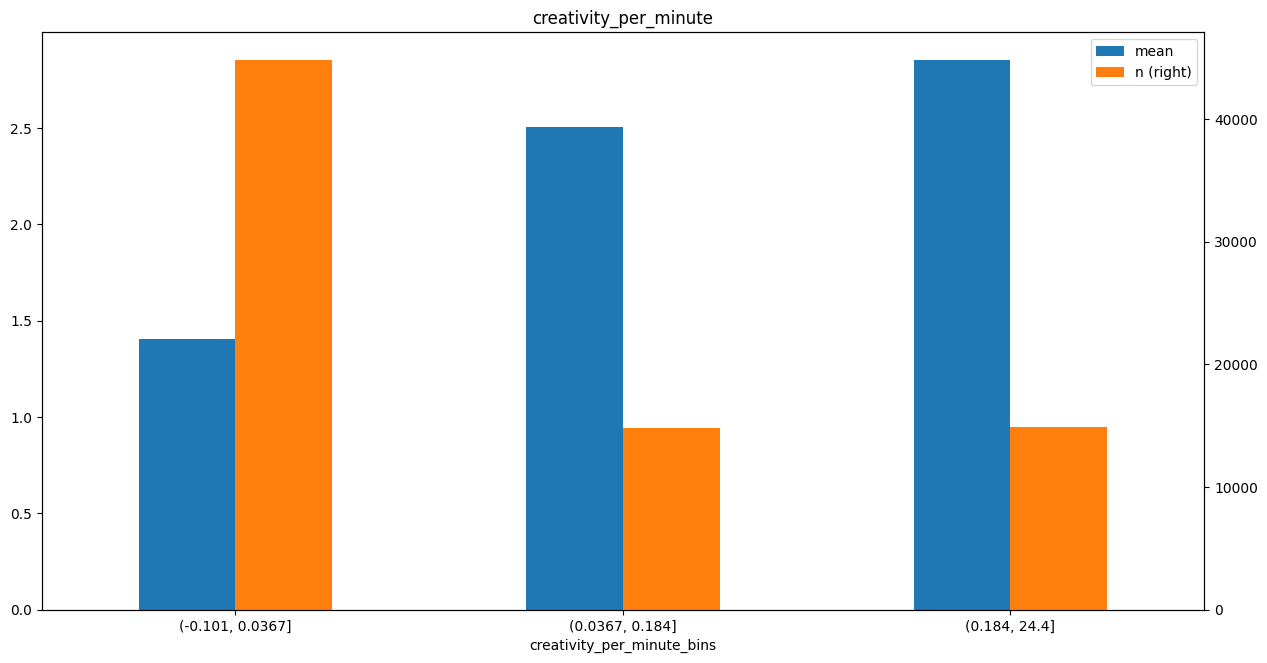

                   mean      n
threat_bins                   
(-0.101, 2.0]  1.395676  48426
(2.0, 12.0]    2.515792  11588
(12.0, 181.1]  3.162869  14484


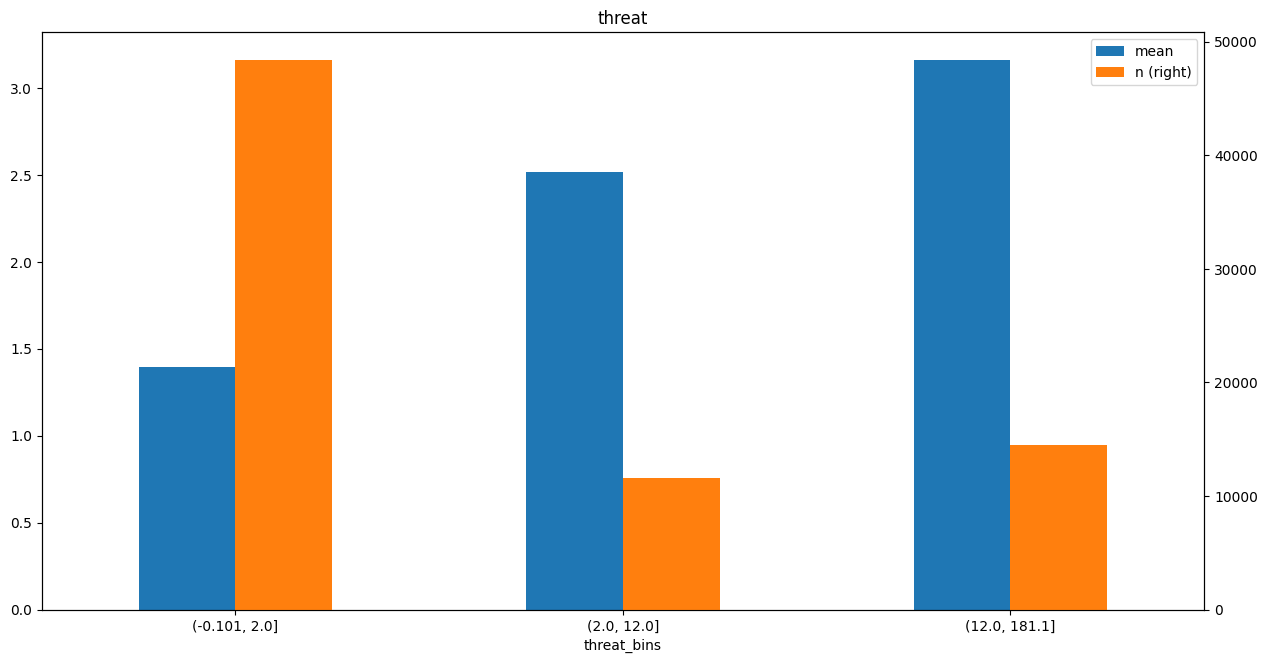

                            mean      n
threat_per_minute_bins                 
(-0.101, 0.0222]        1.374179  45700
(0.0222, 0.196]         2.556627  13898
(0.196, 37.1]           2.967718  14900


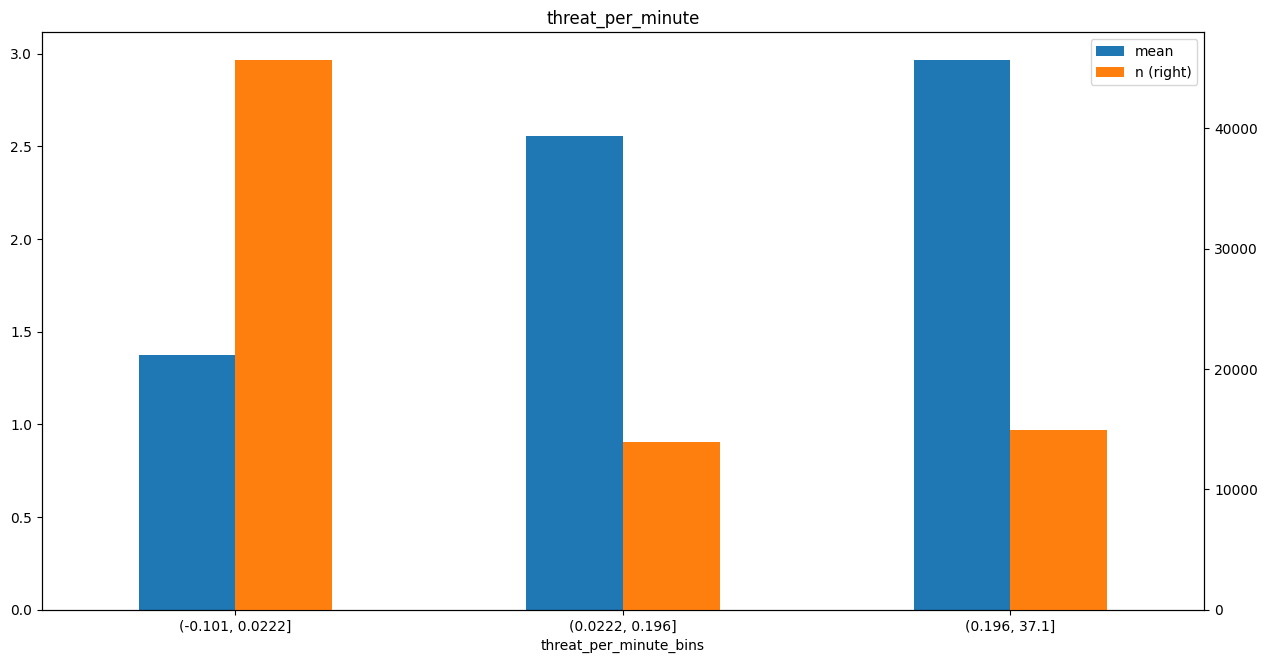

                    mean      n
ict_index_bins                 
(-0.101, 0.4]   0.771900  30114
(0.4, 2.2]      2.222085  15413
(2.2, 4.4]      2.592660  14224
(4.4, 35.9]     3.267037  14747


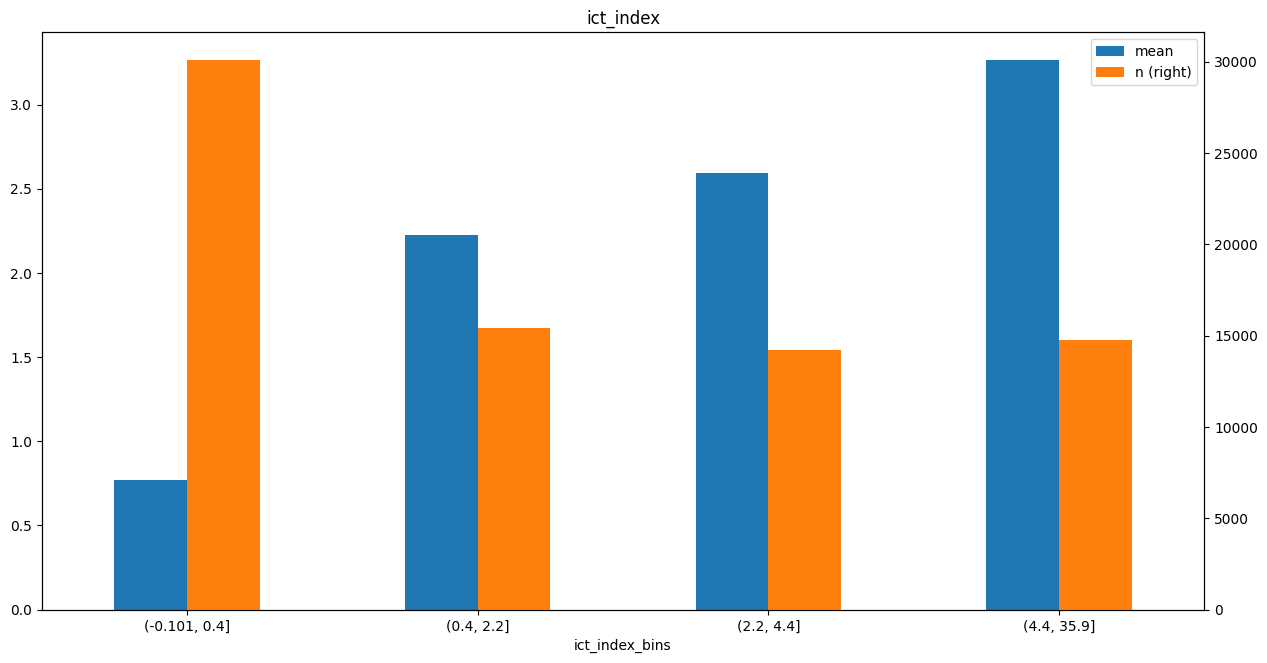

                               mean      n
ict_index_per_minute_bins                 
(-0.101, 0.0122]           0.872086  30075
(0.0122, 0.0312]           2.363525  14640
(0.0312, 0.0644]           2.597541  14963
(0.0644, 6.7]              2.891633  14820


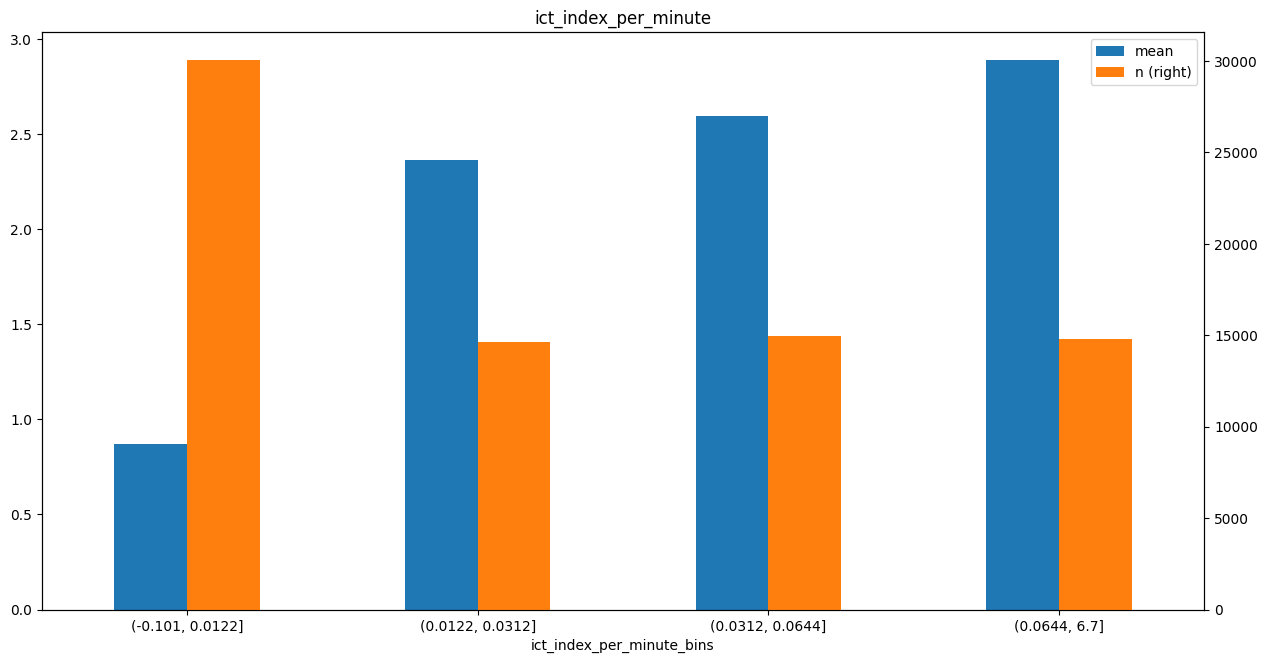

            mean      n
starts                 
0.0     1.697789  59978
1.0     2.804477  14520


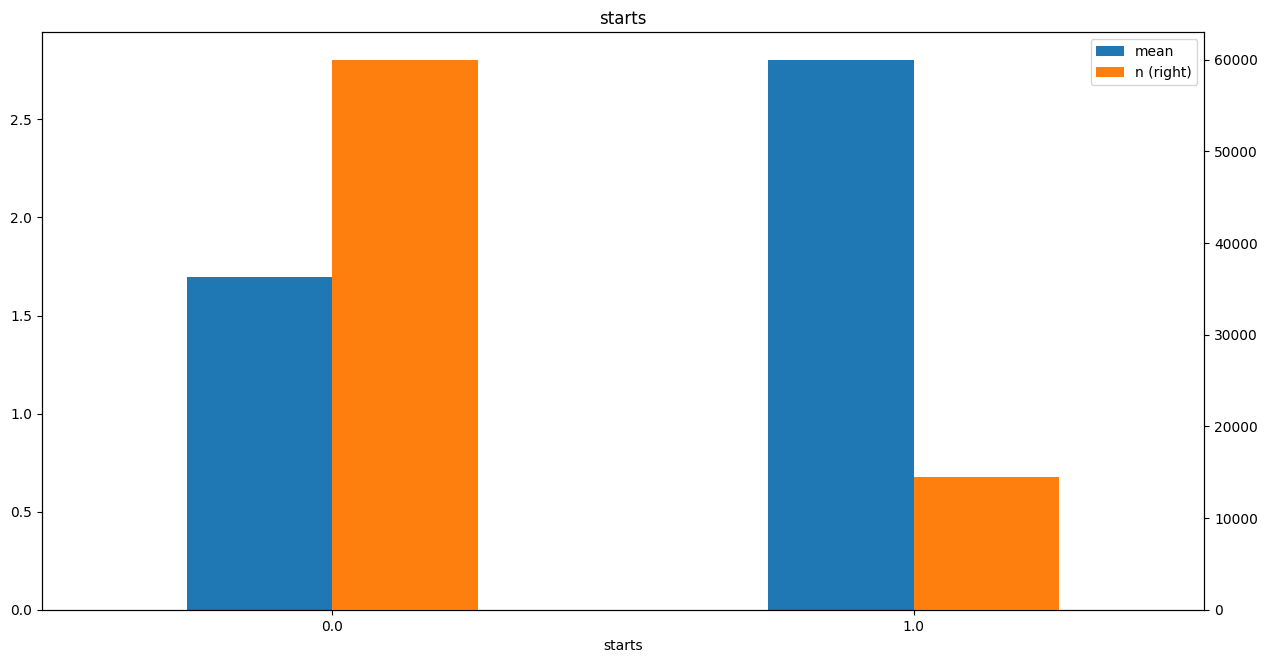

                        mean      n
starts_rolling_avg                 
0.250000            1.380207   3577
0.333333            1.670270    185
0.500000            1.729478   3216
0.000000            1.745613  54539
0.666667            1.813559    177
0.750000            2.327747   3640
1.000000            3.027608   9164


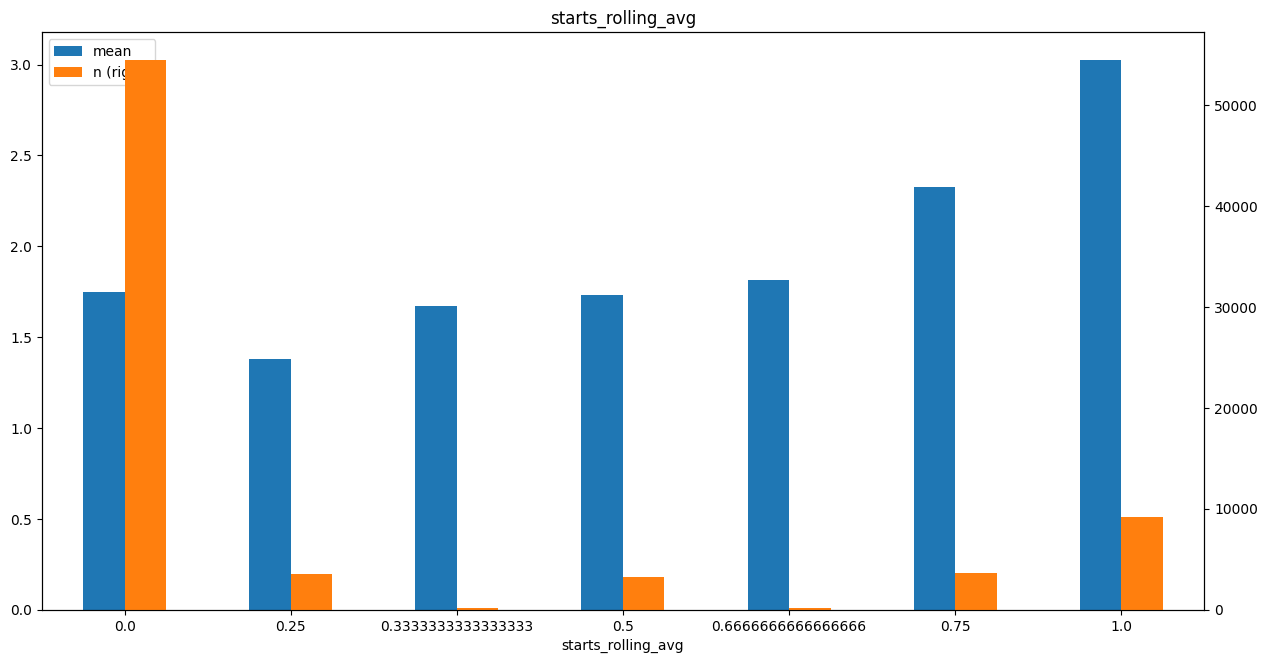

                                mean      n
ict_index_rolling_avg_bins                 
(-0.101, 0.225]             0.456388  15145
(0.225, 1.35]               1.259579  14928
(1.35, 2.5]                 2.058360  14719
(2.5, 4.125]                2.457422  14820
(4.125, 32.9]               3.366922  14886


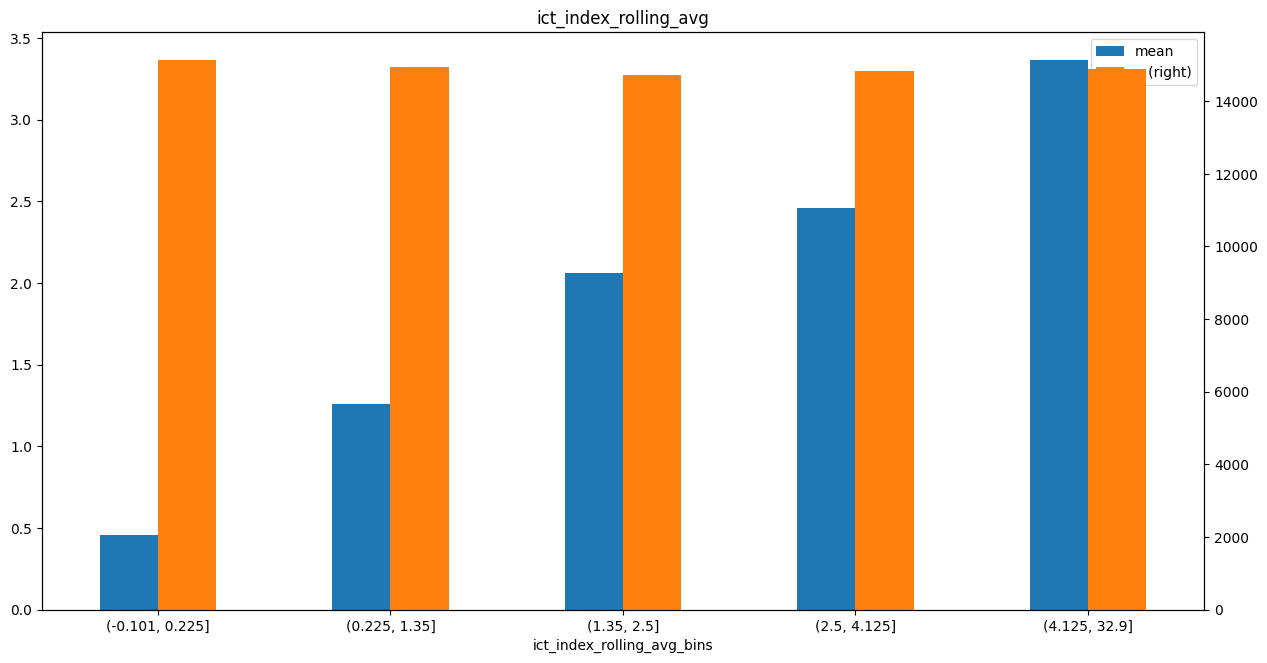

                             mean      n
threat_rolling_avg_bins                 
(-0.101, 1.0]            1.164153  29899
(1.0, 5.25]              1.789546  15286
(5.25, 13.0]             2.269959  14517
(13.0, 161.1]            3.206002  14796


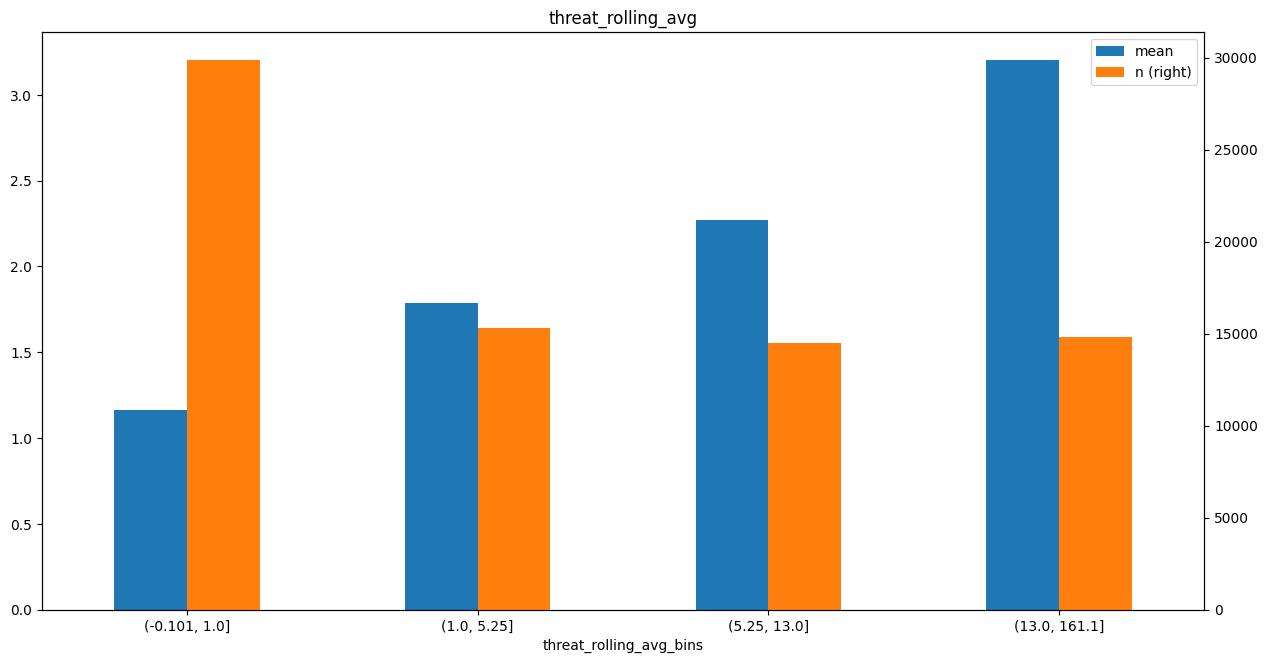

                    mean      n
value_bins                     
(36.899, 45.0]  1.385294  21664
(45.0, 48.0]    1.568596   8171
(48.0, 53.0]    1.809187  17394
(53.0, 59.0]    2.085770  12930
(59.0, 153.1]   2.879211  14339


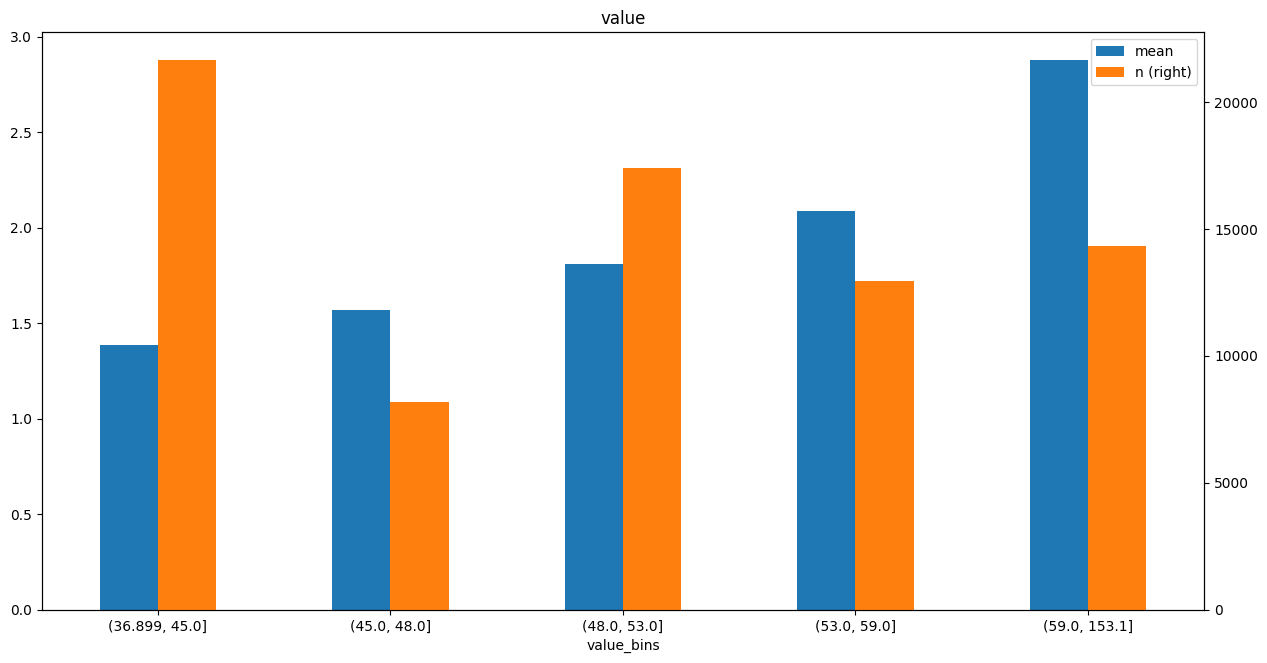

                    mean      n
influence_bins                 
(-0.101, 1.0]   0.832937  30282
(1.0, 9.0]      2.220381  14661
(9.0, 19.2]     2.672129  14829
(19.2, 163.5]   3.066006  14726


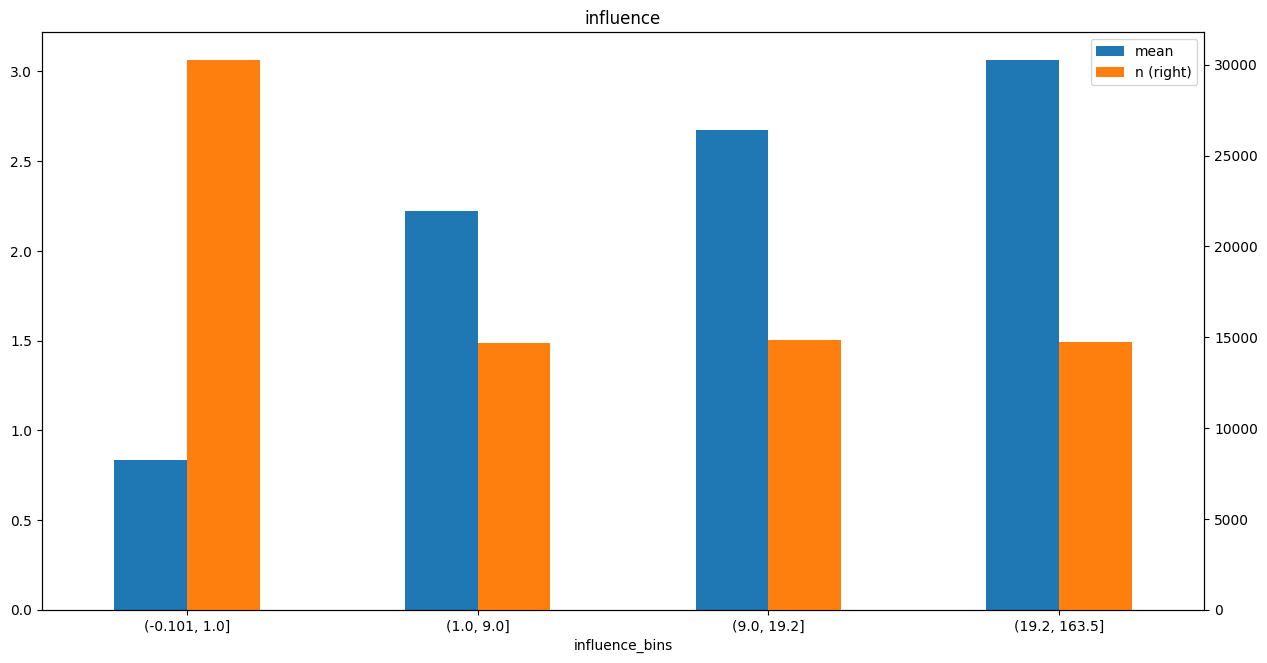

                                    mean      n
transfers_balance_bins                         
(-2693401.1010000003, -5634.0]  2.255084  14901
(-5634.0, -681.0]               1.495335  14899
(-681.0, -14.0]                 1.042560  14967
(-14.0, 2653.0]                 1.756489  14833
(2653.0, 1983733.1]             3.021278  14898


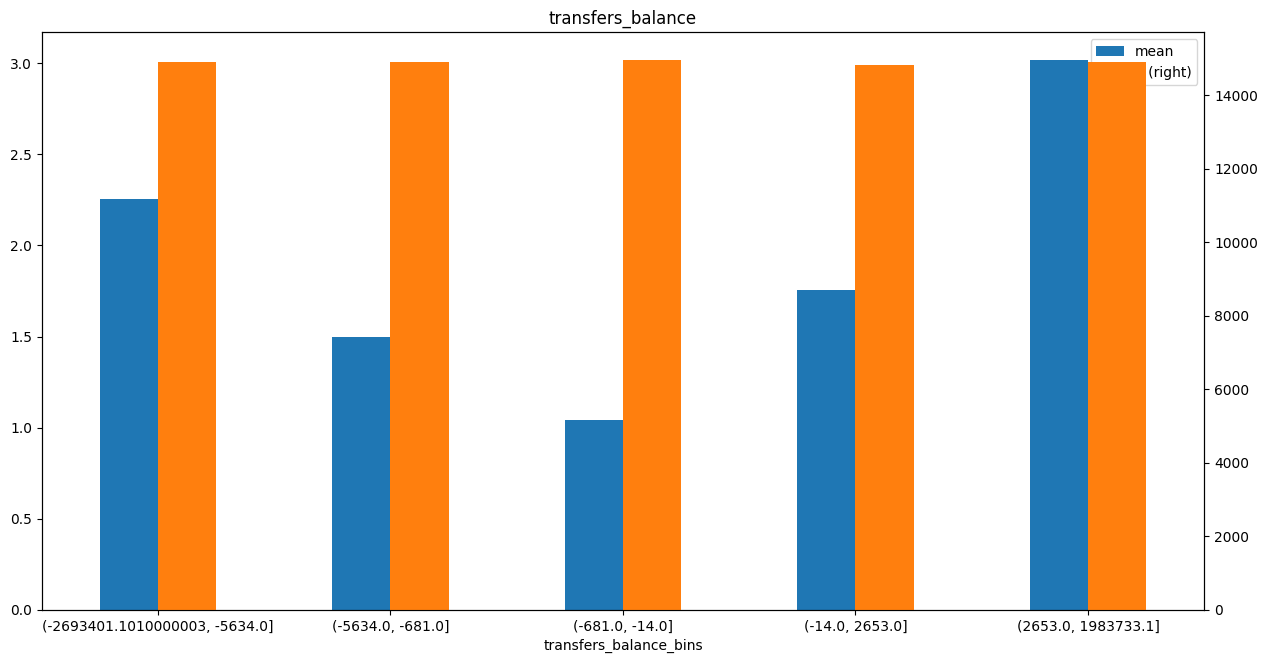

                          mean      n
transfers_in_bins                    
(-0.101, 143.0]       0.847905  14938
(143.0, 748.8]        1.237467  14861
(748.8, 3435.0]       1.817230  14904
(3435.0, 18411.6]     2.412890  14895
(18411.6, 2104464.1]  3.253087  14900


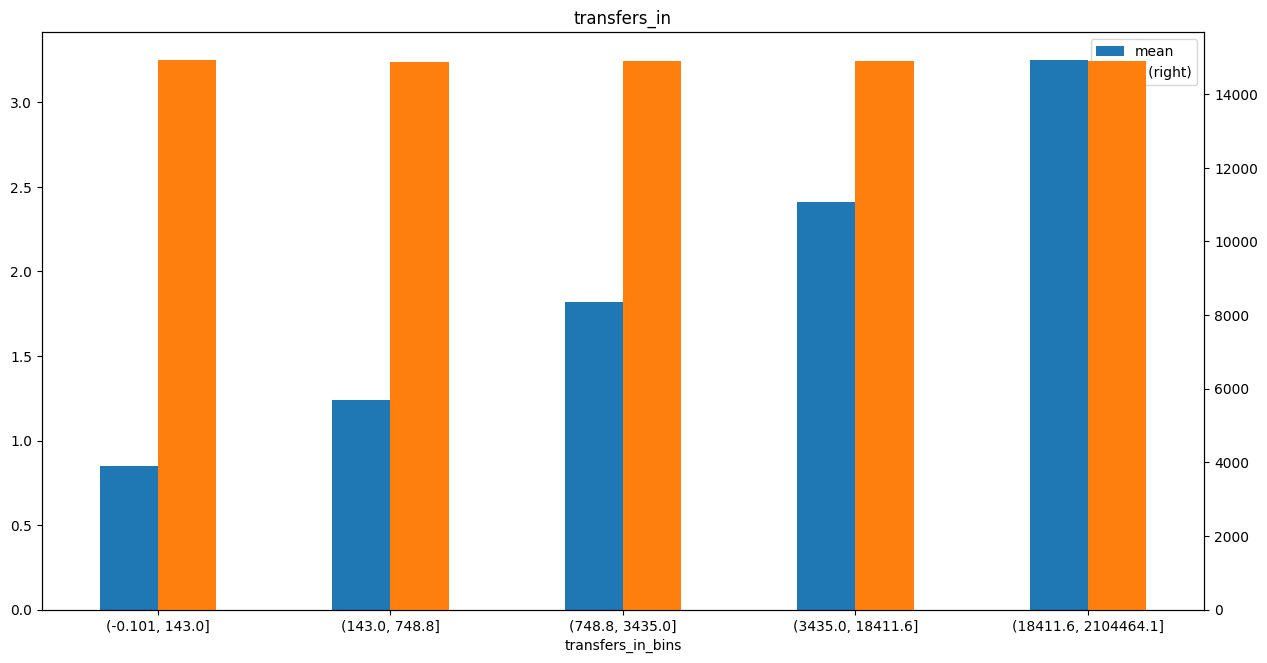

                          mean      n
transfers_out_bins                   
(-0.101, 404.0]       1.136495  14909
(404.0, 1708.0]       1.397945  14894
(1708.0, 5779.2]      1.788265  14896
(5779.2, 21301.2]     2.338412  14899
(21301.2, 2747279.1]  2.906577  14900


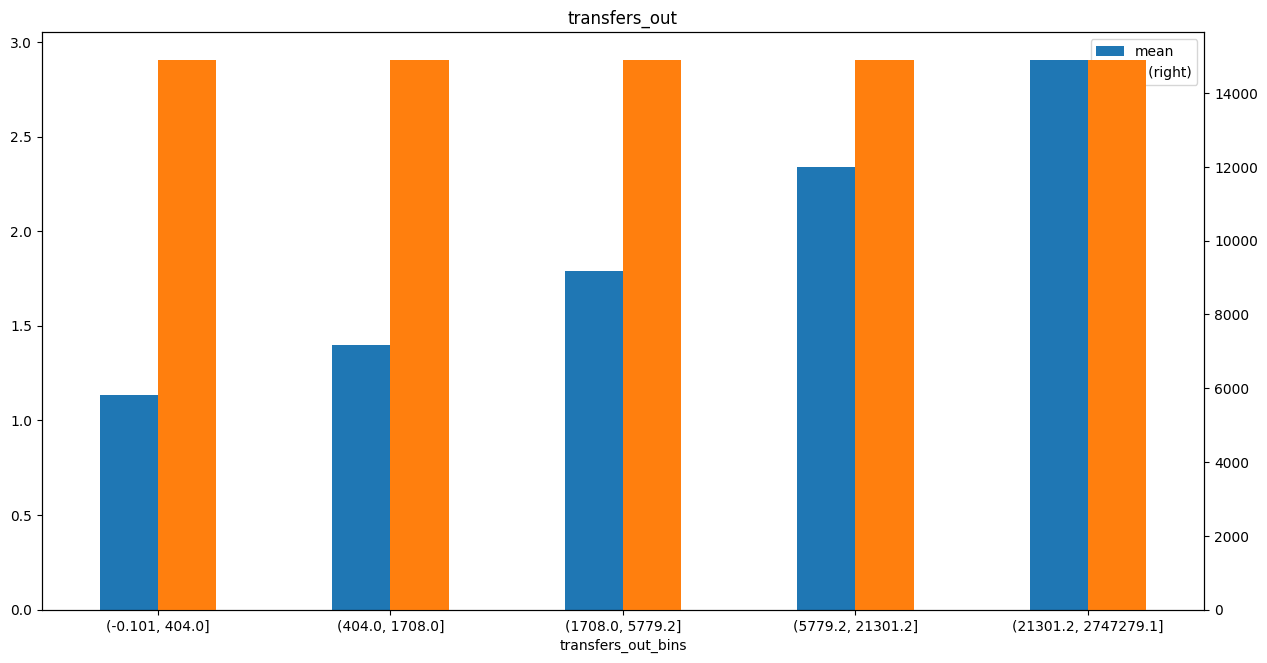

                                   mean      n
pct_transfer_balance_bins                     
(-2.4379999999999997, -0.066]  1.631141  14900
(-0.066, -0.0203]              1.697228  14899
(-0.0203, -0.00122]            1.431812  14900
(-0.00122, 0.0403]             2.162091  14899
(0.0403, 1.169]                2.645168  14900


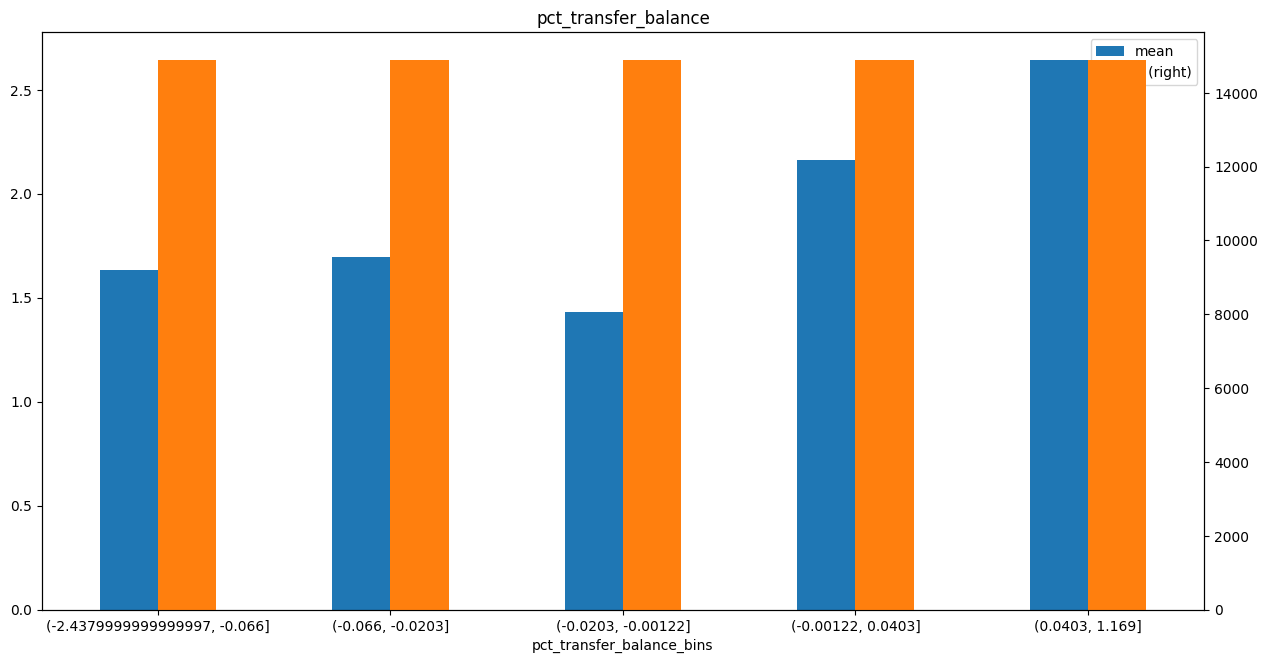

                                   mean      n
total_points_rolling_avg_bins                 
(-2.101, 0.25]                 0.519990  16483
(0.25, 1.0]                    1.299528  15481
(1.0, 2.0]                     2.107523  14862
(2.0, 3.5]                     2.620500  14527
(3.5, 20.1]                    3.383188  13145


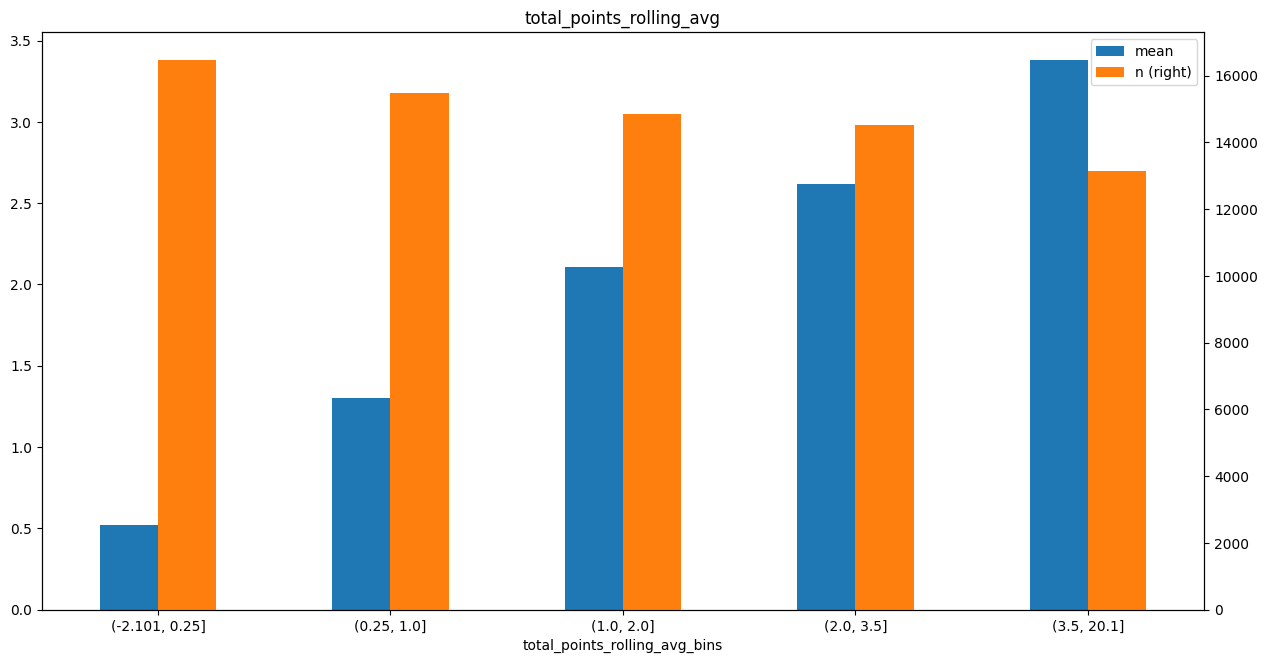

                              mean      n
minutes_rolling_avg_bins                 
(-0.101, 6.5]             0.452536  15064
(6.5, 32.75]              1.225294  14794
(32.75, 64.75]            2.007741  14856
(64.75, 88.5]             2.794910  14930
(88.5, 90.1]              3.100310  14854


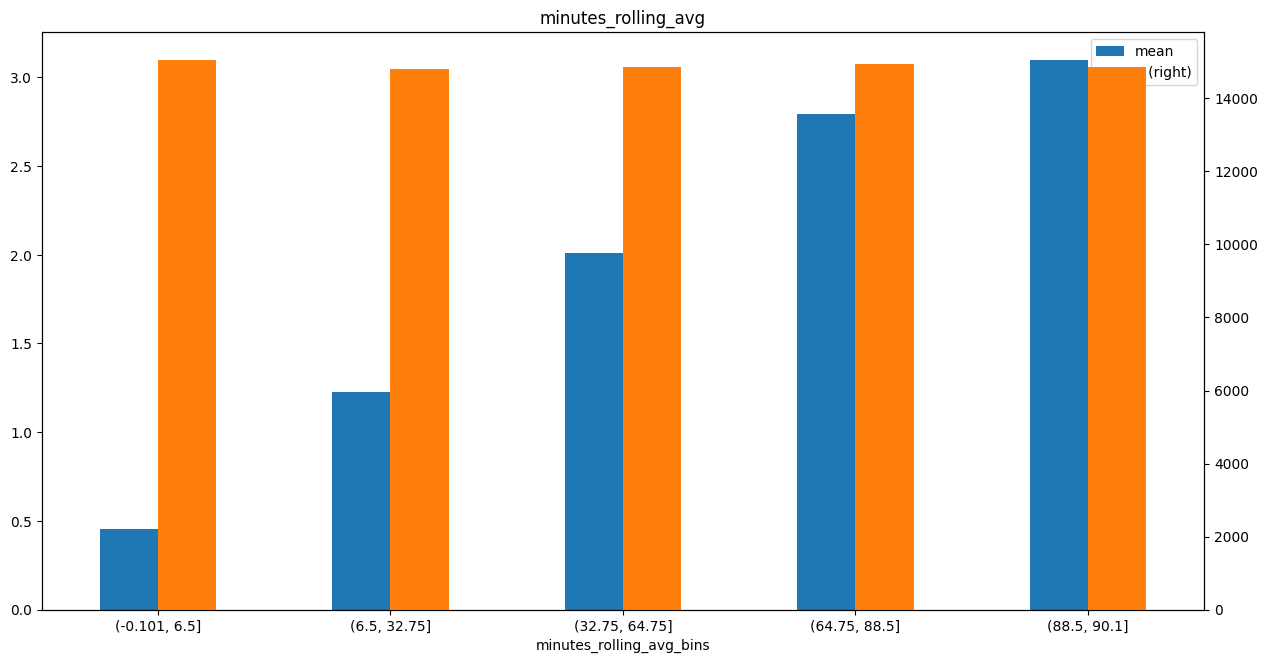

                                   mean      n
goals_scored_rolling_avg_bins                 
(-0.101, 0.1]                  1.667342  61685
(0.1, 3.1]                     3.098494  12813


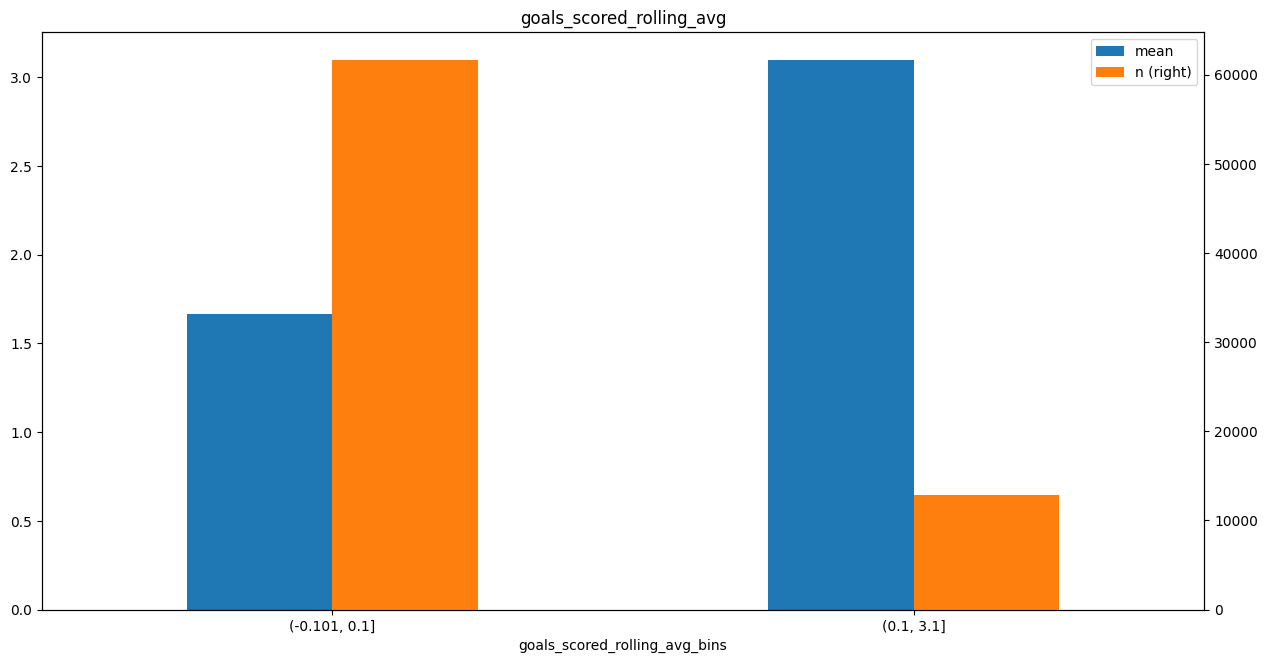

                              mean      n
assists_rolling_avg_bins                 
(-0.101, 0.1]             1.713575  61723
(0.1, 4.1]                2.879374  12775


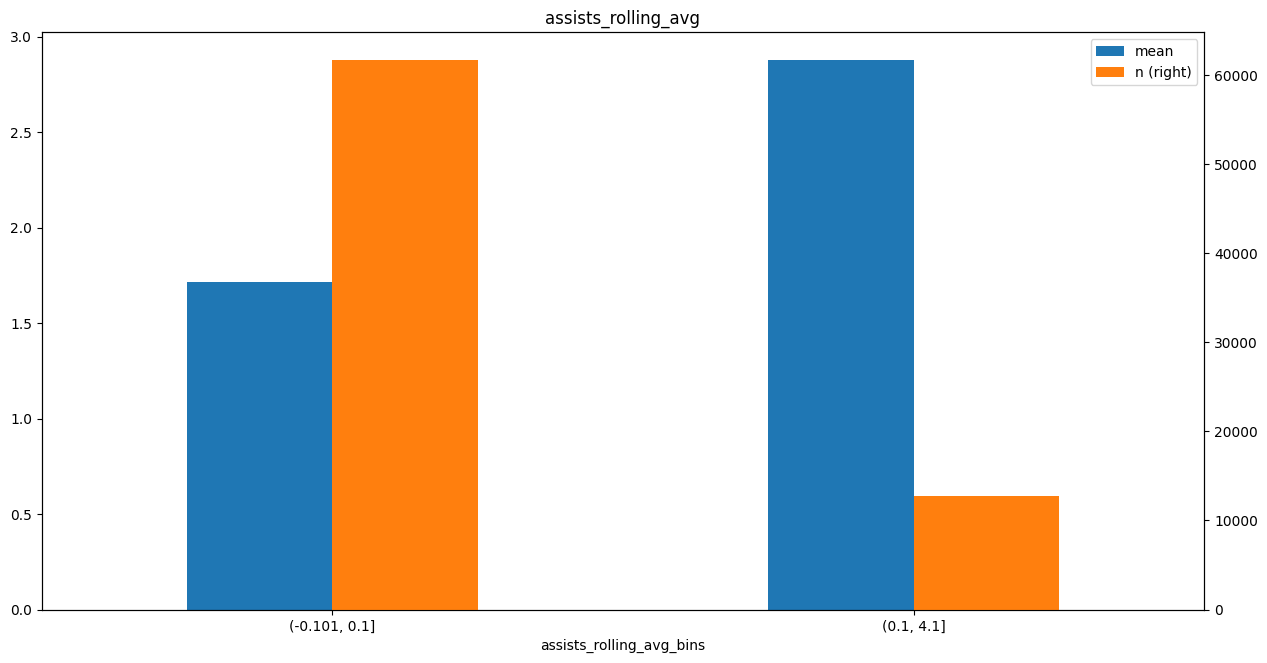

                                 mean      n
creativity_rolling_avg_bins                 
(-0.101, 0.0333]             1.021867  14908
(0.0333, 1.425]              1.295503  14900
(1.425, 5.6]                 1.858610  14895
(5.6, 12.475]                2.257753  14898
(12.475, 96.3]               3.134457  14897


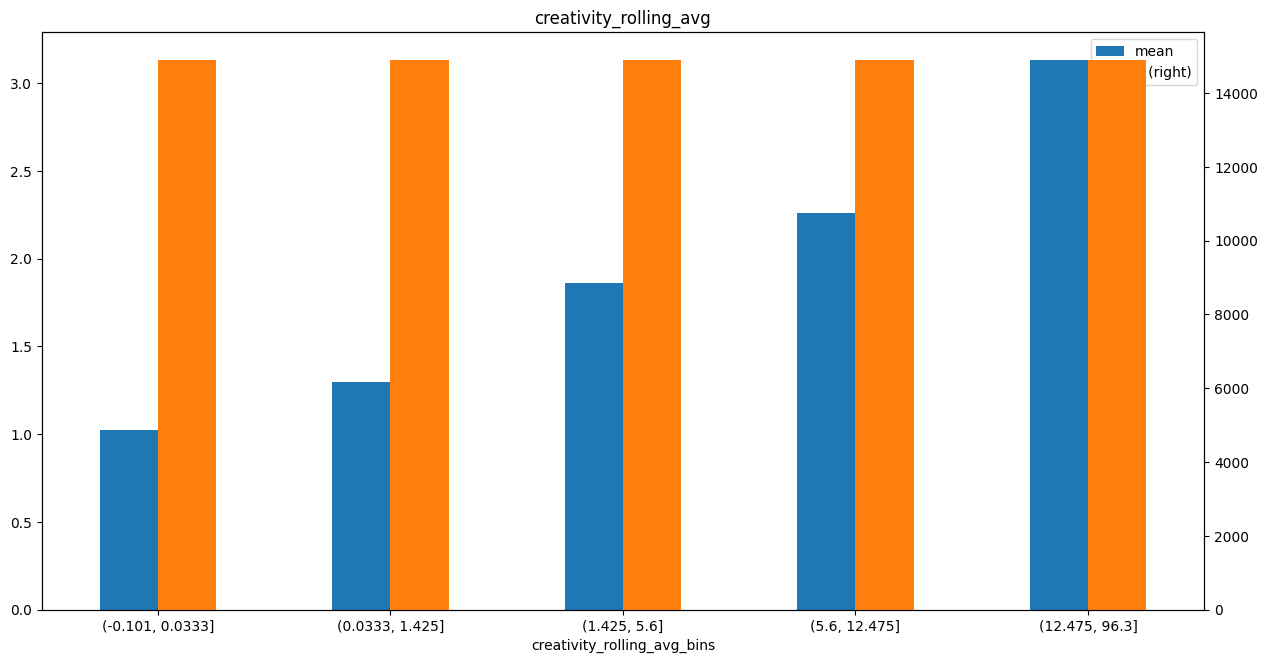

                                     mean      n
goals_conceded_rolling_avg_bins                 
(-0.101, 0.5]                    1.362545  38820
(0.5, 0.75]                      2.306138   8065
(0.75, 1.25]                     2.521704  13753
(1.25, 5.1]                      2.624603  13860


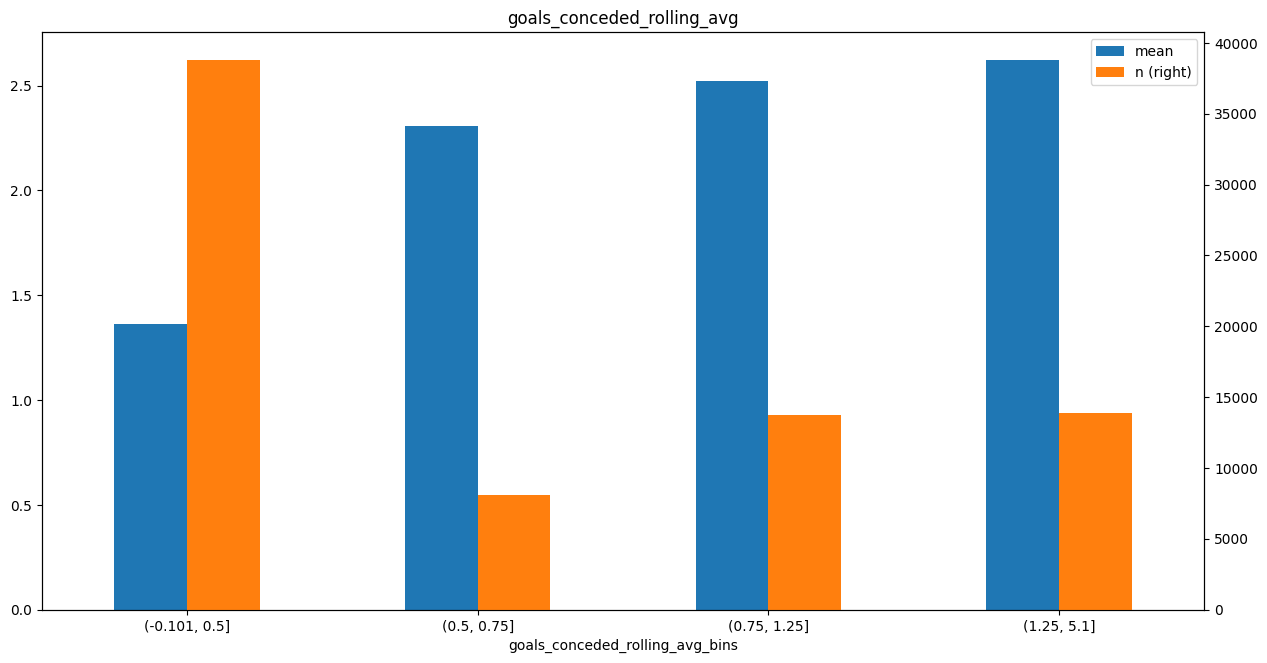

                                mean      n
influence_rolling_avg_bins                 
(-0.101, 0.7]               0.505263  14915
(0.7, 5.15]                 1.264478  14988
(5.15, 11.5]                1.999798  14855
(11.5, 18.55]               2.571390  14855
(18.55, 117.3]              3.235338  14885


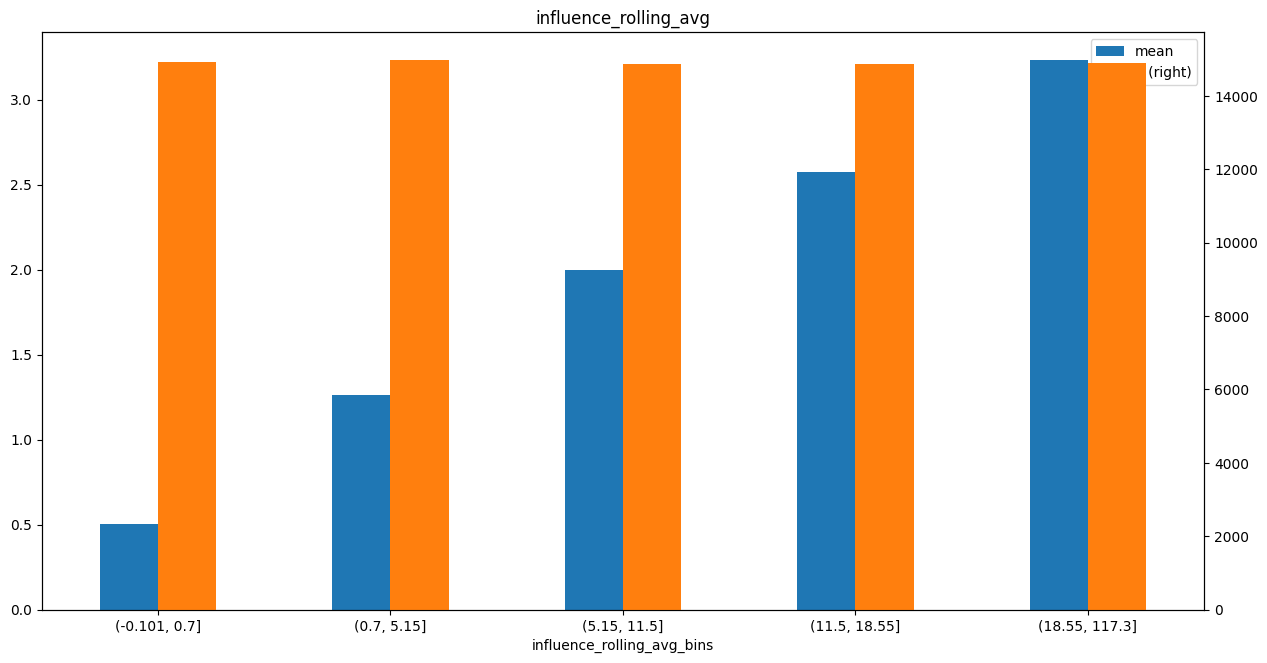

                                mean      n
bps_rolling_avg_bins                       
(-10.100999999999999, 1.0]  0.552615  15718
(1.0, 4.75]                 1.274233  14608
(4.75, 9.75]                1.989863  14502
(9.75, 15.5]                2.570049  15118
(15.5, 69.1]                3.266905  14552


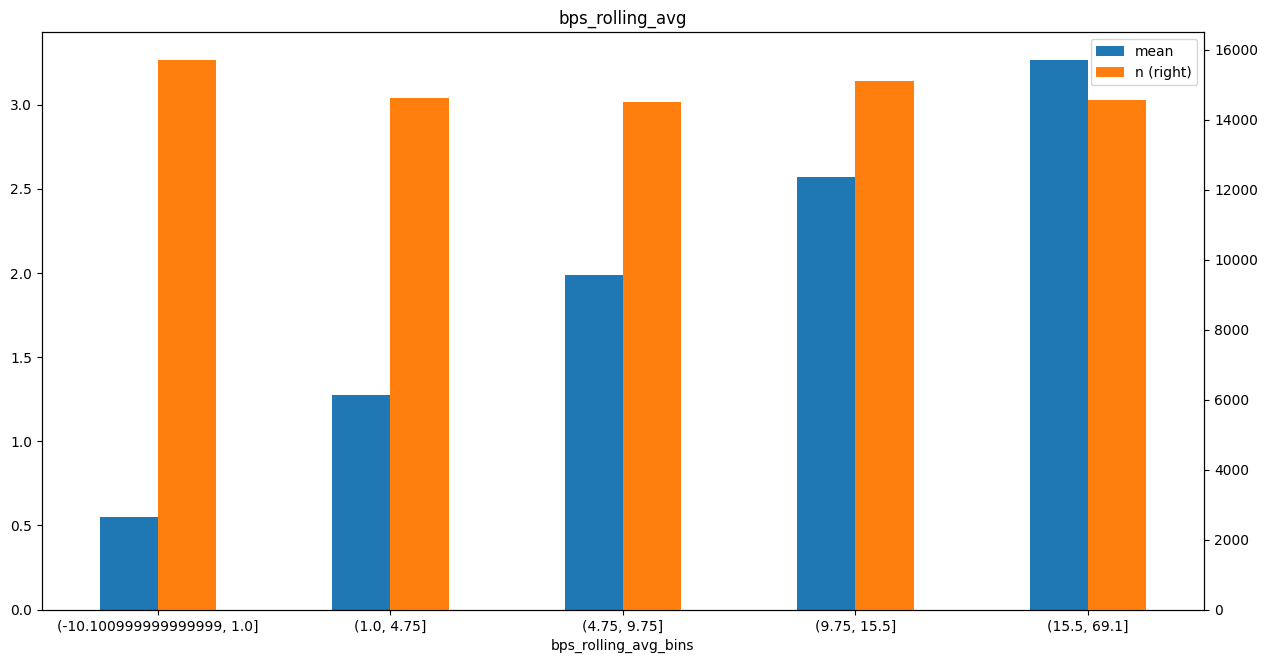

                           mean      n
selected_bins                         
(-0.101, 12316.0]      1.132541  14901
(12316.0, 35465.4]     1.285542  14898
(35465.4, 102603.2]    1.708121  14900
(102603.2, 364648.6]   2.258474  14899
(364648.6, 9582624.1]  3.182752  14900


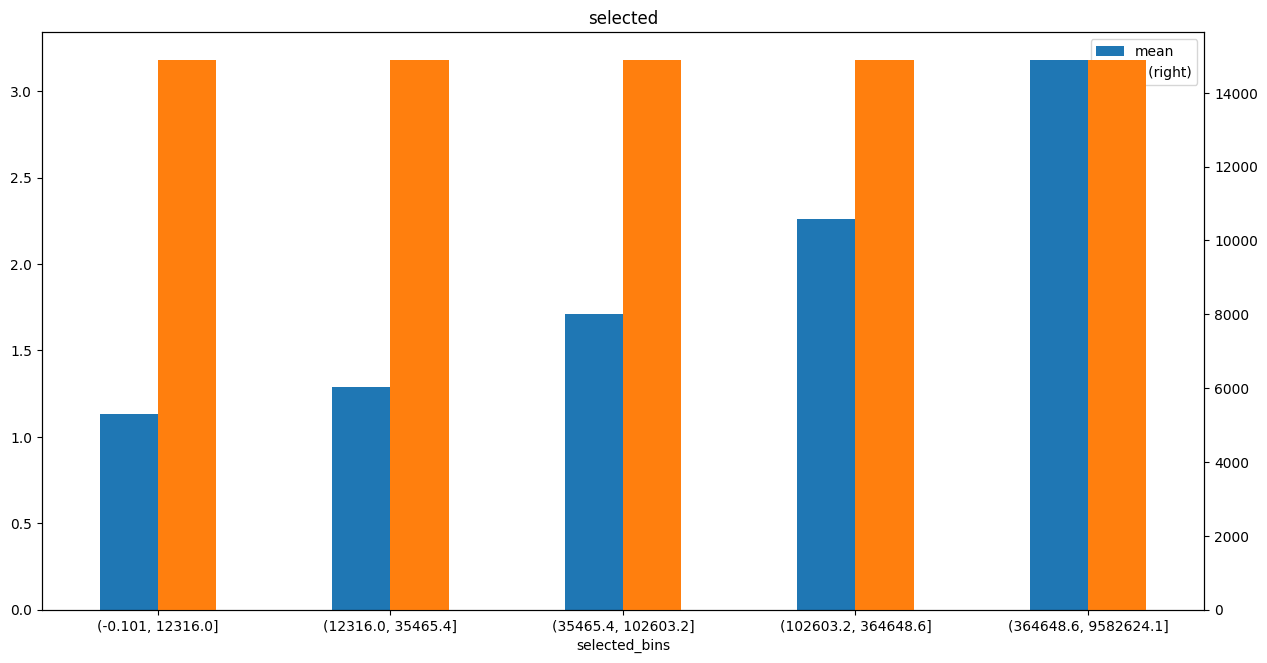

                         mean      n
bps_per_minute_bins                 
(-7.101, 0.0]        0.775707  26666
(0.0, 0.0519]        2.553964   3141
(0.0519, 0.138]      2.495544  14925
(0.138, 0.244]       2.609326  15097
(0.244, 30.1]        2.536301  14669


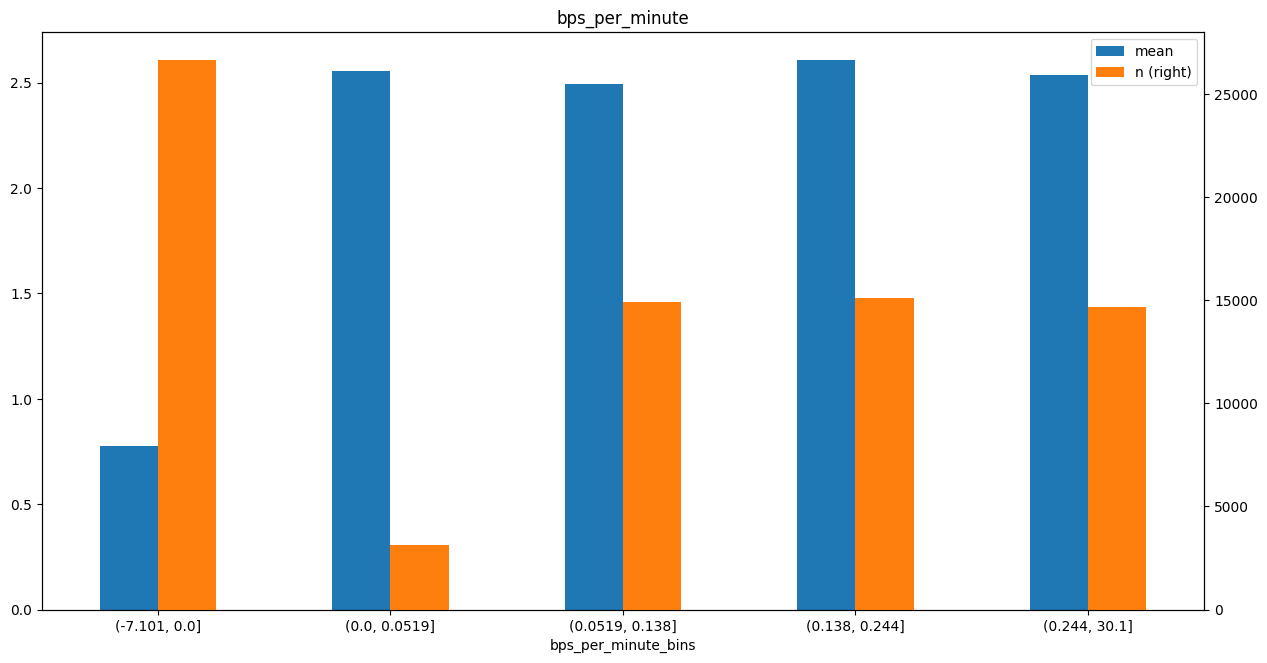

                     mean      n
creativity_bins                 
(-0.101, 1.8]    1.328056  45038
(1.8, 13.2]      2.537865  14578
(13.2, 136.3]    3.073579  14882


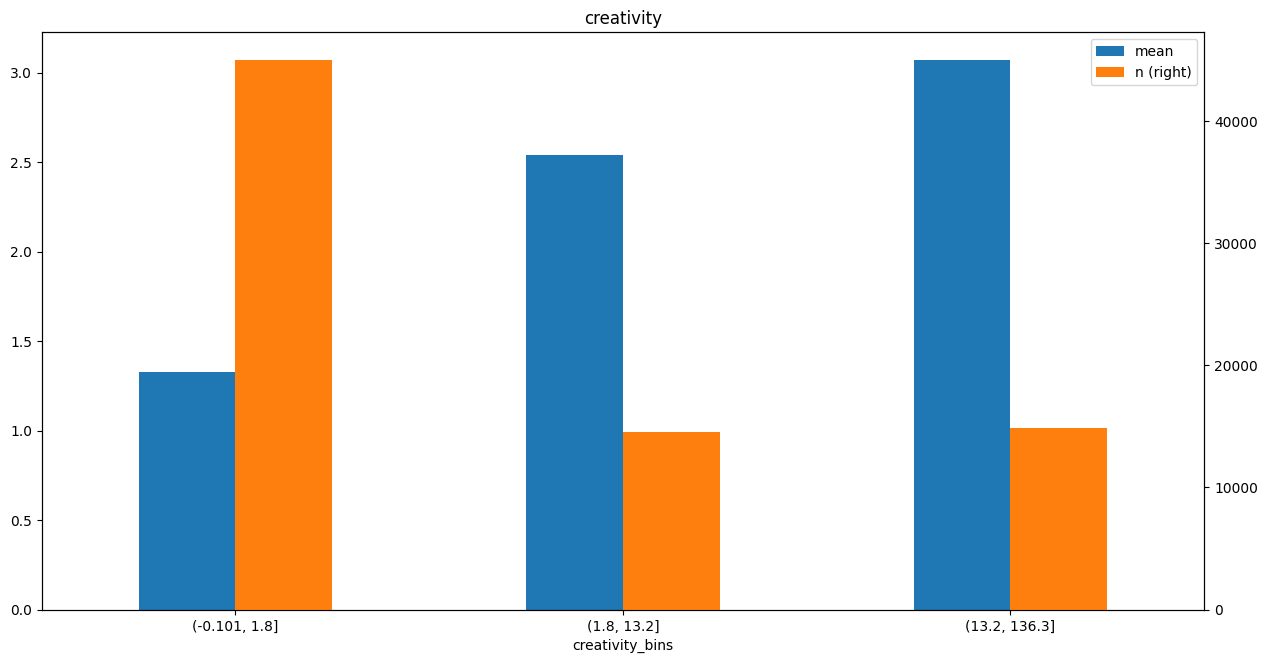

                            mean      n
bonus_rolling_avg_bins                 
(-0.101, 0.25]          1.656013  61543
(0.25, 3.1]             3.136627  12955


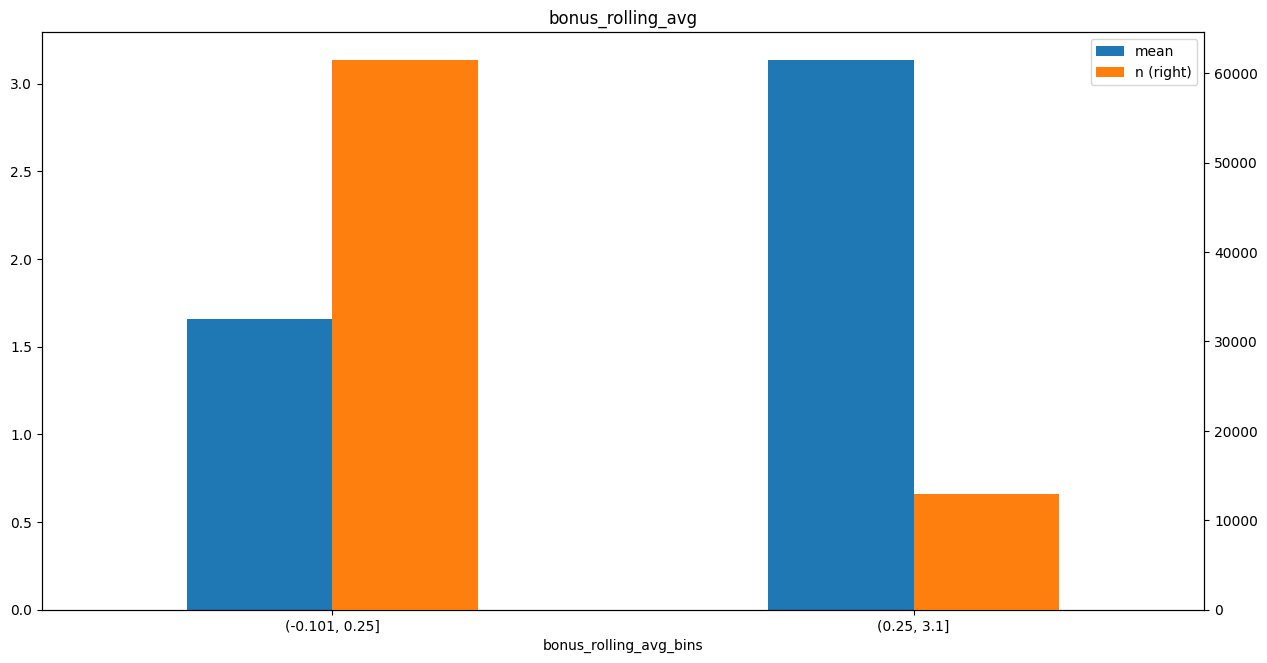

                    mean      n
minutes_bins                   
(-0.101, 16.0]  0.744064  29984
(16.0, 83.0]    2.178007  15005
(83.0, 90.1]    2.967230  29509


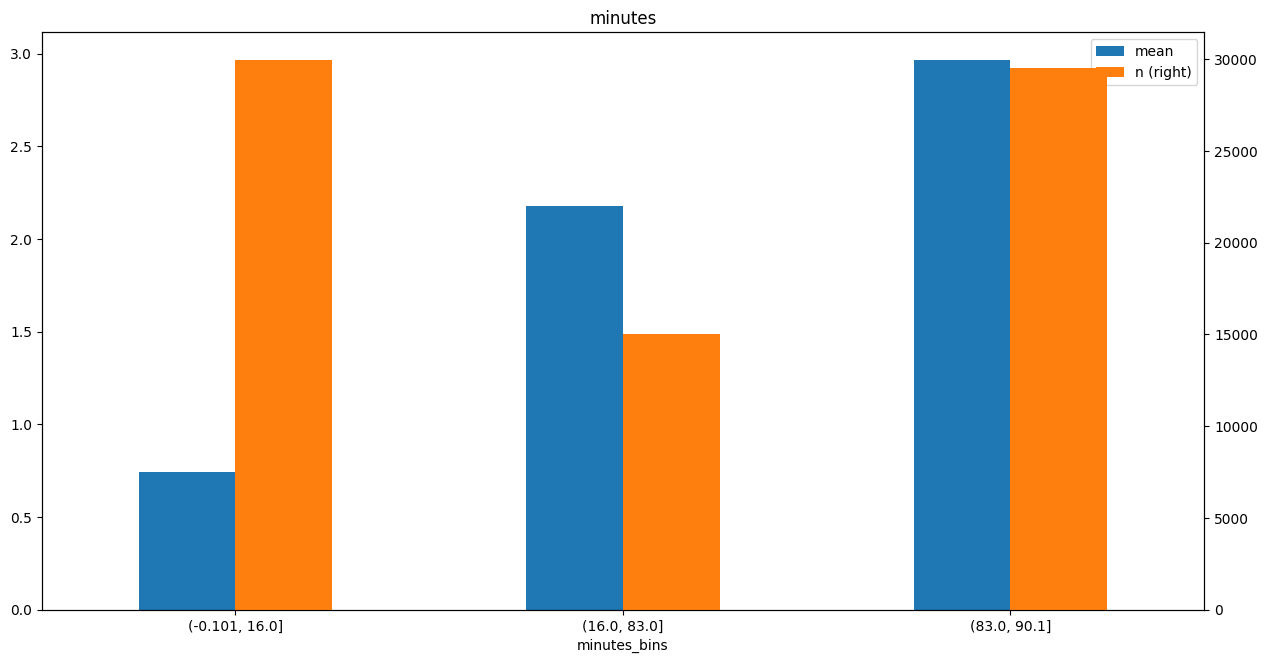

                  mean      n
clean_sheets                 
0.0           1.718111  63642
1.0           3.058861  10856


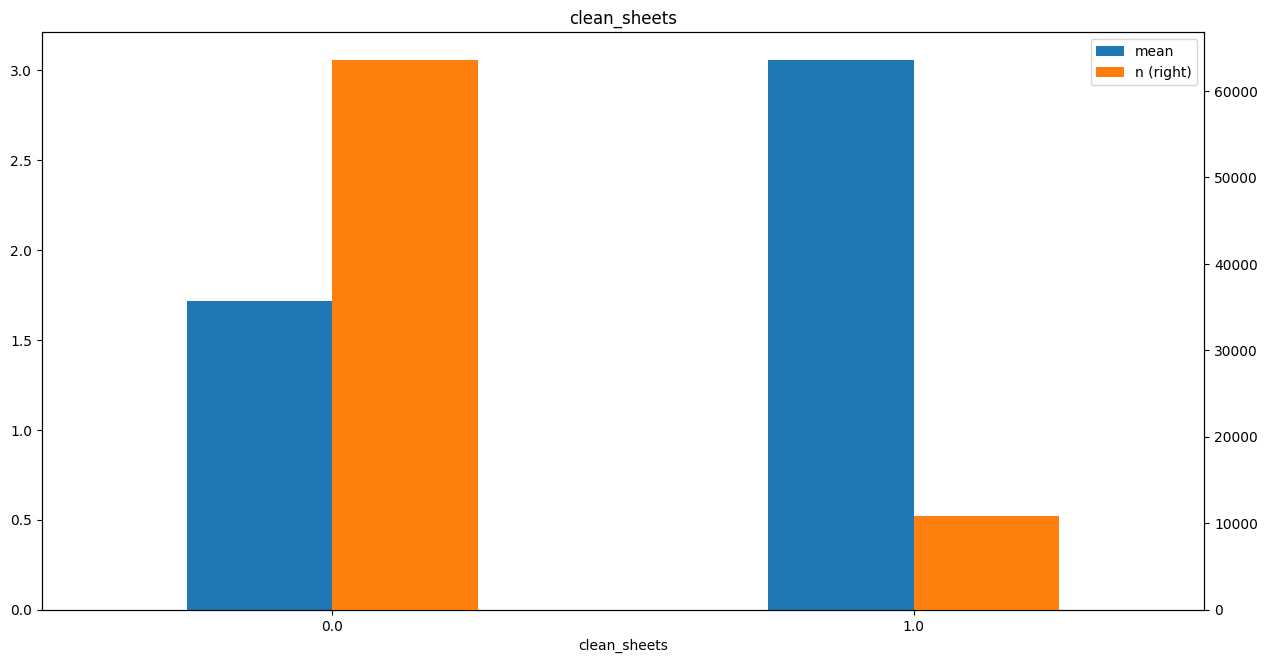

                                           mean      n
ict_index_per_minute_rolling_avg_bins                 
(-0.101, 0.0169]                       0.657987  14900
(0.0169, 0.0317]                       1.920098  15031
(0.0317, 0.0483]                       2.120883  14816
(0.0483, 0.079]                        2.349404  14851
(0.079, 5.1]                           2.521611  14900


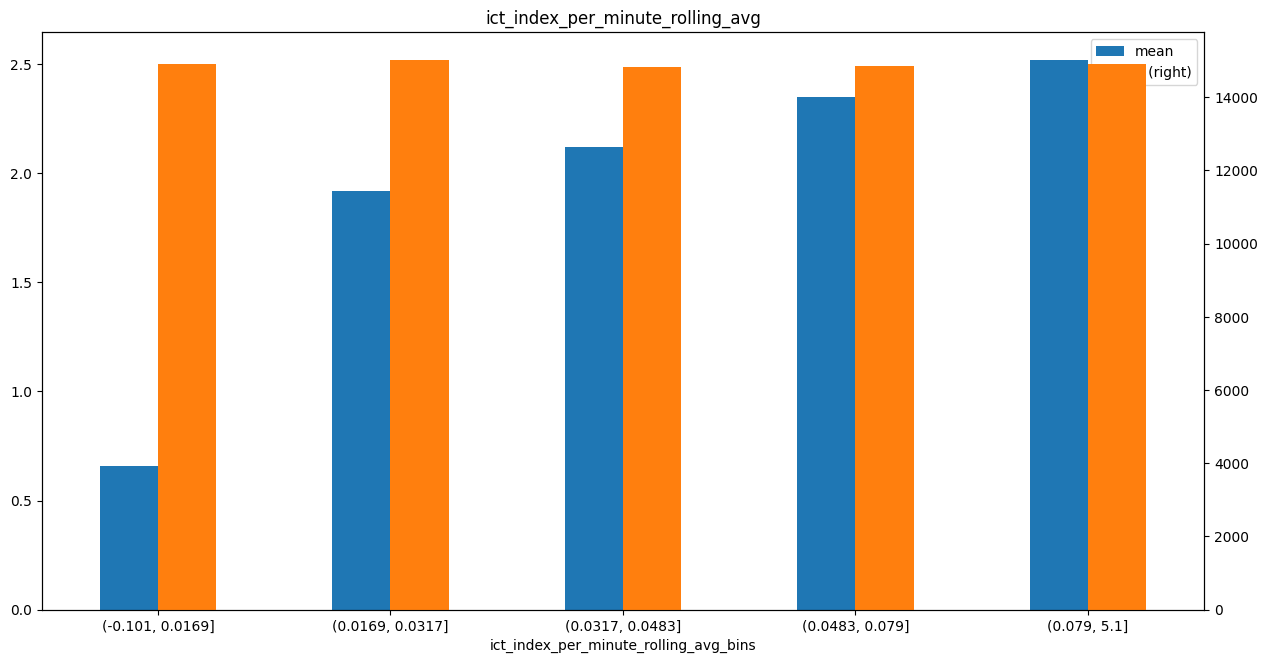

                                        mean      n
threat_per_minute_rolling_avg_bins                 
(-0.101, 0.0296]                    1.292806  29955
(0.0296, 0.111]                     2.031707  14823
(0.111, 0.278]                      2.372927  14834
(0.278, 35.1]                       2.586927  14886


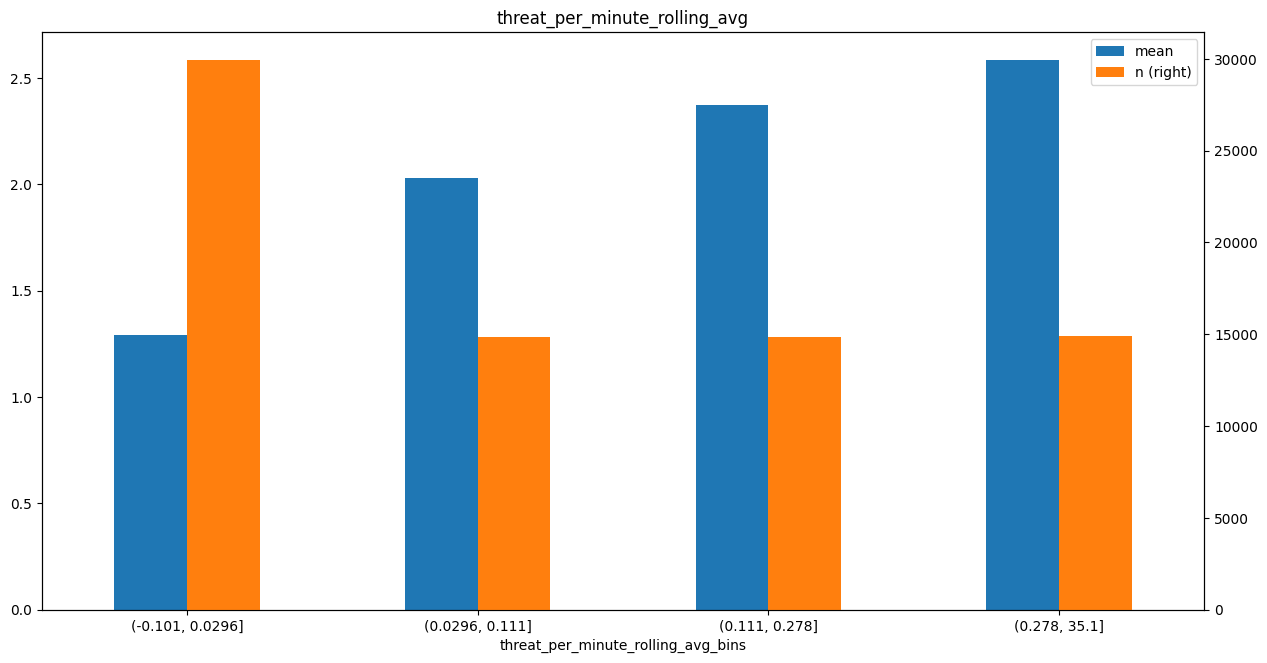

                                            mean      n
creativity_per_minute_rolling_avg_bins                 
(-0.101, 0.00228]                       1.060336  14900
(0.00228, 0.0472]                       1.678677  14904
(0.0472, 0.123]                         1.994562  14895
(0.123, 0.241]                          2.355393  14899
(0.241, 24.4]                           2.478591  14900


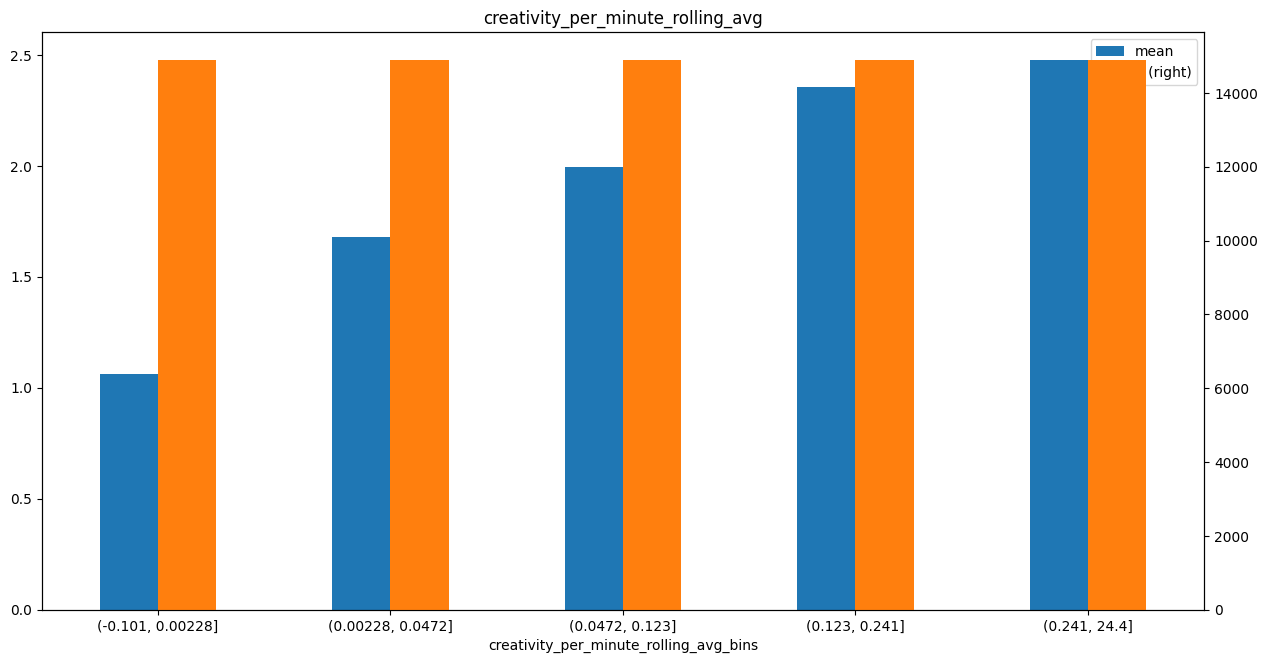

                                mean      n
bps_bins                                   
(-21.101000000000003, 0.0]  0.775707  26666
(0.0, 2.0]                  1.874653   3965
(2.0, 8.0]                  2.037312  14151
(8.0, 16.0]                 2.627289  15127
(16.0, 128.1]               3.143464  14589


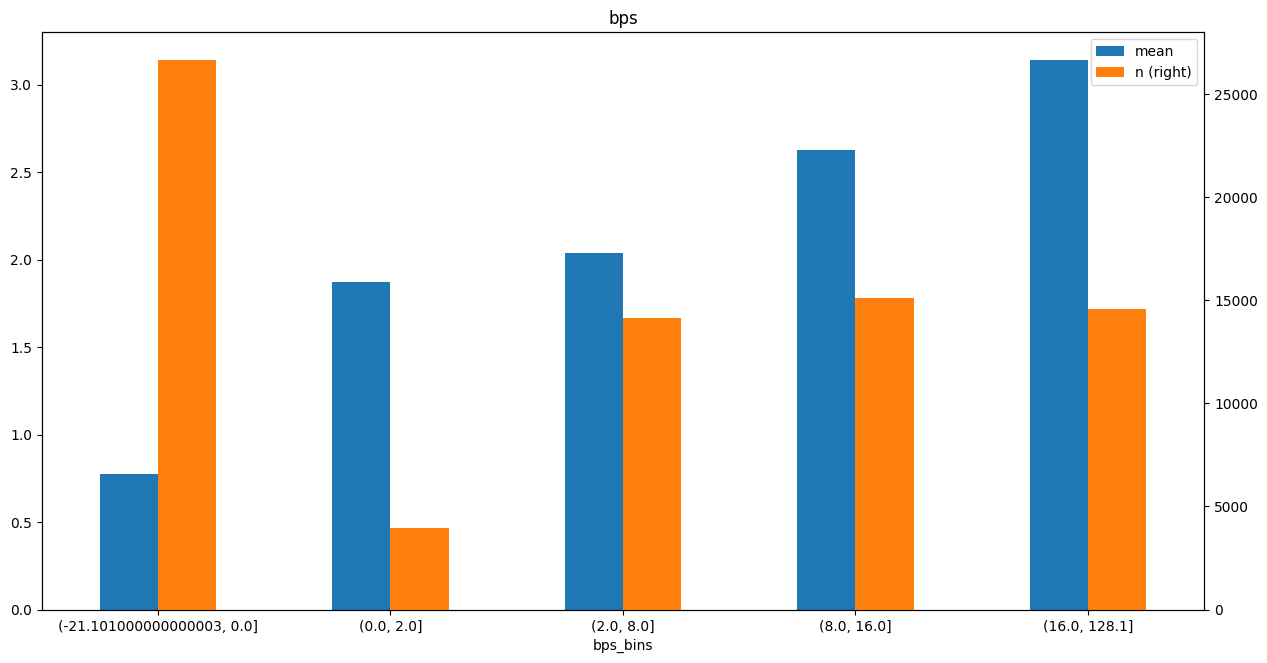

                                  mean      n
total_points_per_minute_bins                 
(-2.101, 0.0]                 0.774186  27133
(0.0, 0.0111]                 2.569196   5311
(0.0111, 0.0222]              2.732899  12748
(0.0222, 0.0667]              2.545342  17026
(0.0667, 7.1]                 2.420521  12280


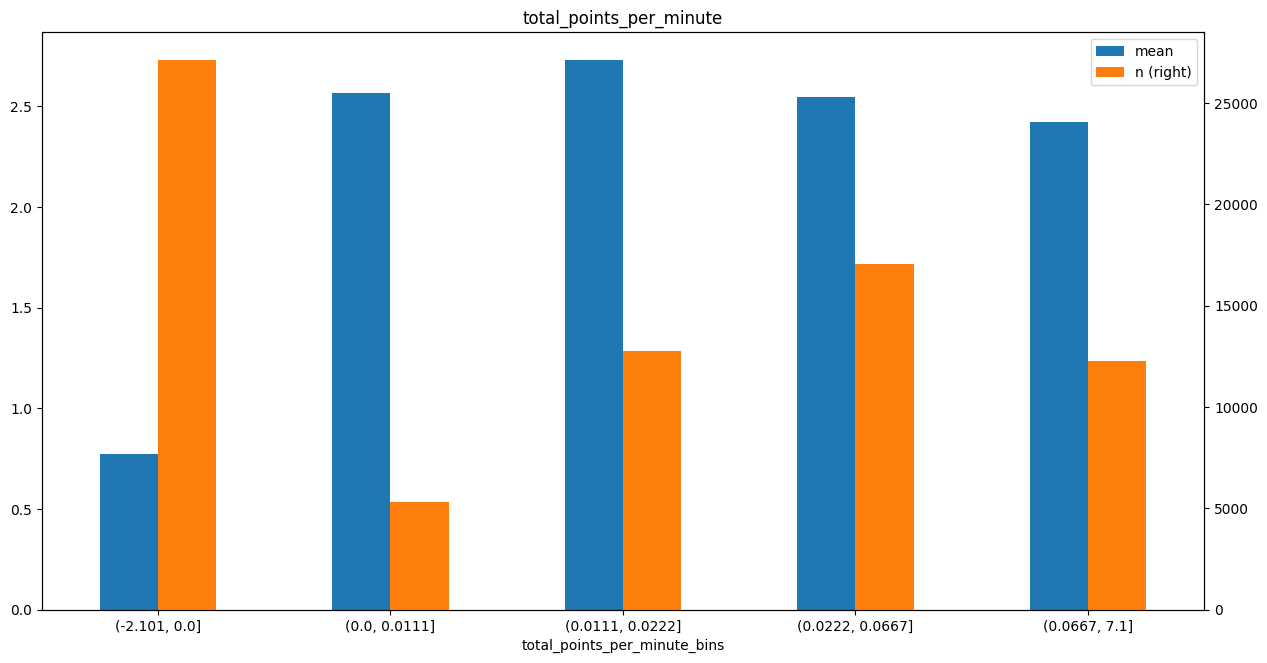

                                     mean      n
bps_per_minute_rolling_avg_bins                 
(-7.101, 0.0831]                 0.902617  14900
(0.0831, 0.149]                  2.016377  14899
(0.149, 0.199]                   2.345705  14900
(0.199, 0.278]                   2.520930  14931
(0.278, 27.1]                    1.780266  14868


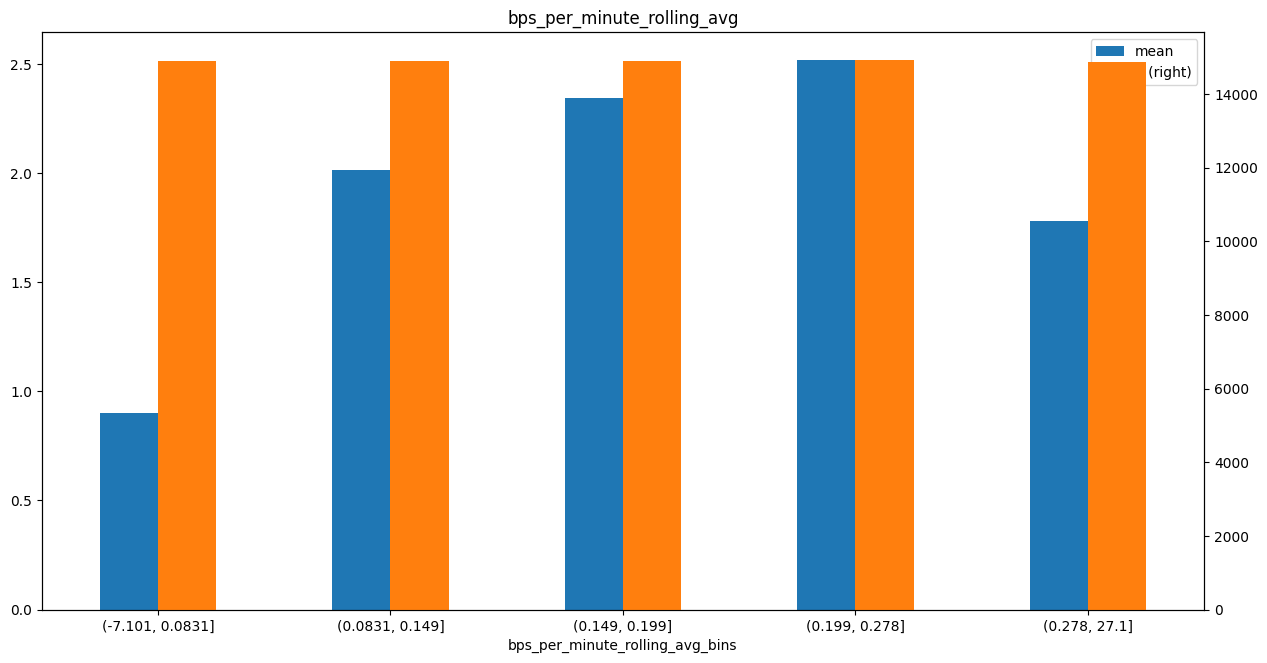

                                           mean      n
influence_per_minute_rolling_avg_bins                 
(-0.101, 0.0578]                       0.668230  14926
(0.0578, 0.147]                        1.864318  14873
(0.147, 0.208]                         2.183893  14900
(0.208, 0.296]                         2.461018  14930
(0.296, 33.1]                          2.391956  14869


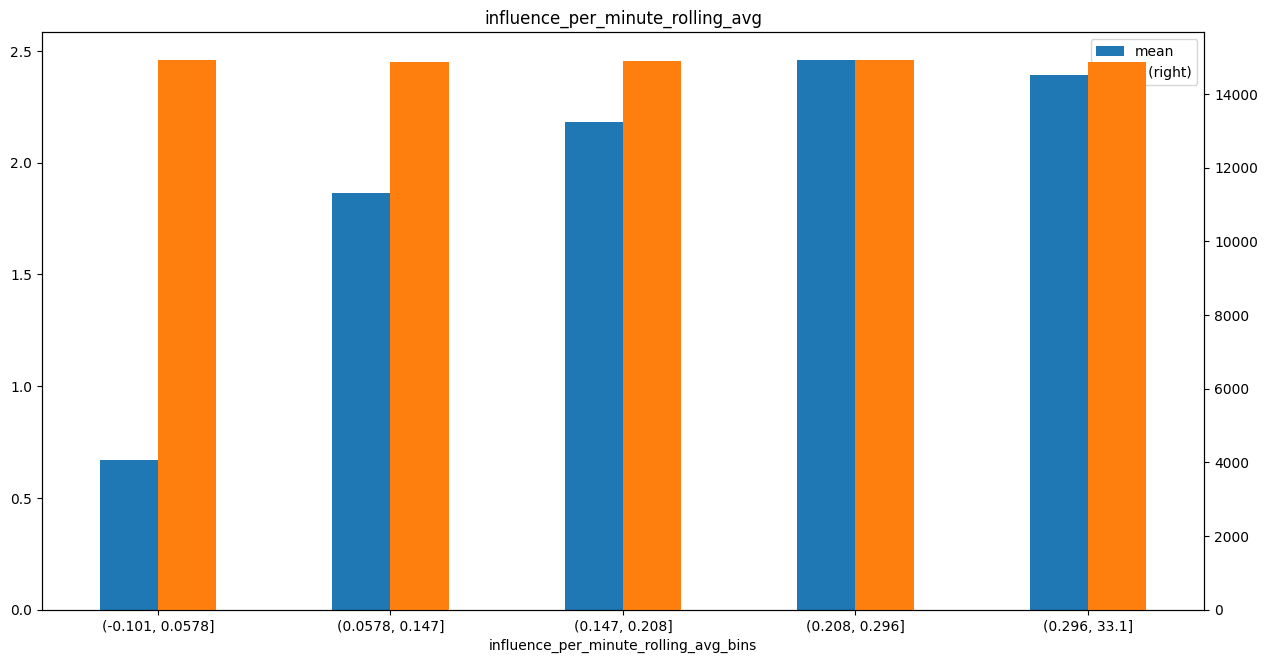

                                       mean      n
bonus_per_minute_rolling_avg_bins                 
(-0.101, 0.00298]                  1.636867  59631
(0.00298, 1.1]                     3.023004  14867


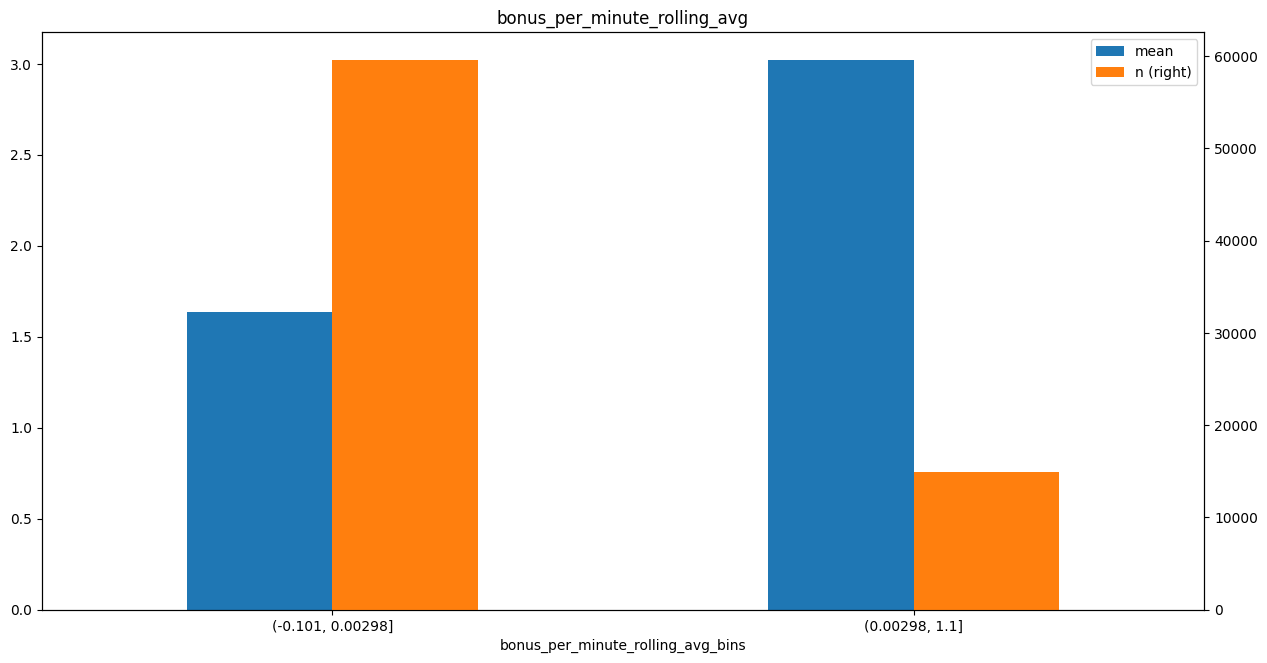

           mean      n
bonus                 
0.0    1.794371  68823
1.0    3.167810   1895
2.0    3.367663   1874
3.0    3.537775   1906


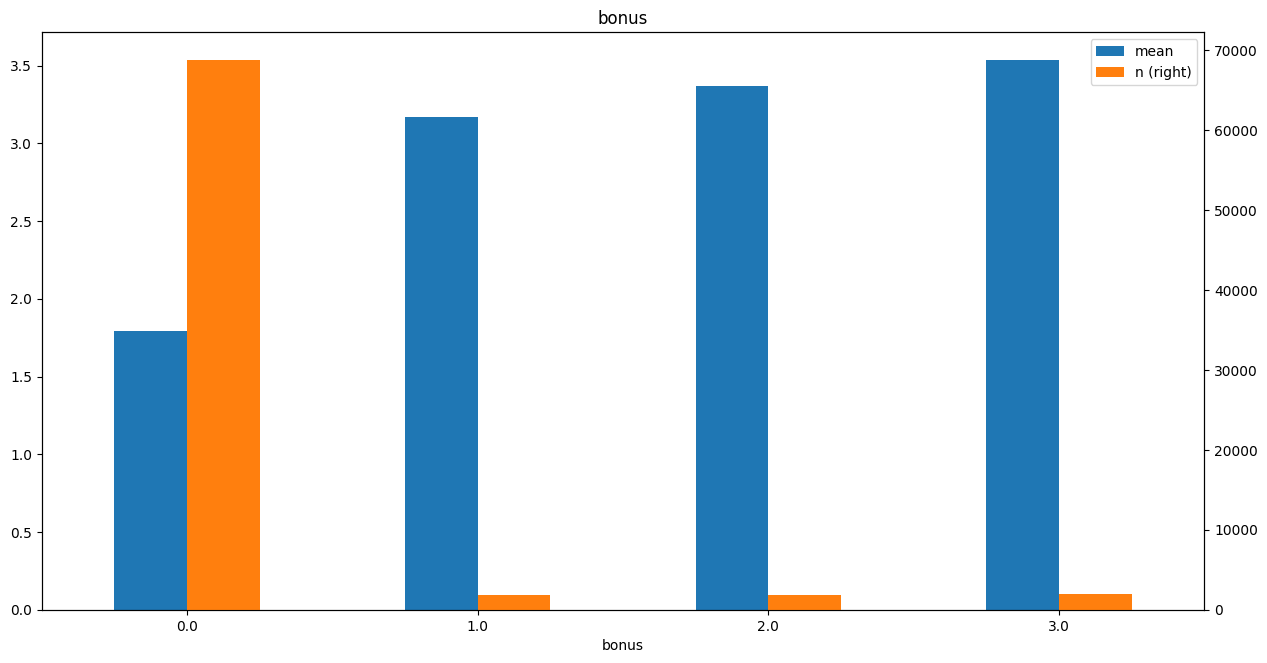

                                           mean      n
pct_transfer_balance_rolling_avg_bins                 
(-1.269, -0.0549]                      1.622282  14900
(-0.0549, -0.0172]                     1.693000  14899
(-0.0172, 0.0]                         1.527386  16870
(0.0, 0.0393]                          2.215949  12929
(0.0393, 1.075]                        2.599866  14900


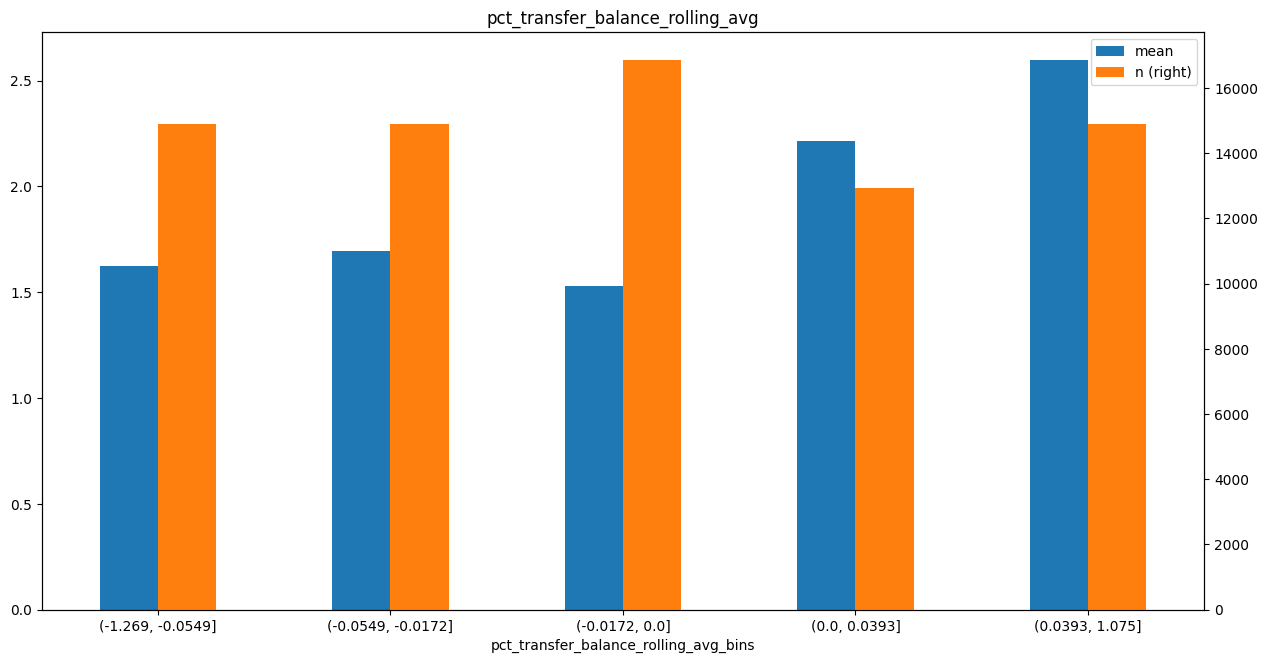

                                              mean      n
total_points_per_minute_rolling_avg_bins                 
(-2.101, 0.0167]                          0.882178  15167
(0.0167, 0.0306]                          2.107342  14682
(0.0306, 0.0472]                          2.405235  14937
(0.0472, 0.0778]                          2.493894  15066
(0.0778, 7.1]                             1.688584  14646


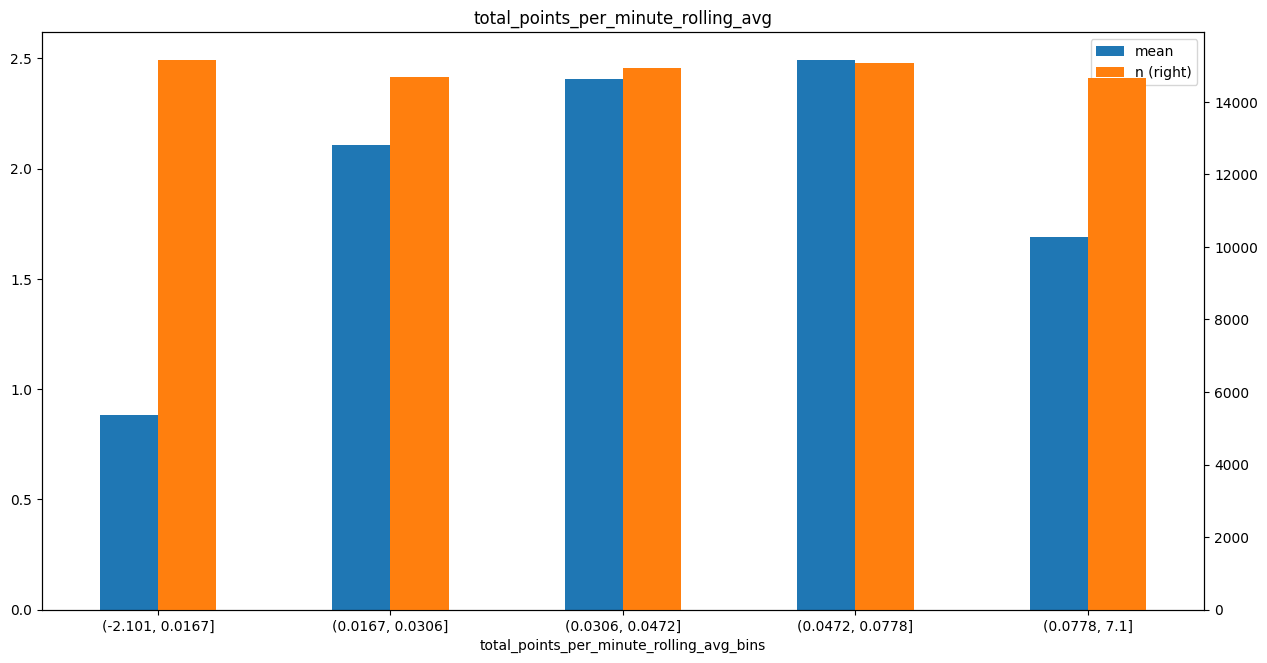

                       mean      n
total_points_bins                 
(-7.101, 0.0]      0.774186  27133
(0.0, 1.0]         1.880406  17526
(1.0, 2.0]         2.798566  13950
(2.0, 3.0]         2.876183   3594
(3.0, 26.1]        3.189264  12295


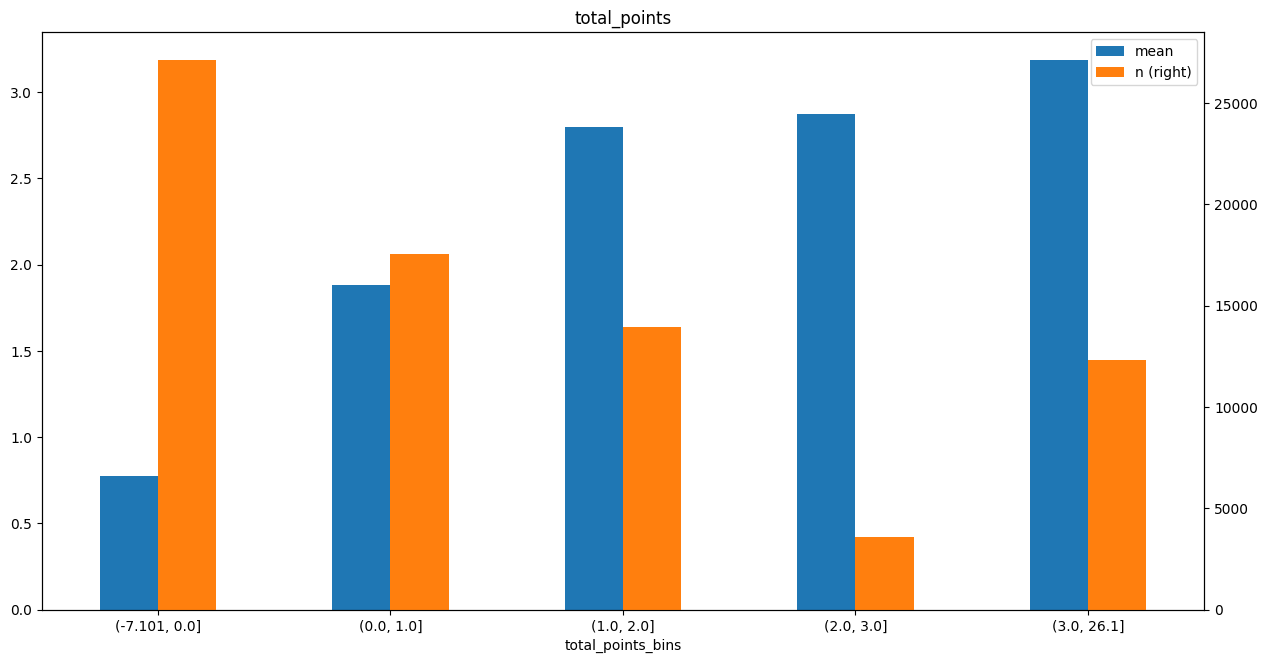

                                                mean      n
goals_conceded_per_minute_rolling_avg_bins                 
(-0.101, 0.00833]                           1.523622  30692
(0.00833, 0.0148]                           2.513273  14503
(0.0148, 0.0223]                            2.342568  14403
(0.0223, 9.1]                               1.717987  14900


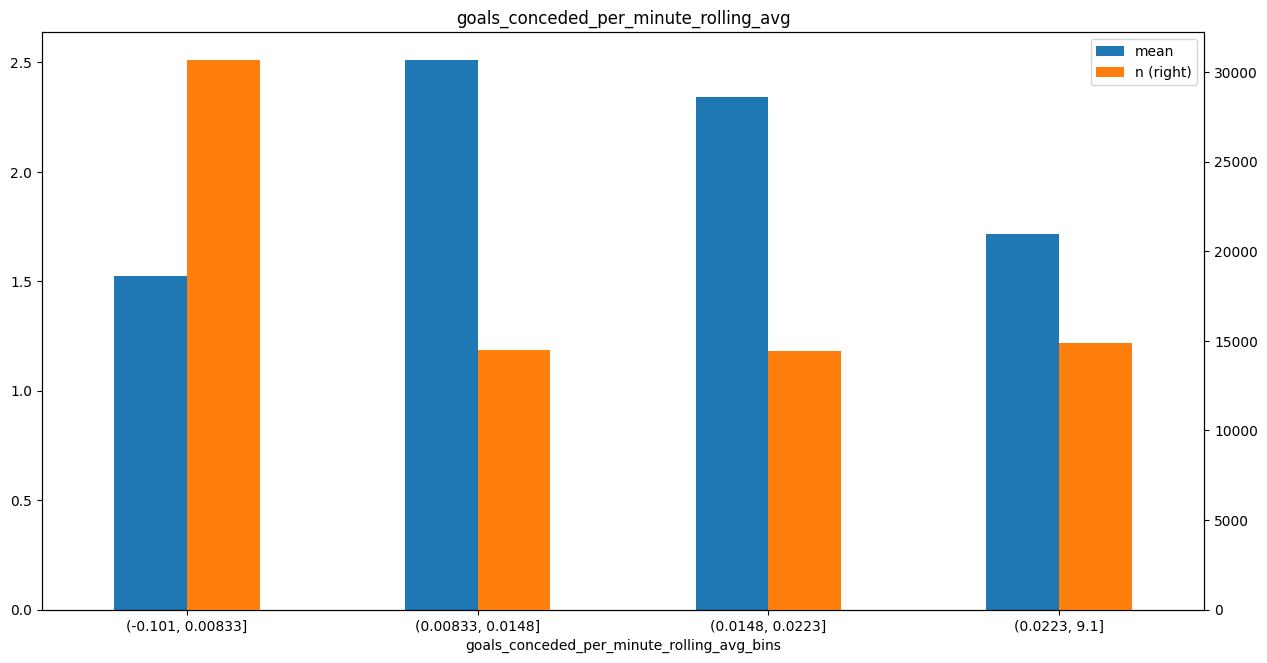

                  mean      n
goals_scored                 
0.0           1.815138  70182
1.0           3.441214   3887
2.0           4.121294    371
3.0           4.407407     54
4.0           4.500000      4


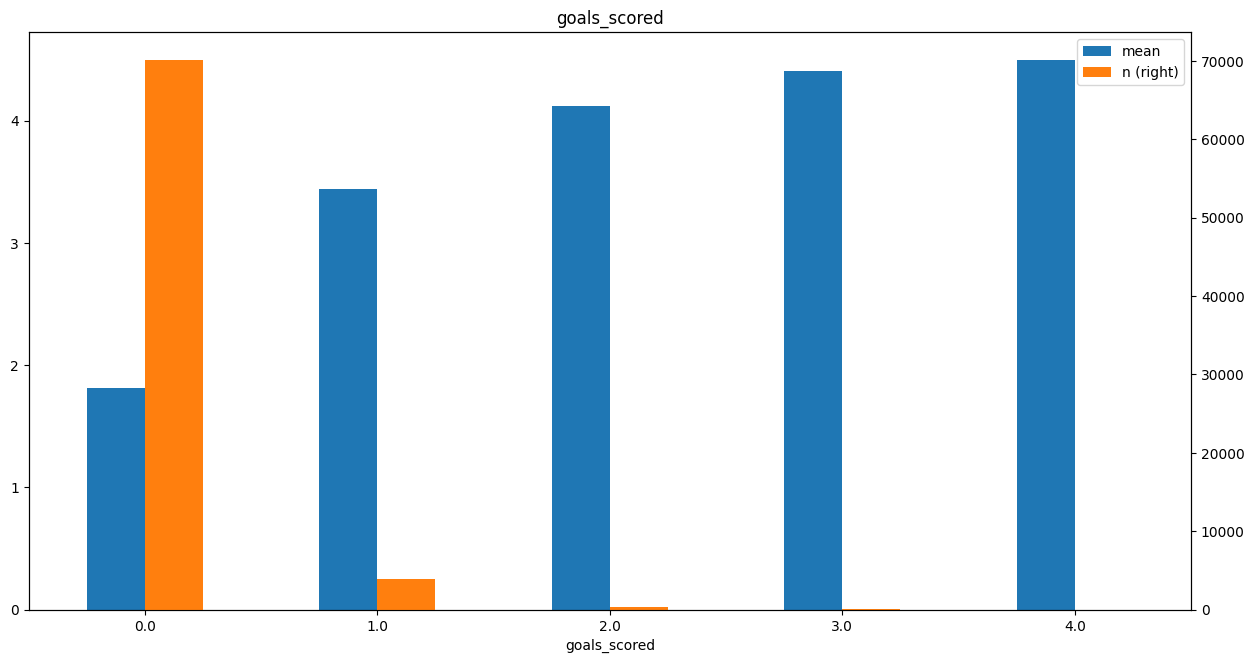

                                     mean      n
expected_goal_involvements_bins                 
(-0.101, 0.1]                    1.785765  67034
(0.1, 3.98]                      3.060557   7464


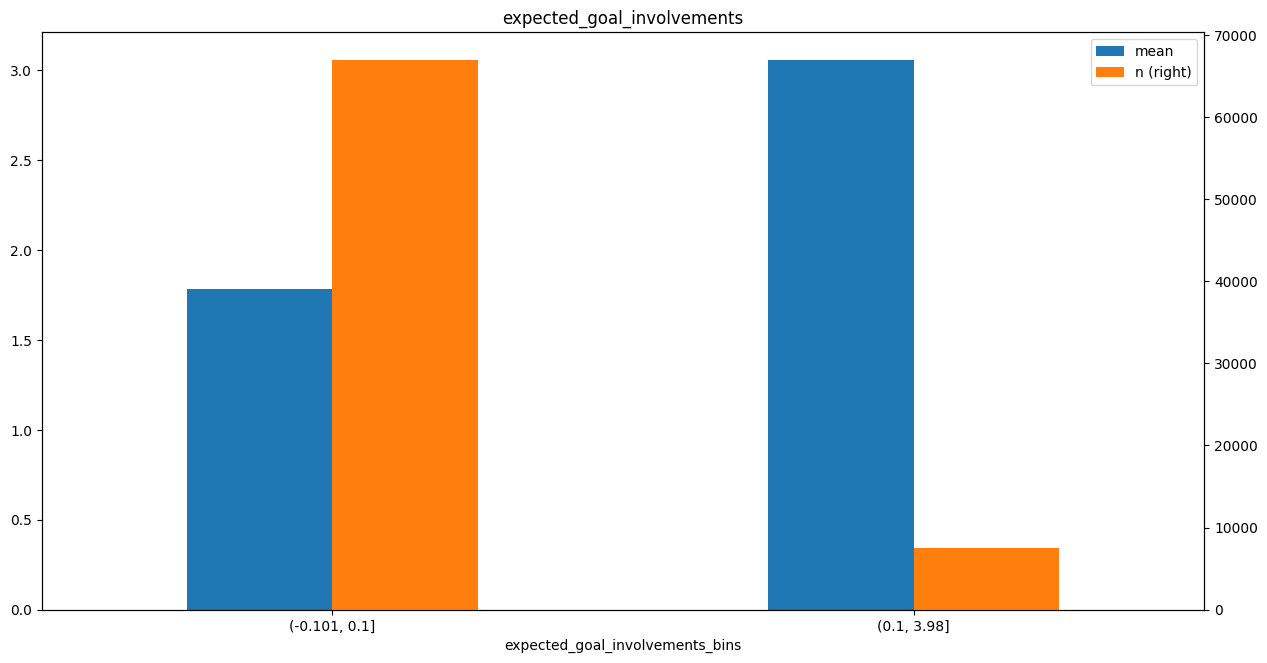

                                  mean      n
expected_goals_conceded_bins                 
(-0.101, 0.4]                 1.729353  59646
(0.4, 7.92]                   2.652976  14852


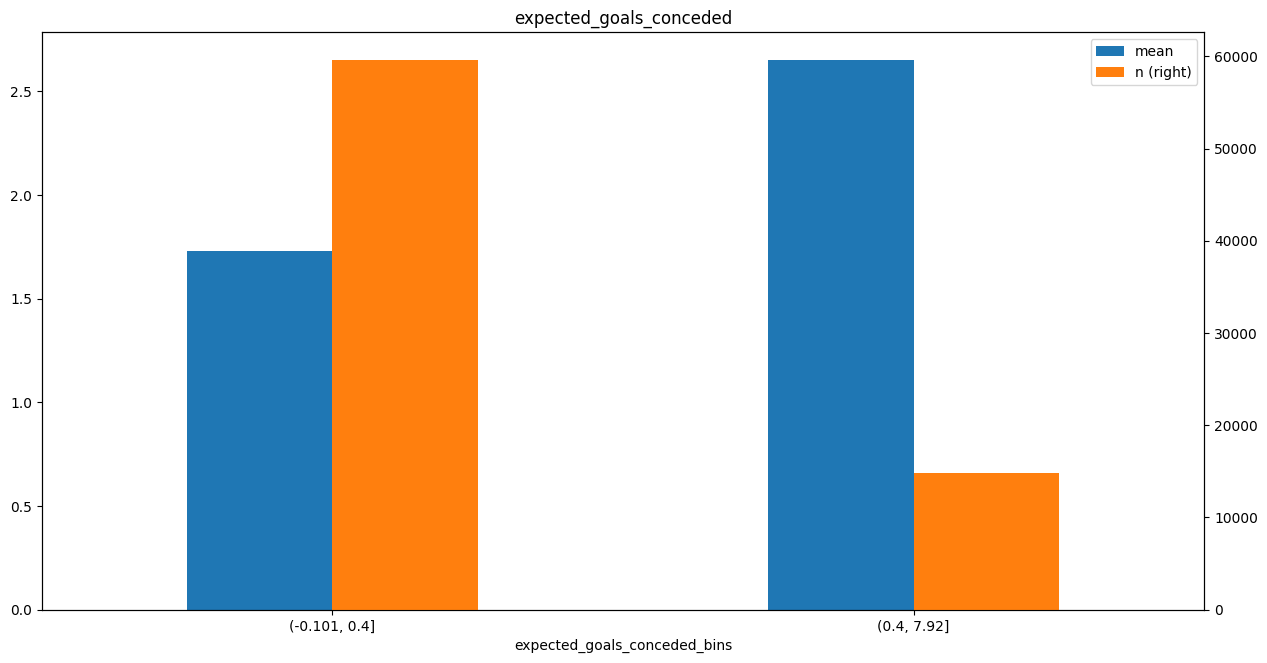

                    mean      n
goals_conceded                 
0.0             1.412188  43764
8.0             1.625000     16
9.0             2.041667     24
7.0             2.047619     42
4.0             2.498534   1364
1.0             2.618499  15806
2.0             2.640774   8780
3.0             2.657754   4114
5.0             2.714286    462
6.0             3.309524    126


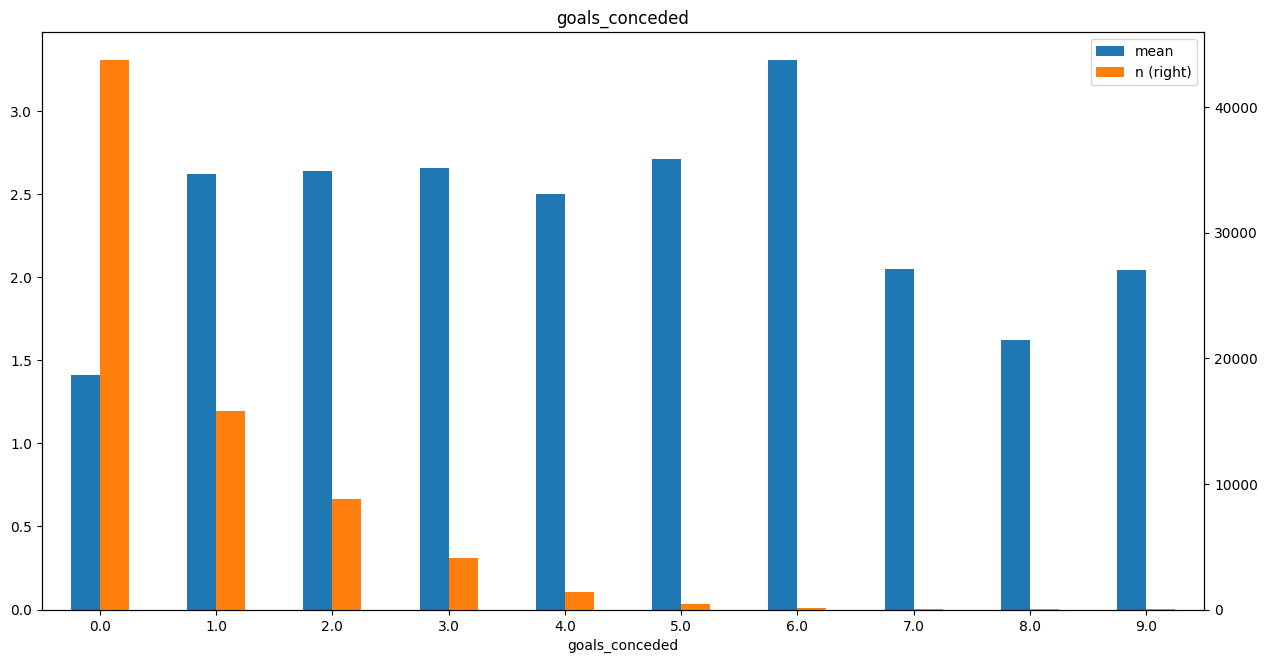

                                    mean      n
goals_conceded_per_minute_bins                 
(-0.101, 0.0111]                1.690933  53037
(0.0111, 0.0222]                2.636399  10341
(0.0222, 9.1]                   2.302698  11120


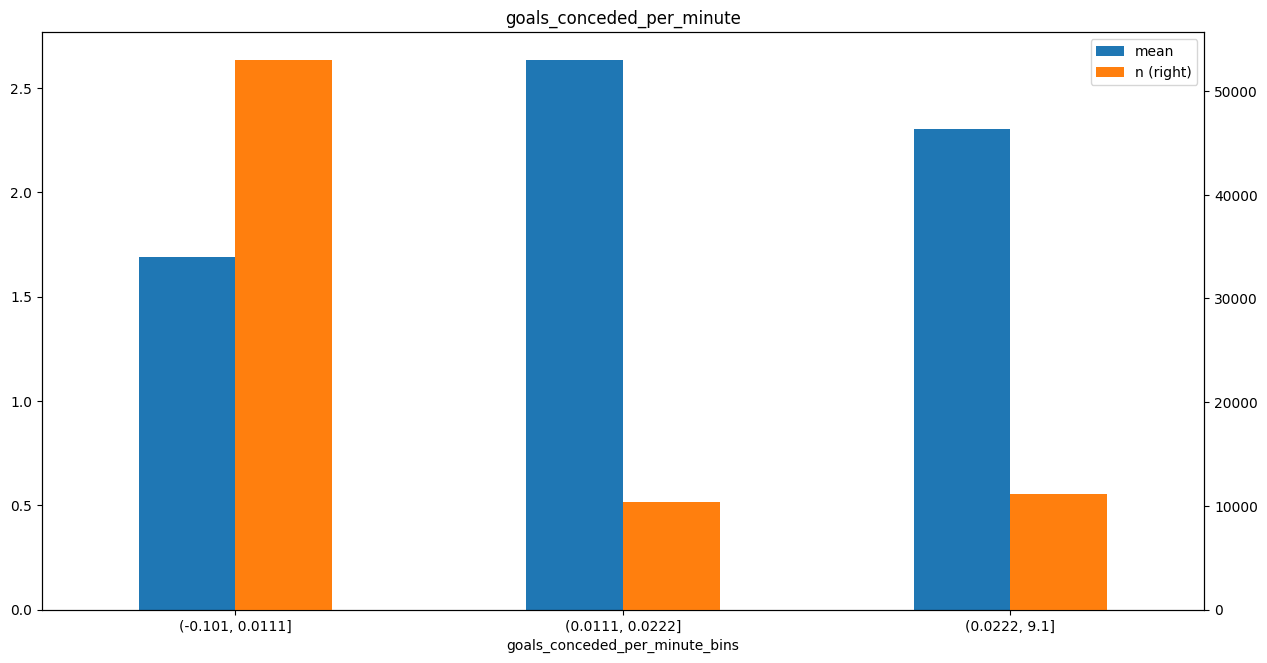

                                 mean      n
selected_index_change4_bins                 
(0.039, 0.879]               1.700134  14900
(0.879, 0.973]               1.682193  14899
(0.973, 1.017]               1.544765  14900
(1.017, 1.203]               2.142694  14899
(1.203, 310.665]             2.497651  14900


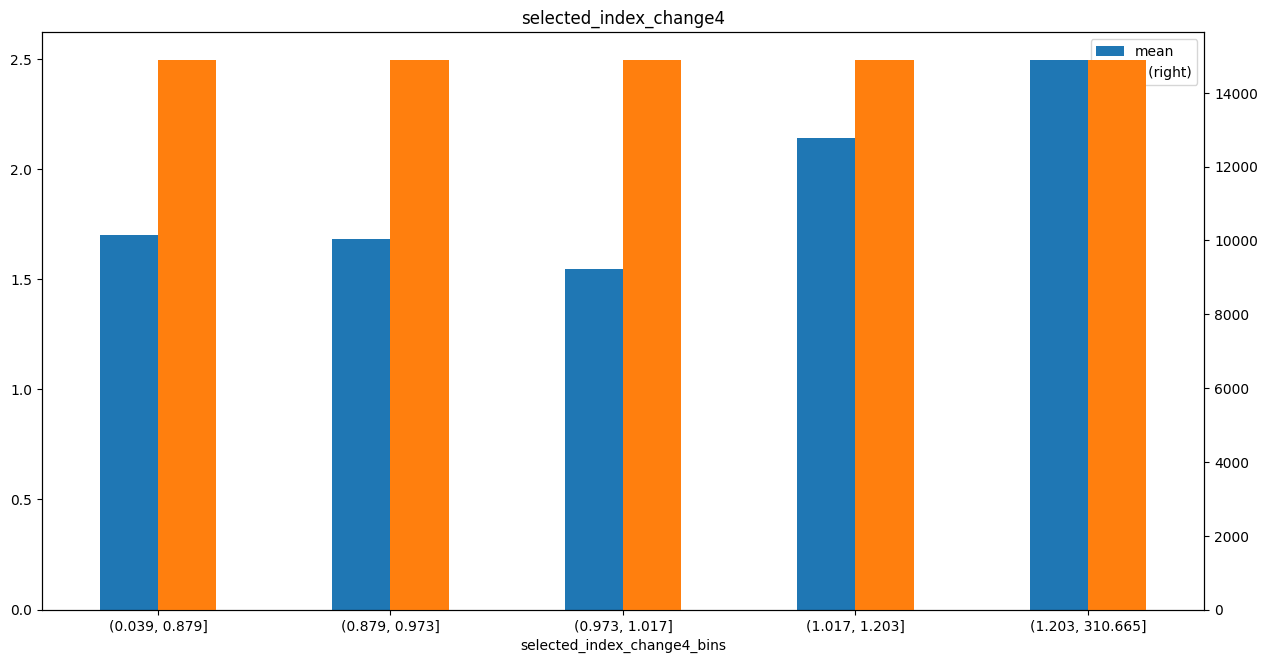

                                              mean      n
expected_goals_conceded_rolling_avg_bins                 
(-0.101, 0.62]                            1.746340  59627
(0.62, 4.695]                             2.583686  14871


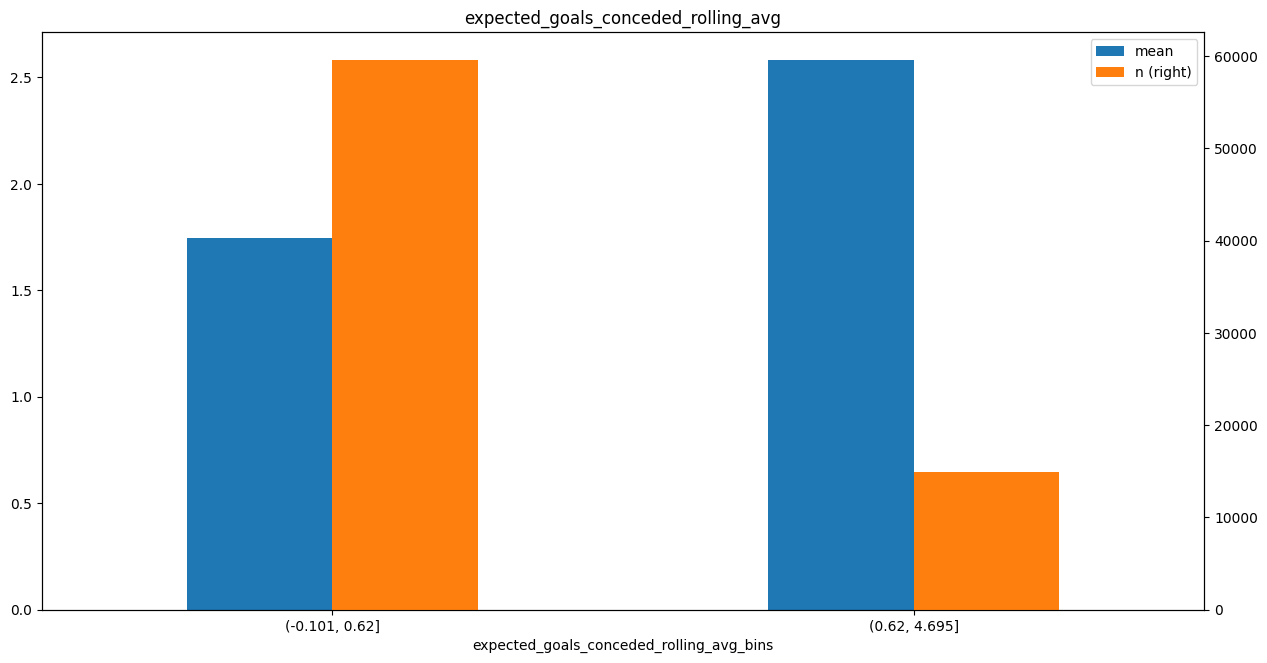

                         mean      n
expected_goals_bins                 
(-0.101, 0.1]        1.829257  69877
(0.1, 2.87]          3.187189   4621


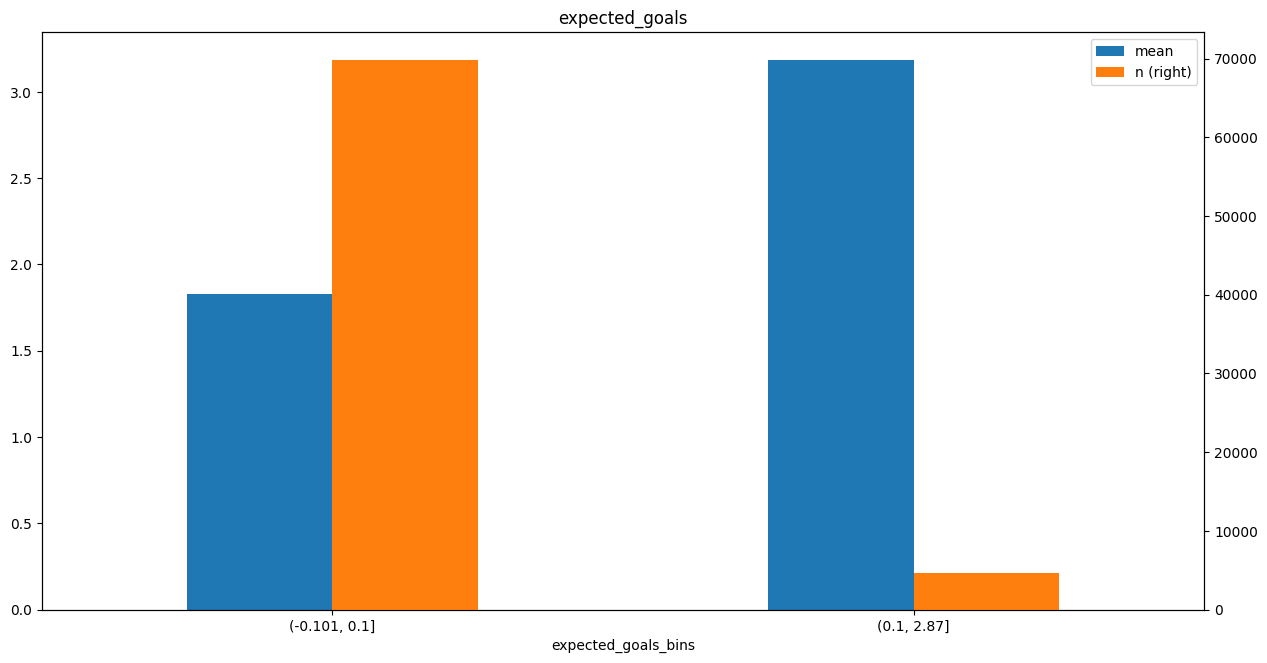

                                             mean      n
selected_index_change4_rolling_avg_bins                 
(0.17, 0.907]                            1.691007  14900
(0.907, 0.984]                           1.648970  14899
(0.984, 1.032]                           1.662148  14900
(1.032, 1.23]                            2.179140  14899
(1.23, 102.362]                          2.386174  14900


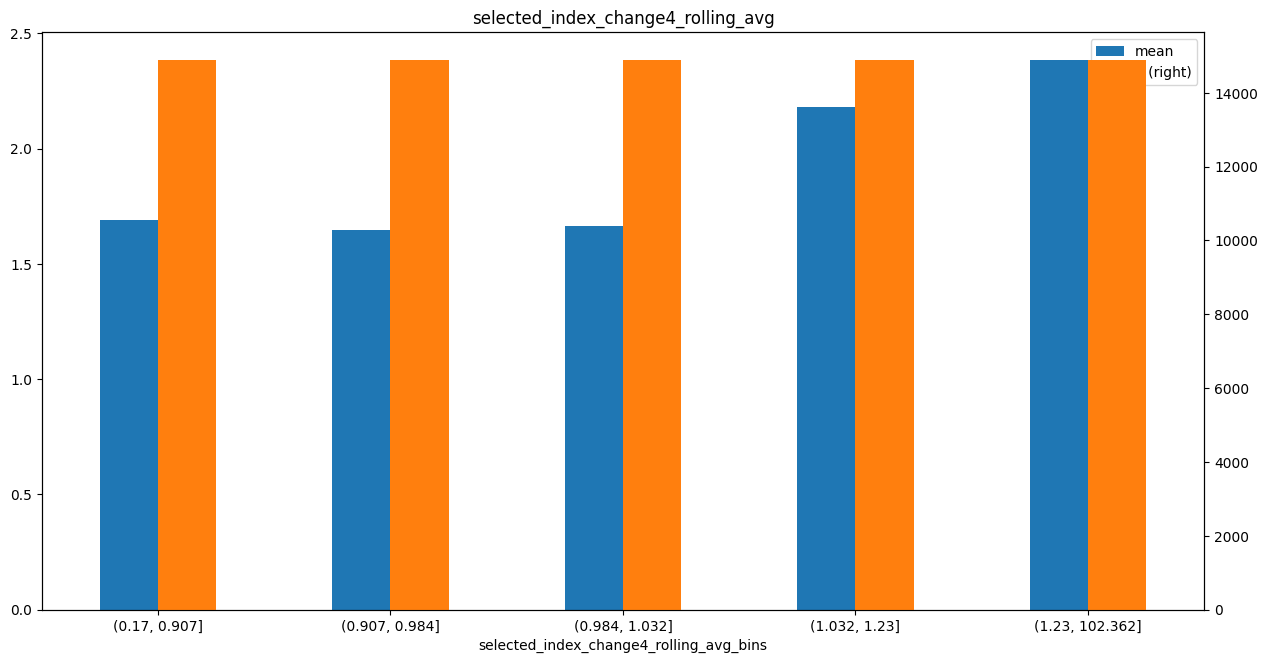

                                                 mean      n
expected_goal_involvements_rolling_avg_bins                 
(-0.101, 0.0375]                             1.762982  59755
(0.0375, 1.84]                               2.523503  14743


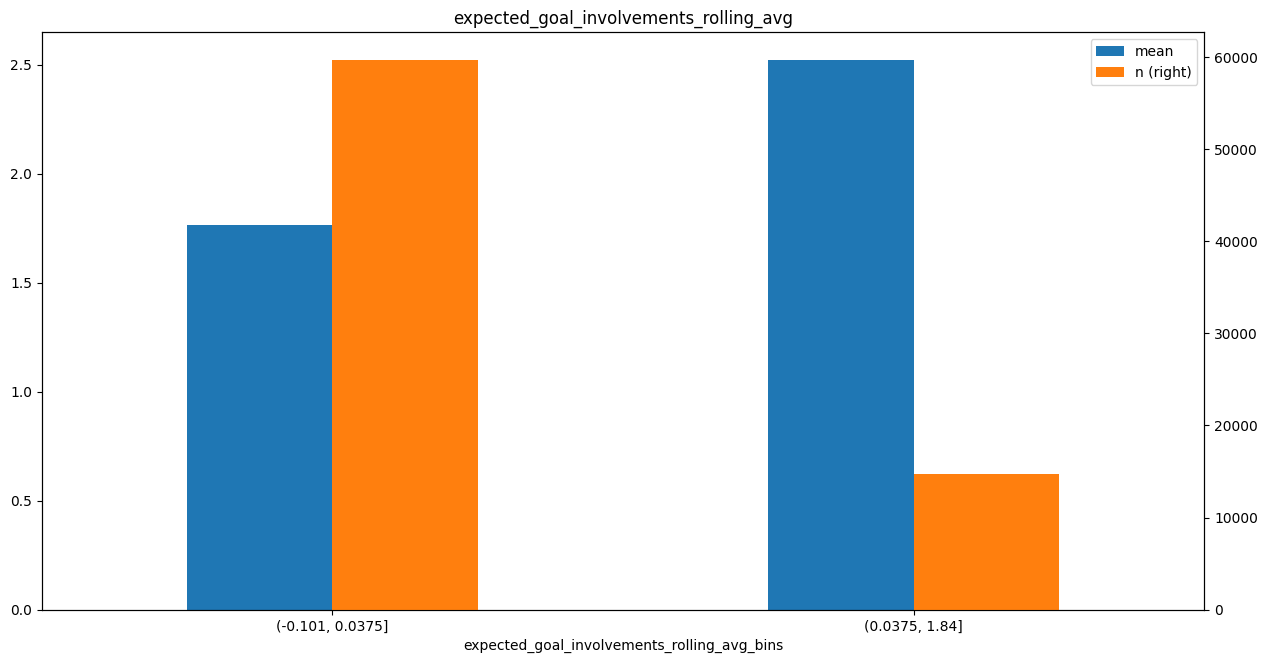

             mean      n
assists                 
0.0      1.841672  70499
4.0      3.000000      3
1.0      3.121475   3688
2.0      3.807829    281
3.0      4.592593     27


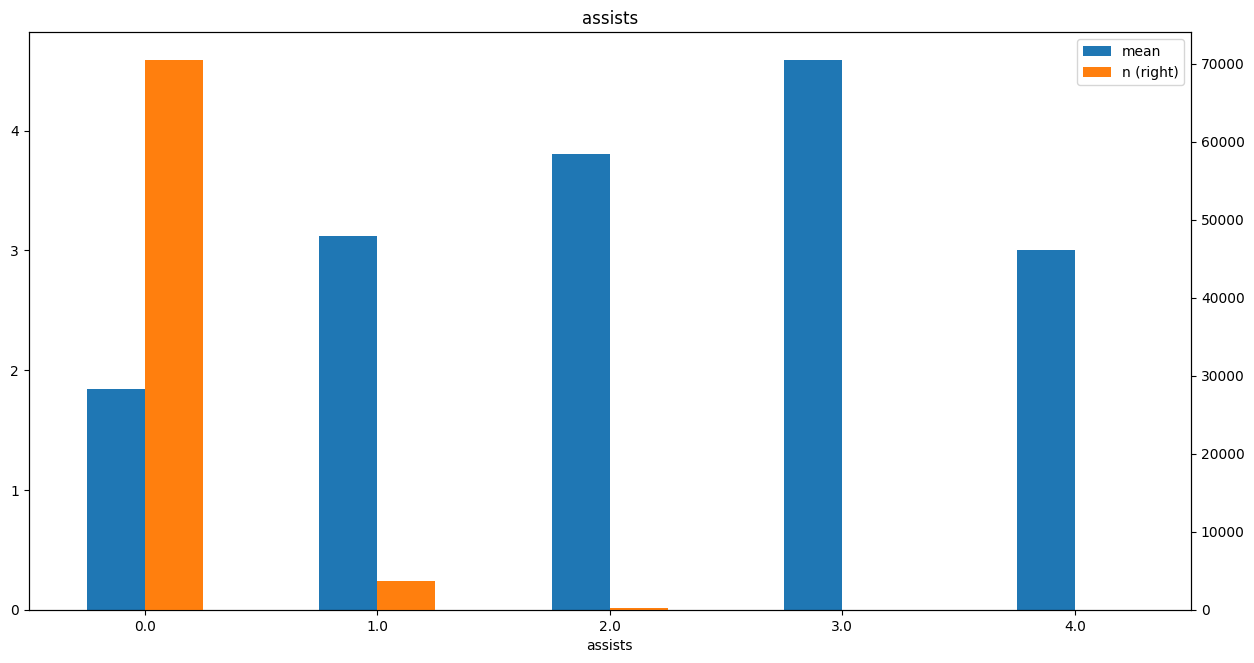

           mean      n
saves                 
0.0    1.848878  71194
9.0    2.000000     32
10.0   2.000000      6
11.0   2.000000      2
3.0    3.168345    695
8.0    3.207547     53
4.0    3.227799    518
2.0    3.300518    772
5.0    3.400662    302
1.0    3.426494    619
6.0    3.588542    192
7.0    3.639640    111
12.0   4.500000      2


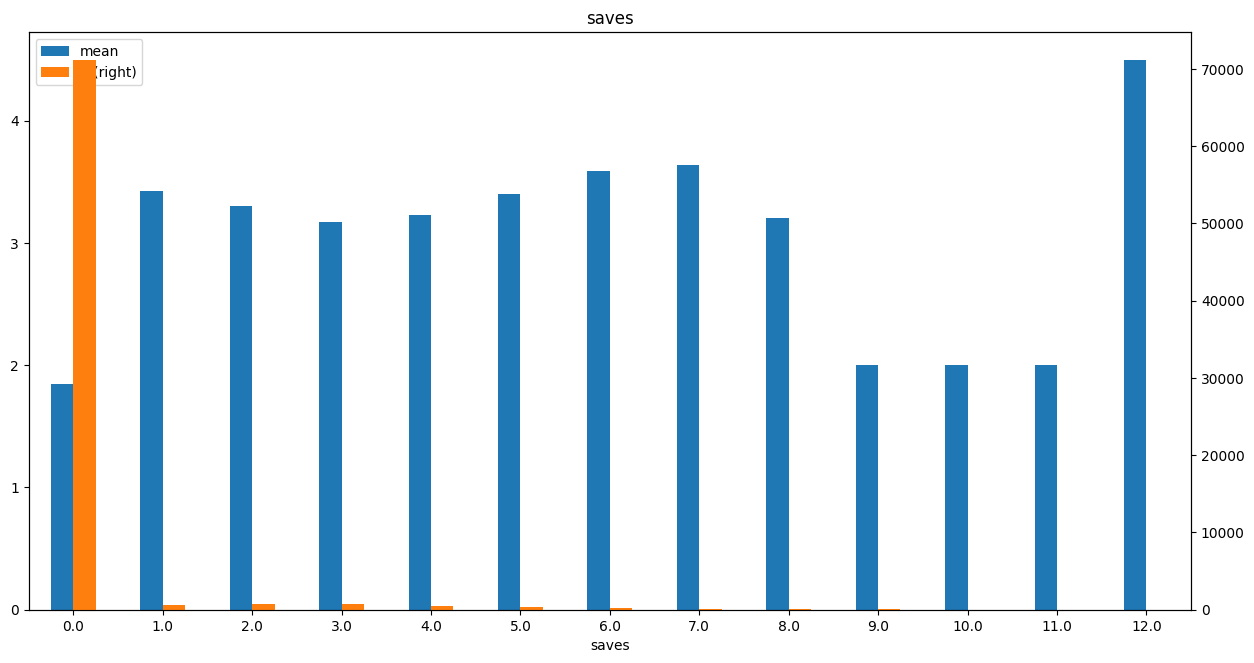

                                       mean      n
expected_assists_rolling_avg_bins                 
(-0.101, 0.01]                     1.769906  60006
(0.01, 1.1]                        2.508004  14492


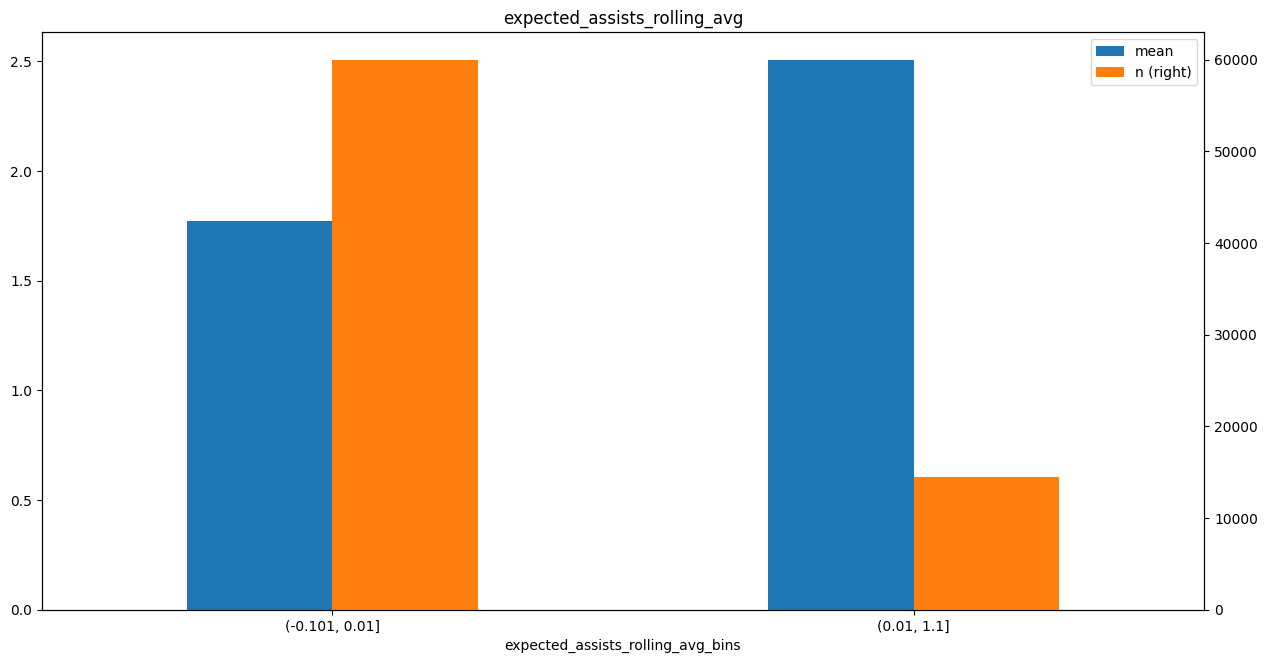

                           mean      n
expected_assists_bins                 
(-0.101, 0.1]          1.853534  71129
(0.1, 1.57]            3.179282   3369


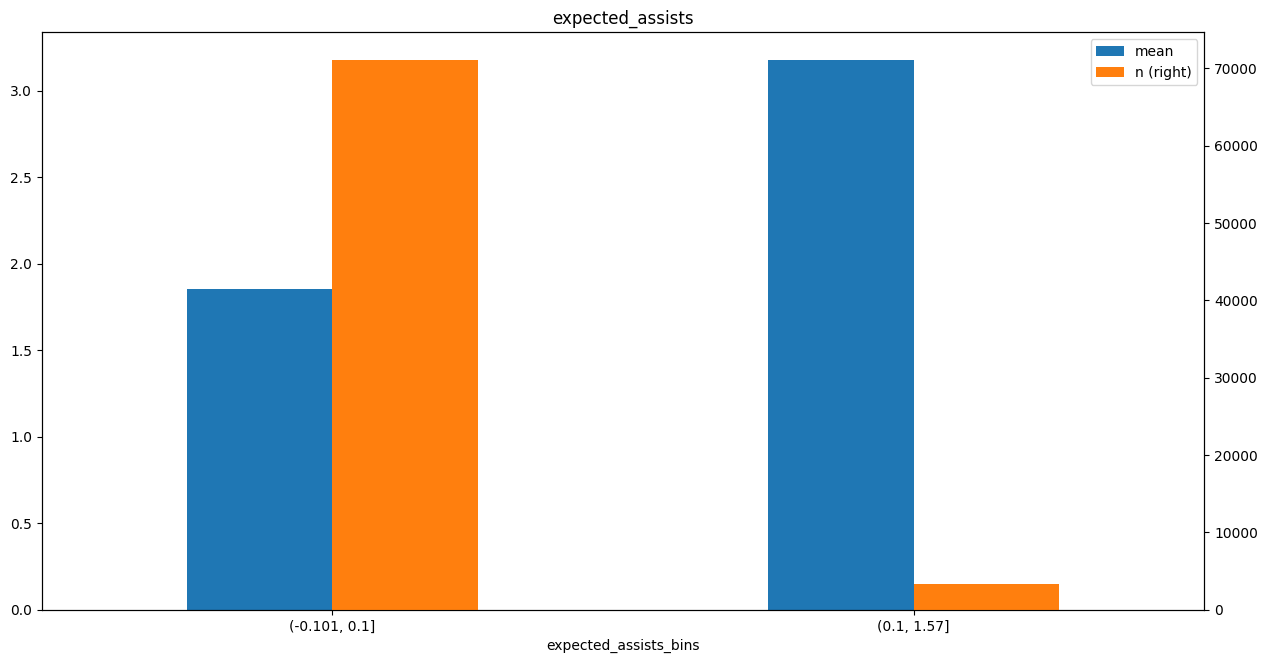

                                     mean      n
expected_goals_rolling_avg_bins                 
(-0.101, 0.01]                   1.777002  59745
(0.01, 1.79]                     2.466210  14753


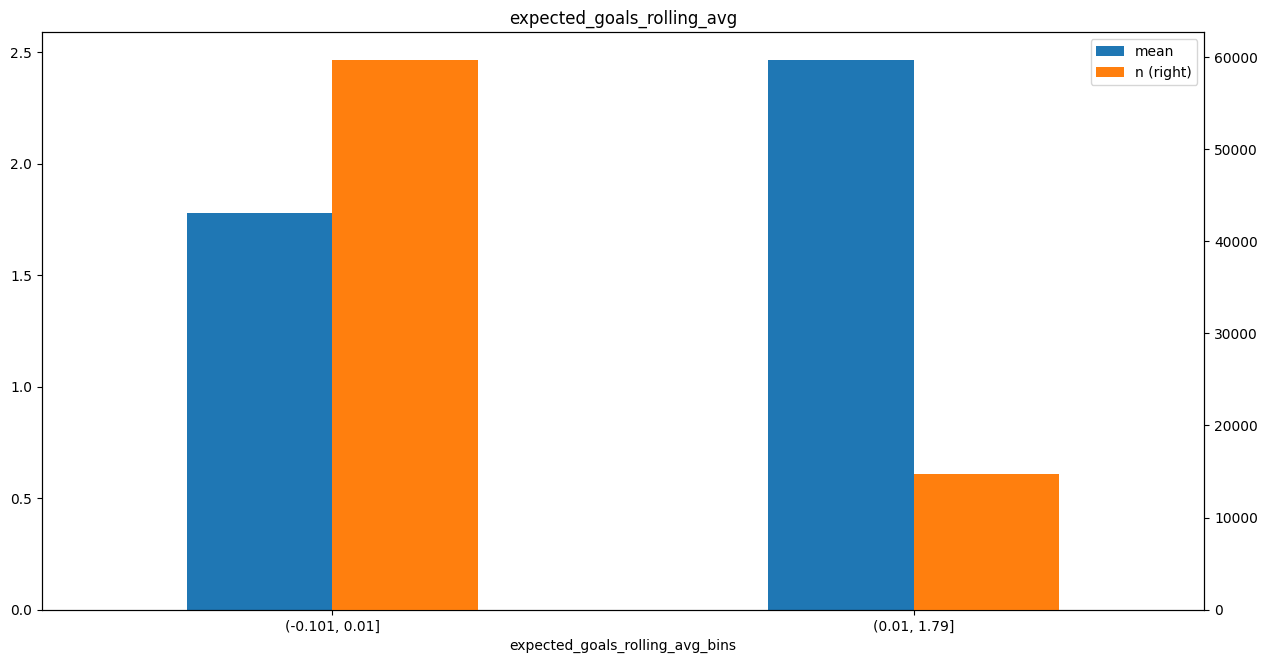

                                             mean      n
expected_goals_conceded_per_minute_bins                 
(-0.101, 0.00789]                        1.781241  59641
(0.00789, 1.53]                          2.444370  14857


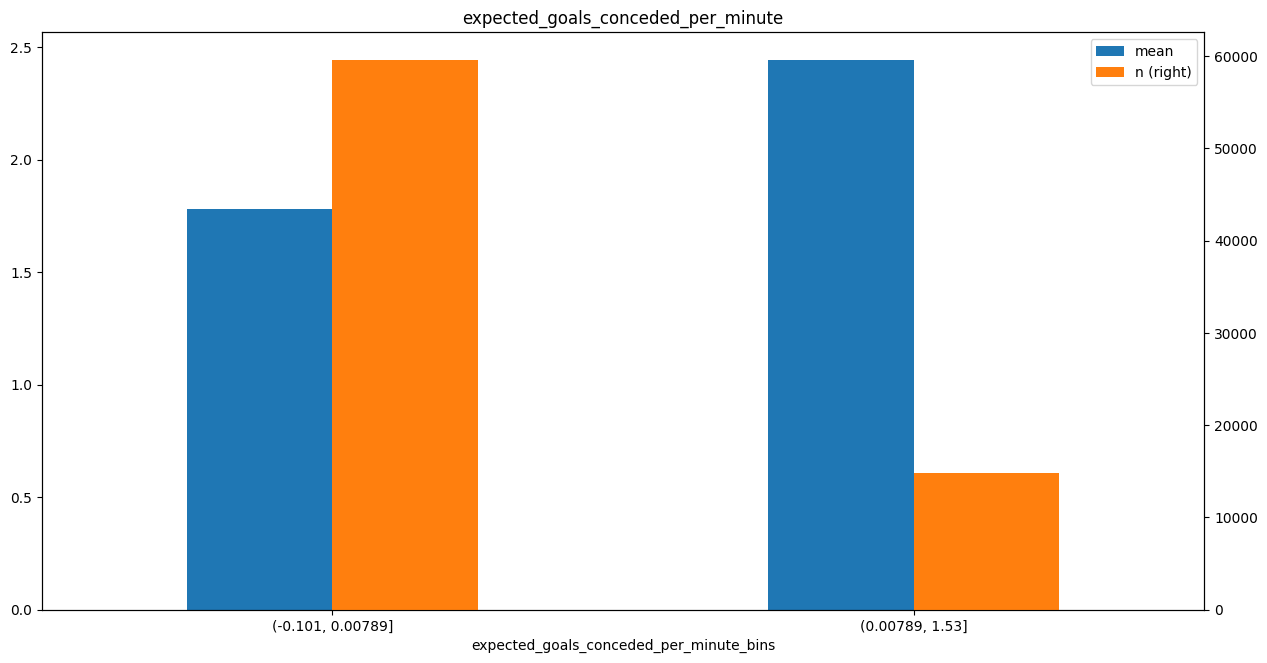

                            mean      n
saves_rolling_avg_bins                 
(-0.101, 0.1]           1.852463  70389
(0.1, 9.1]              2.958871   4109


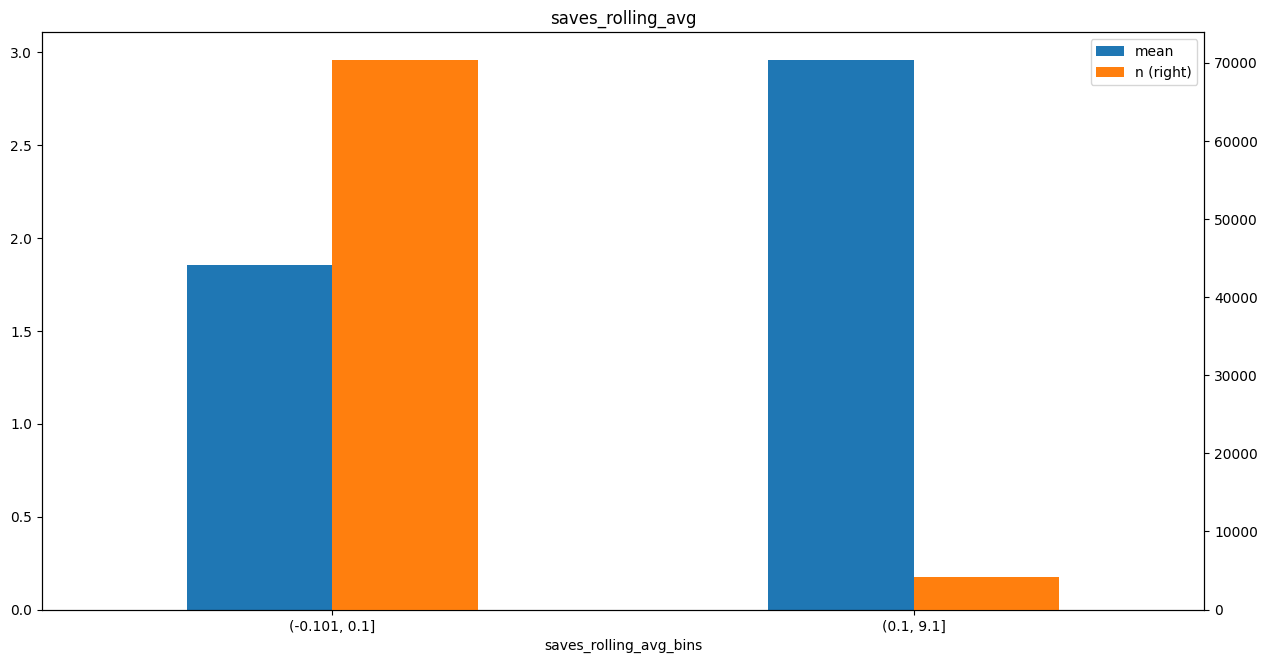

                                                mean      n
expected_goals_per_minute_rolling_avg_bins                 
(-0.101, 0.000222]                          1.792788  59813
(0.000222, 0.38]                            2.405107  14685


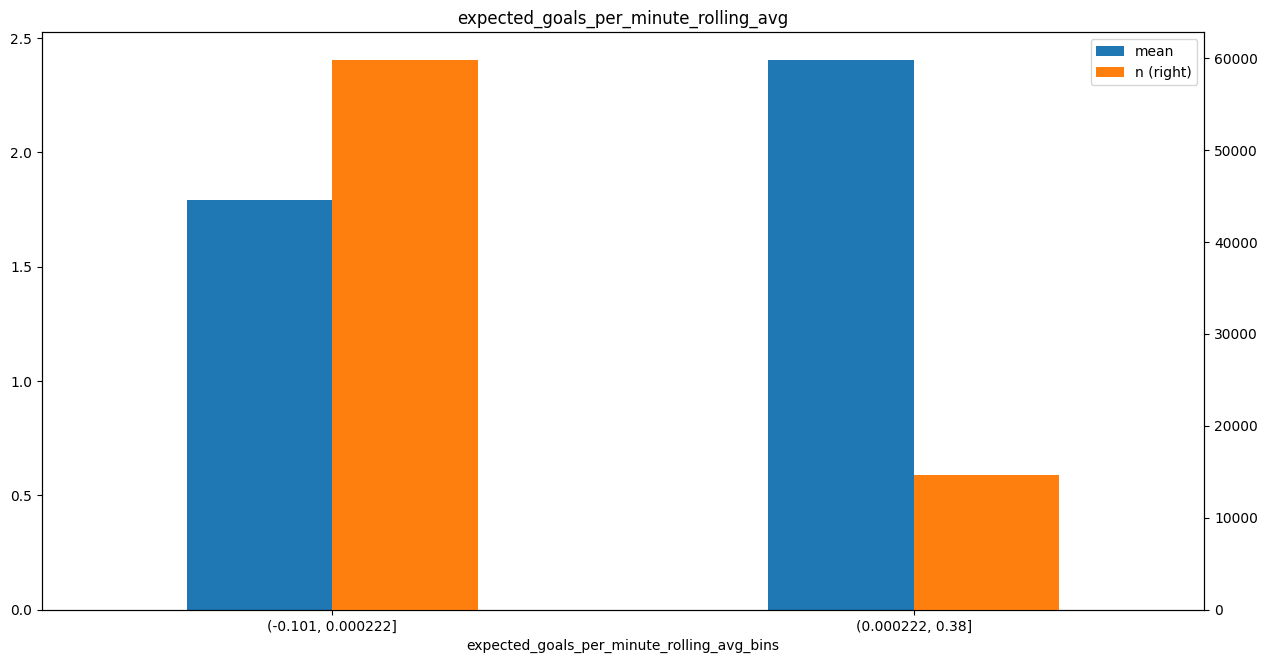

                   mean     n
next_opponent                
MCI            1.362354  3687
LIV            1.469222  3704
TOT            1.648568  3702
ARS            1.669717  3715
CHE            1.724879  3722
AVL            1.792493  3730
IPS            1.800000   115
MUN            1.817282  3738
LEI            1.852376  3177
BHA            1.900295  3731
BRE            1.904140  2222
NEW            1.910547  3745
WHU            1.927618  3744
WOL            1.937800  3746
LUT            1.996219   529
NFO            2.030151  1393
EVE            2.046269  3739
CRY            2.062701  3732
FUL            2.083218  2163
LEE            2.131023  2366
SOU            2.147556  3192
BUR            2.176491  2867
BOU            2.259294  2152
SHU            2.317389  2007
WAT            2.339562  1552
WBA            2.377604   768
NOR            2.558333  1560


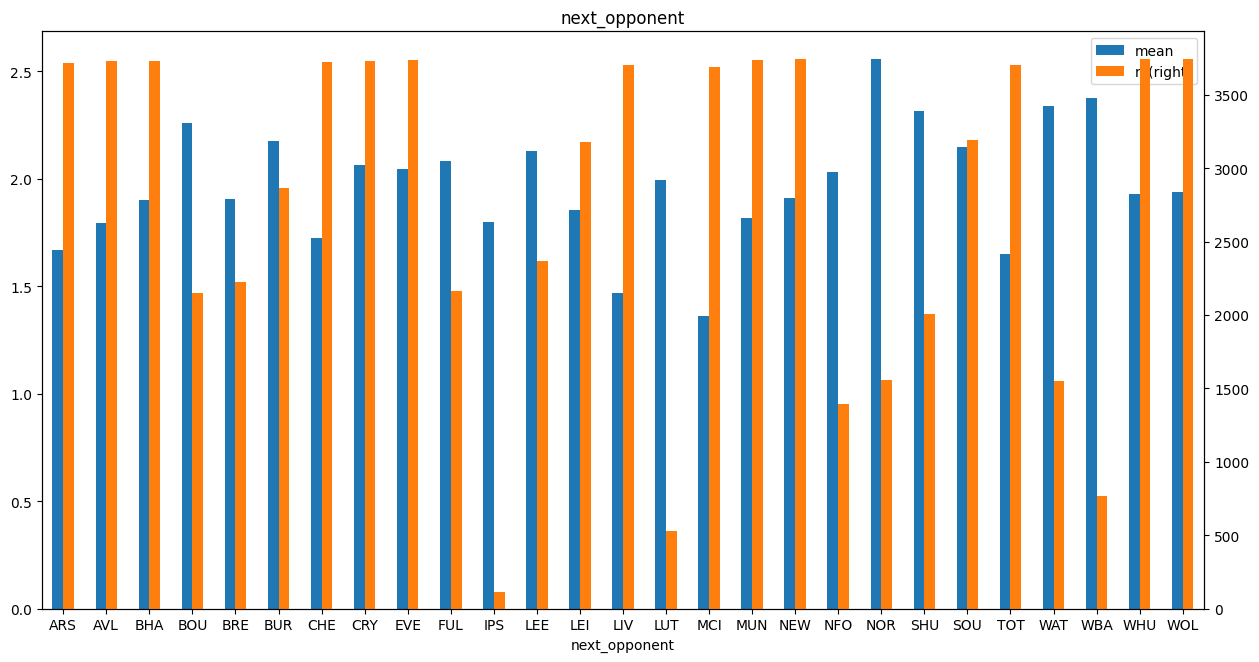

                                                        mean      n
expected_goal_involvements_per_minute_rolling_a...                 
(-0.101, 0.000889]                                  1.797807  59646
(0.000889, 0.5]                                     2.378064  14852


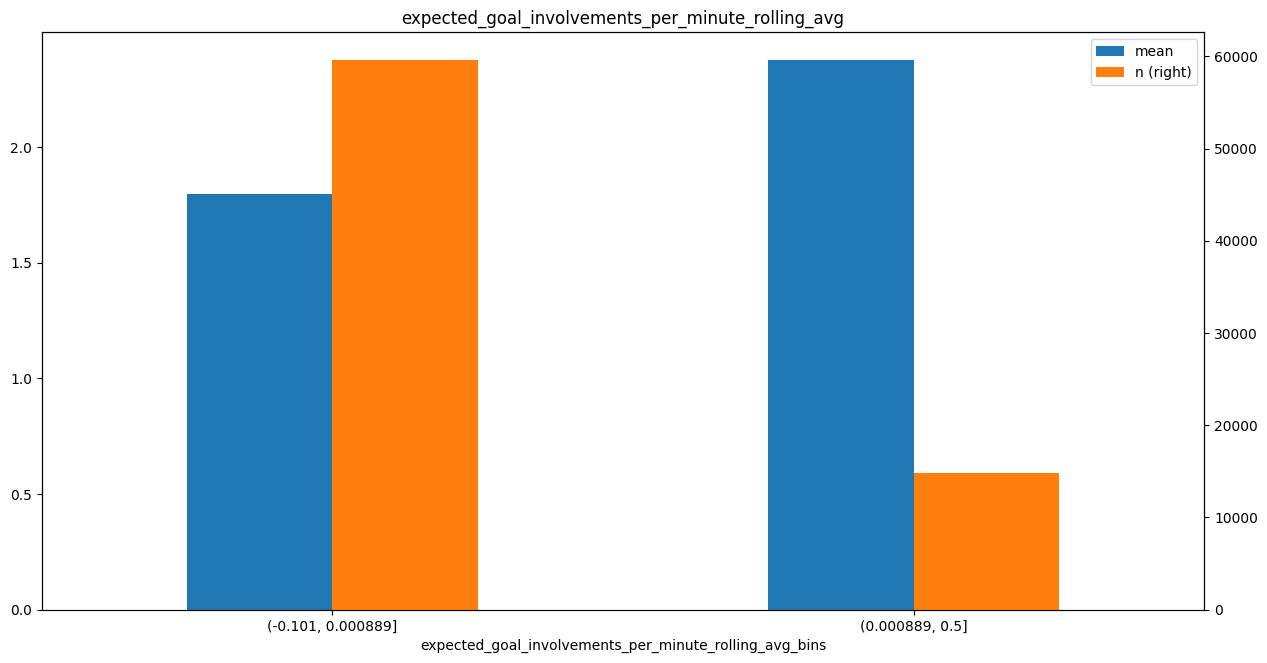

                                                  mean      n
expected_assists_per_minute_rolling_avg_bins                 
(-0.101, 0.000256]                            1.804486  59607
(0.000256, 0.5]                               2.349809  14891


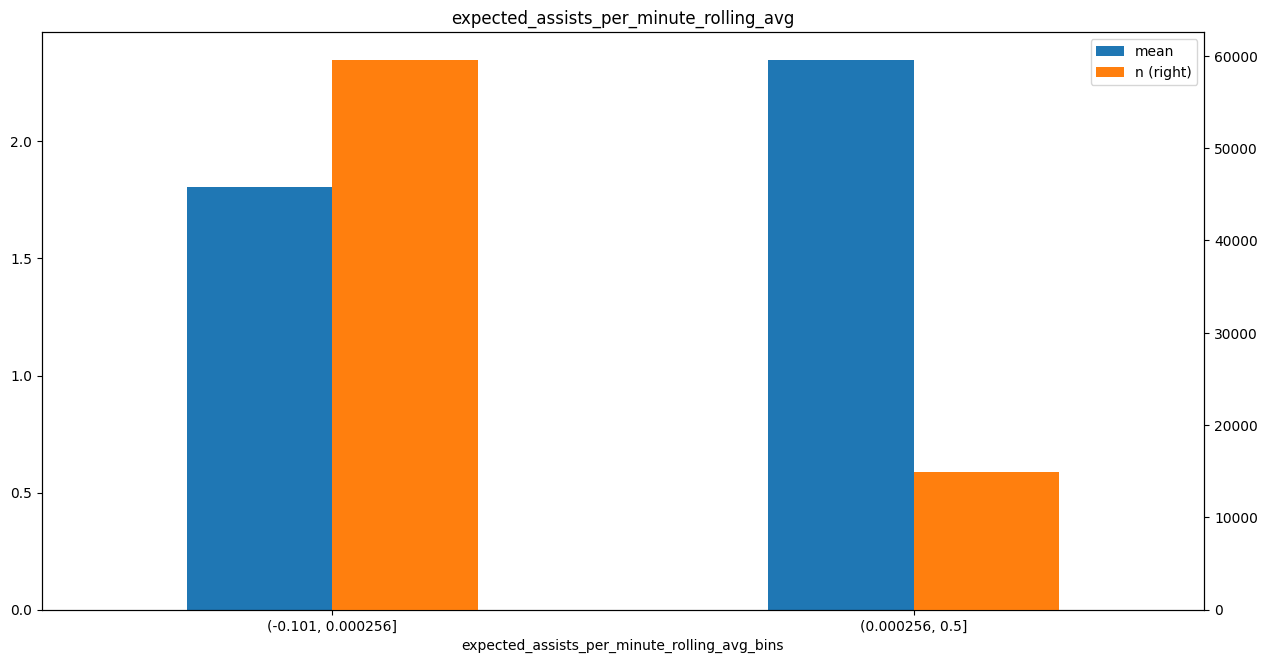

          mean     n
team                
IPS   1.427273   110
WAT   1.434889  1628
NOR   1.451327  1469
NFO   1.529880  1506
WBA   1.593407   728
LUT   1.596869   511
SHU   1.625132  1894
BOU   1.684108  2045
SOU   1.688478  3194
EVE   1.729839  3720
LEE   1.806393  2190
CHE   1.849815  4328
CRY   1.849900  3491
BUR   1.853972  2568
FUL   1.880213  2062
MUN   1.887785  4126
NEW   1.894552  3708
BHA   1.896674  3668
WOL   1.907858  3538
BRE   1.945585  2095
LEI   1.950702  3205
WHU   1.998580  3522
TOT   2.017988  3947
ARS   2.037444  4006
AVL   2.073413  3528
LIV   2.416298  3841
MCI   2.487597  3870


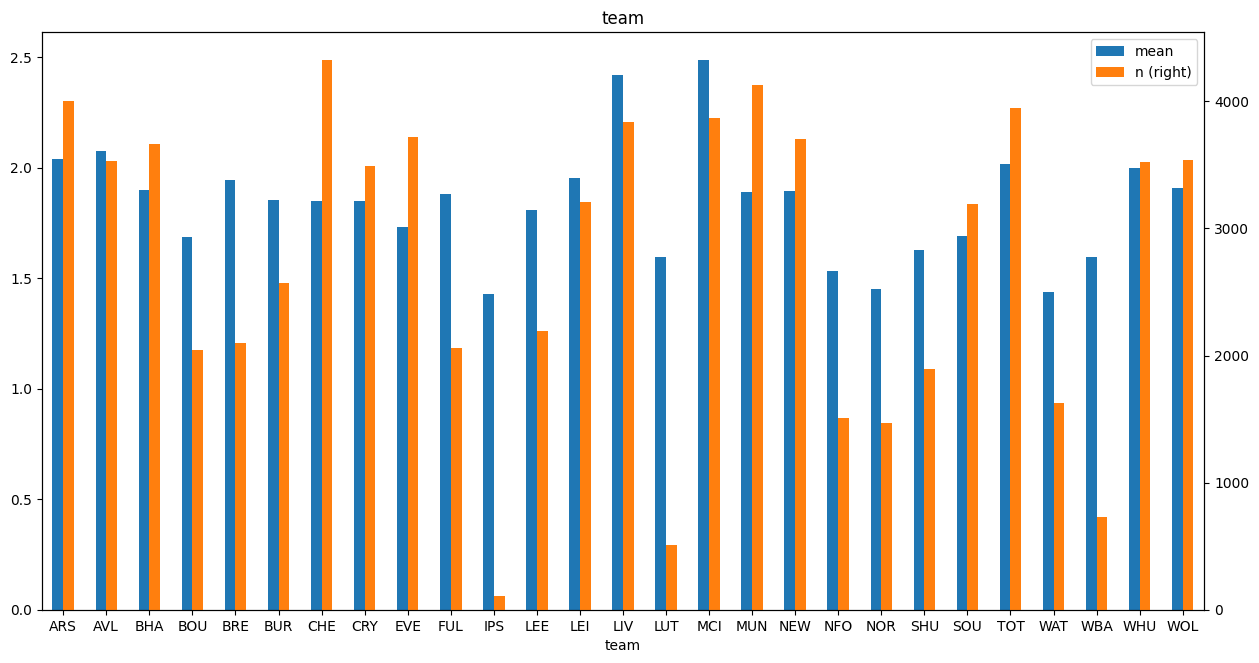

                  mean      n
yellow_cards                 
0.0           1.862128  68266
1.0           2.476091   6232


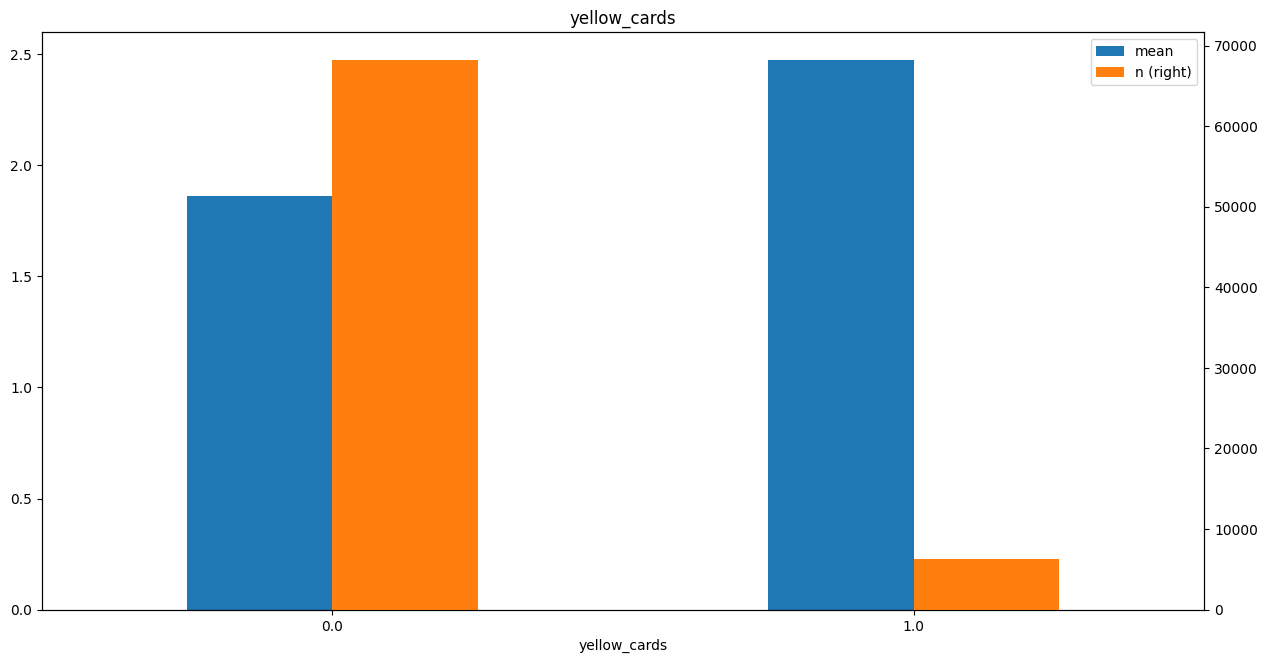

                     mean      n
player_position                 
Defender         1.798232  25336
Striker          1.839641  11362
Midfielder       1.946694  32717
Goalkeeper       2.439307   5083


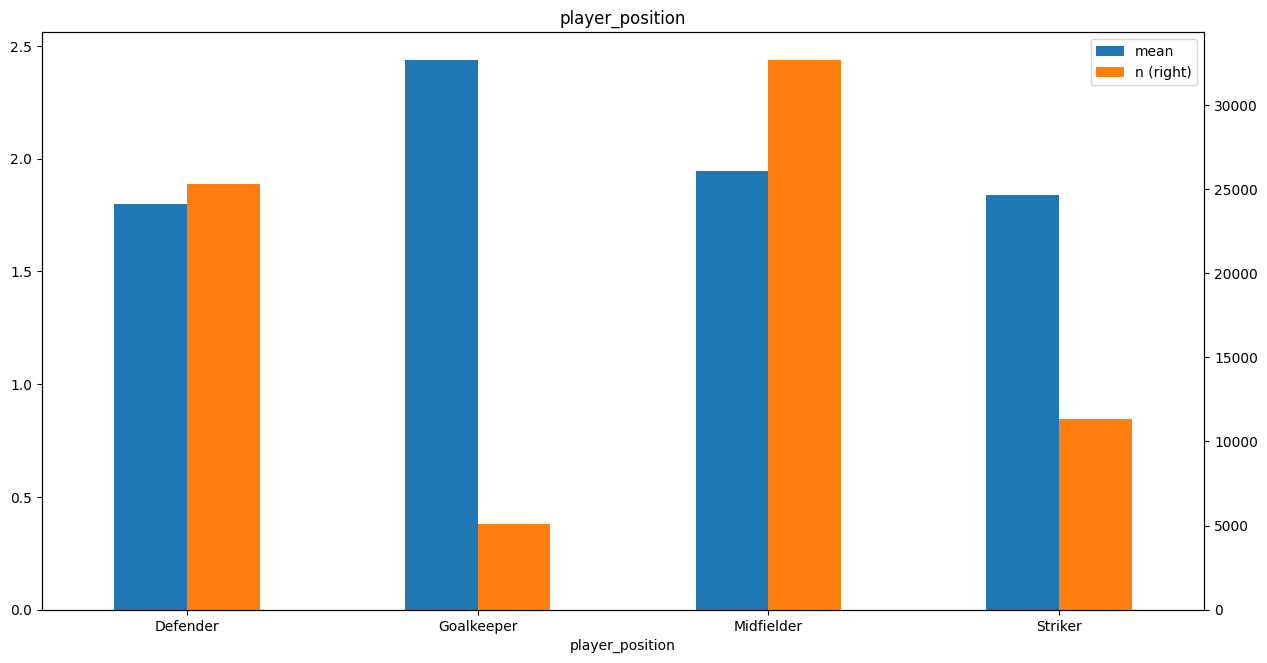

                              mean      n
yellow_cards_rolling_avg                 
0.000000                  1.758682  54998
0.333333                  2.266667    525
0.666667                  2.271739     92
0.750000                  2.286842    380
0.250000                  2.322447  14728
0.500000                  2.458404   3534
1.000000                  2.763485    241


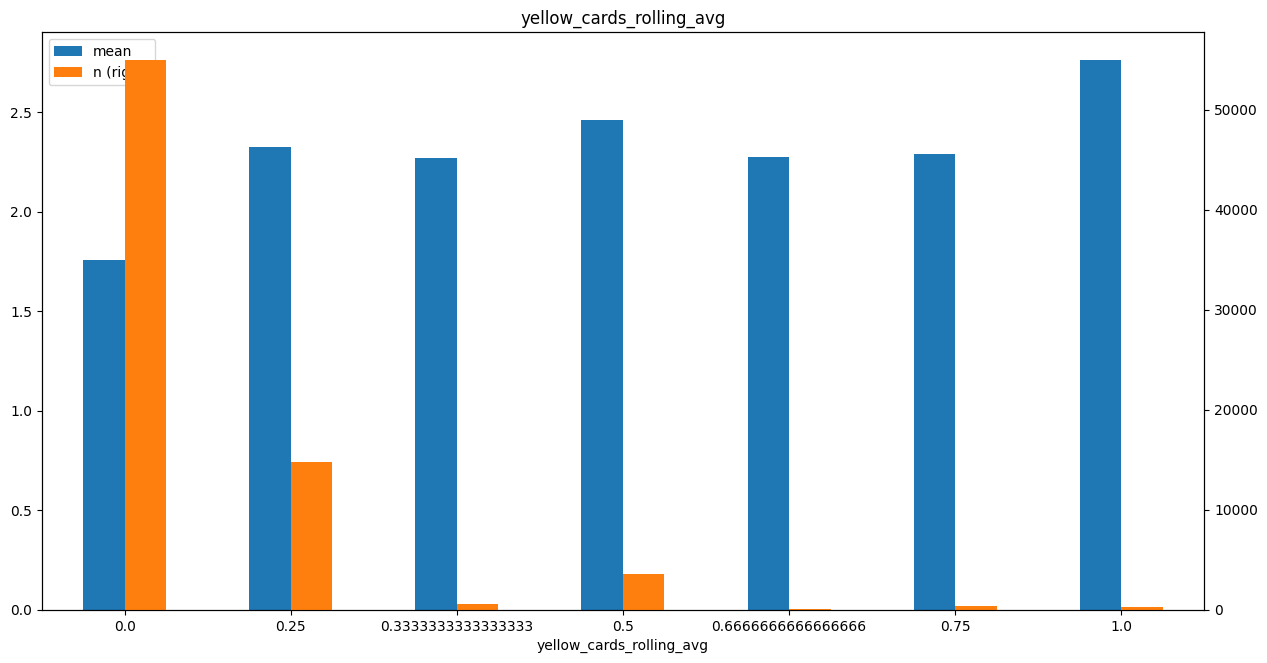

                                  mean      n
team_scored_rolling_avg_bins                 
(-0.101, 0.75]                1.768402  18666
(0.75, 1.0]                   1.833913  11783
(1.0, 1.5]                    1.856599  18640
(1.5, 2.0]                    2.043697  12747
(2.0, 5.1]                    2.154083  12662


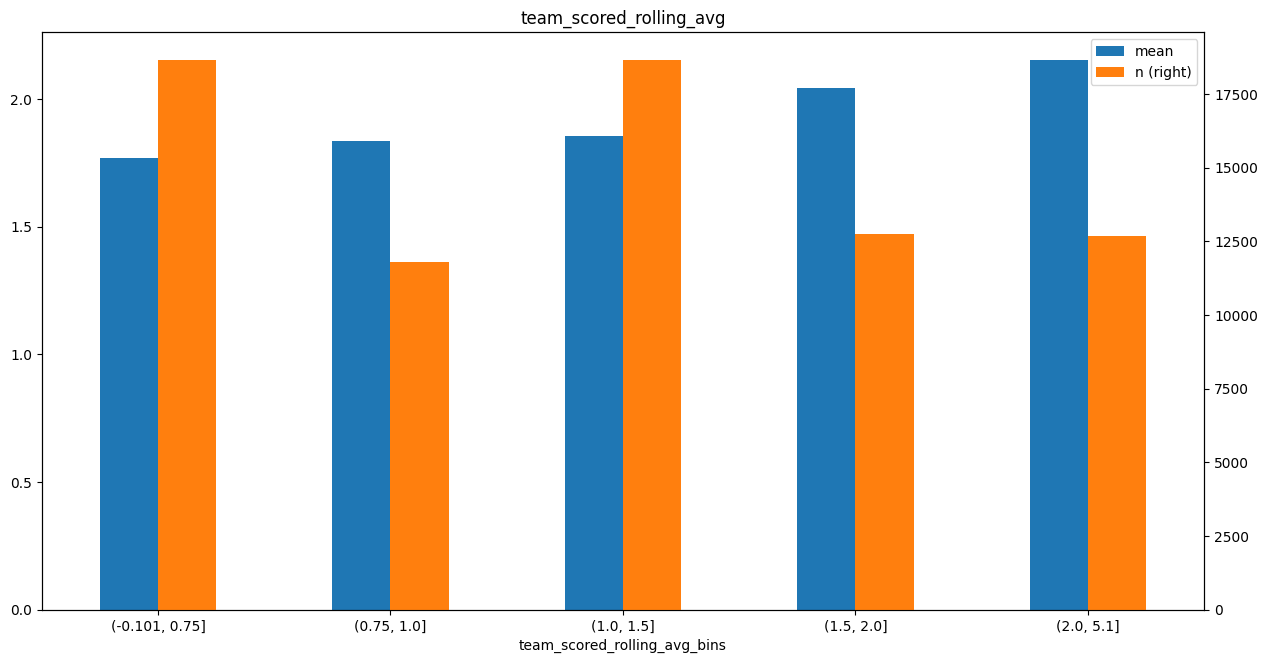

                     mean      n
win_rolling_avg                 
0.000000         1.730974  14861
0.333333         1.836279   1075
0.250000         1.846332  22464
0.500000         1.959476  20753
0.750000         2.058539  10130
1.000000         2.264597   4607
0.666667         2.345395    608


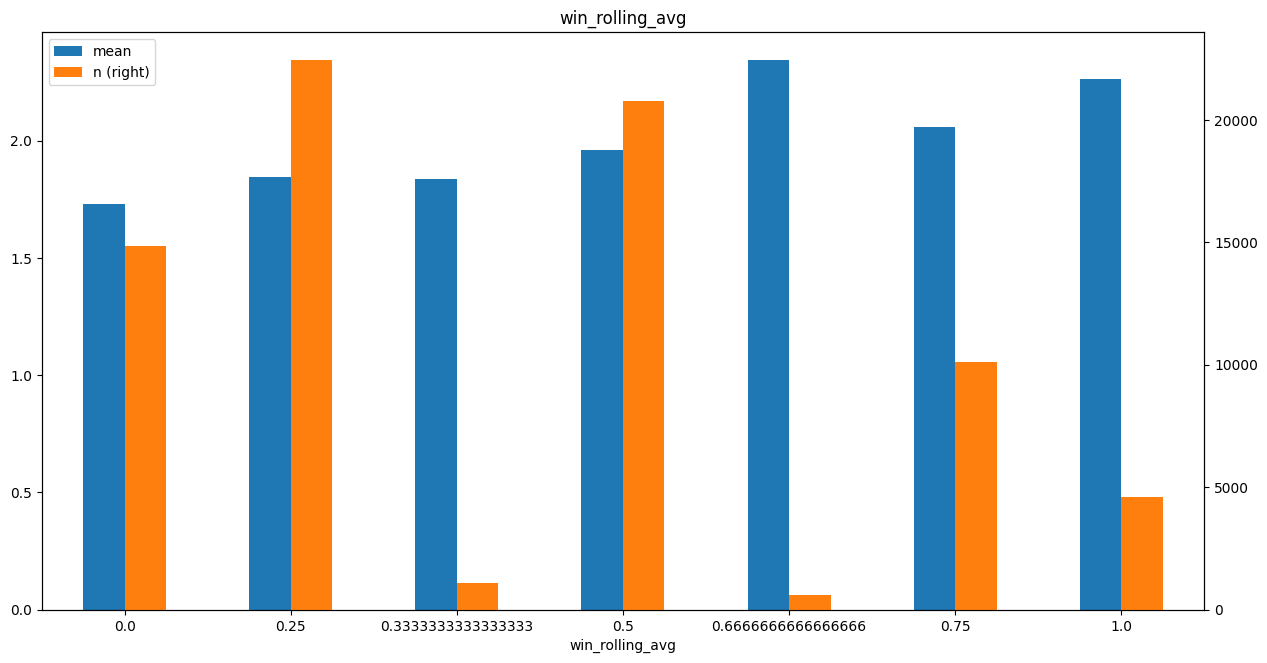

                      mean      n
loss_rolling_avg                 
1.000000          1.679980   4031
0.750000          1.707454  10706
0.666667          1.818487    595
0.500000          1.868421  21052
0.333333          1.877252    888
0.250000          1.937563  21686
0.000000          2.149163  15540


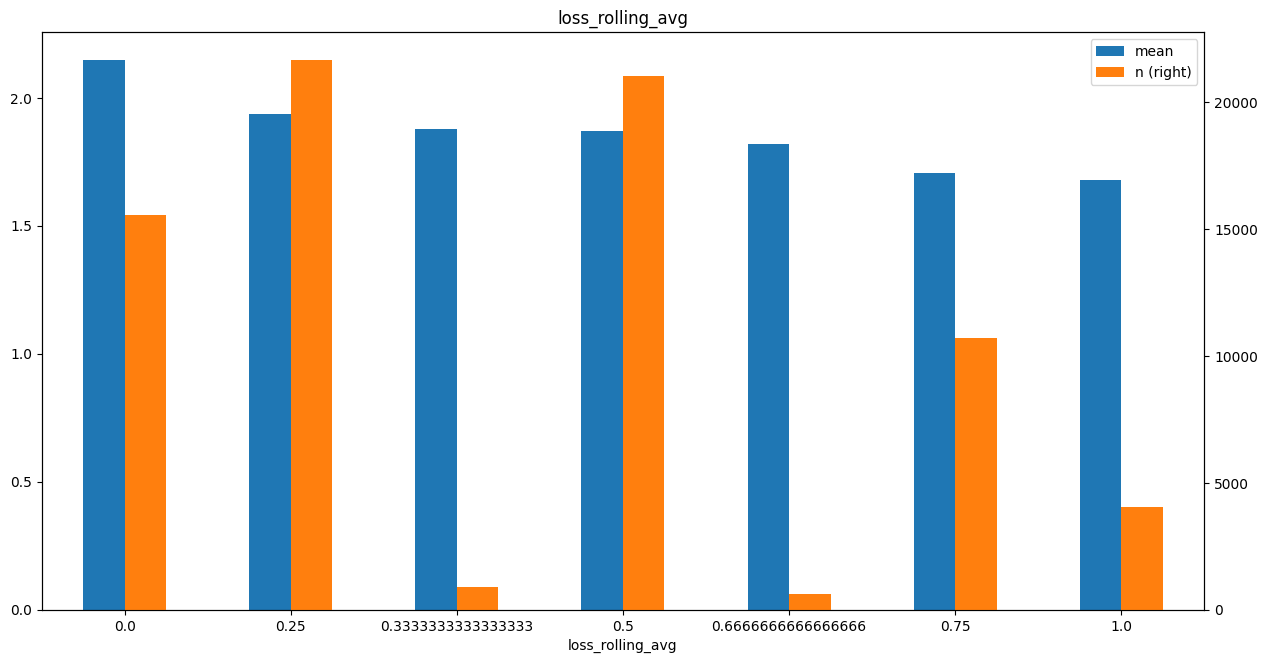

                                    mean      n
team_conceded_rolling_avg_bins                 
(-0.101, 0.75]                  2.077117  17493
(0.75, 1.25]                    1.954768  20848
(1.25, 1.5]                     1.930456  10080
(1.5, 2.0]                      1.796965  14958
(2.0, 5.1]                      1.720029  11119


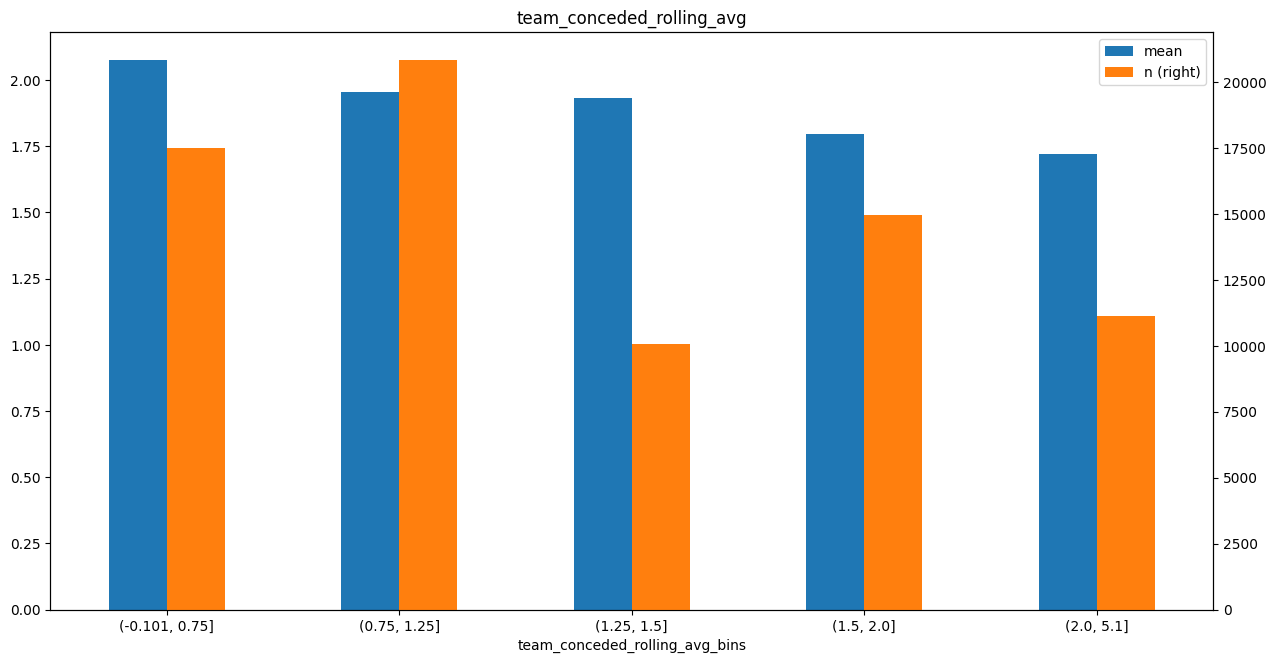

                                   mean      n
penalties_missed_rolling_avg                  
0.000000                       1.906019  74153
0.250000                       3.387500    320
0.500000                       4.083333     12
0.333333                       5.416667     12
1.000000                      16.000000      1


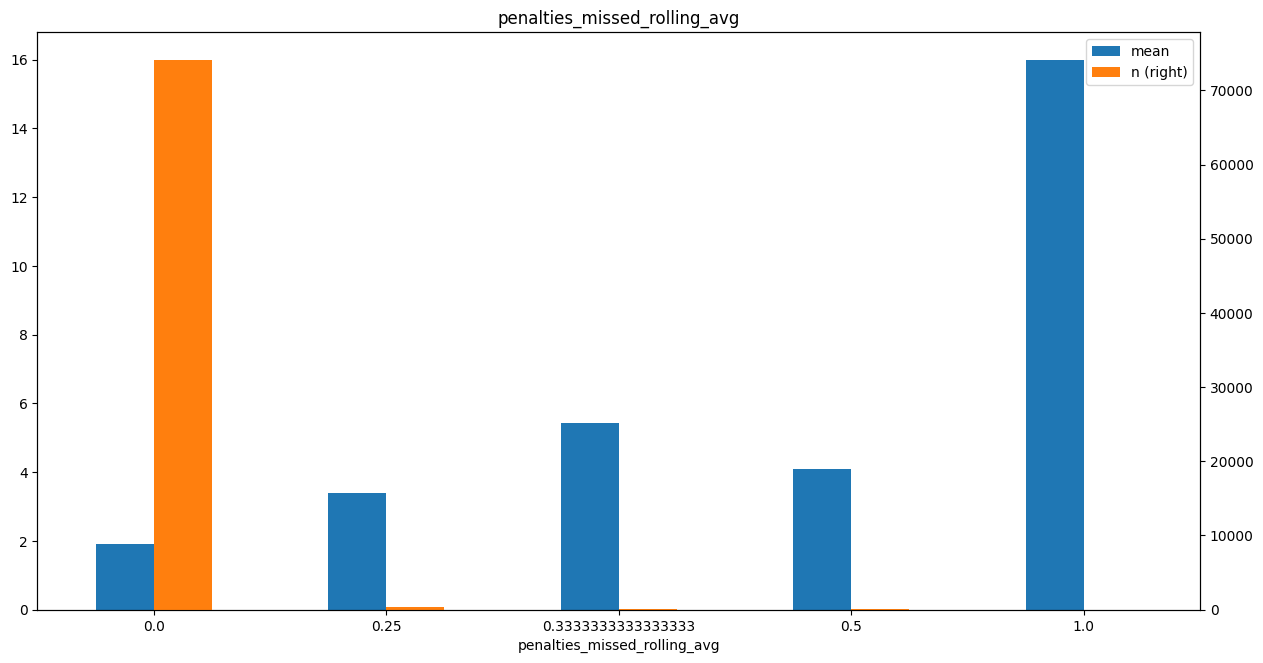

                    mean      n
next_game_home                 
0               1.807675  37239
1               2.019244  37259


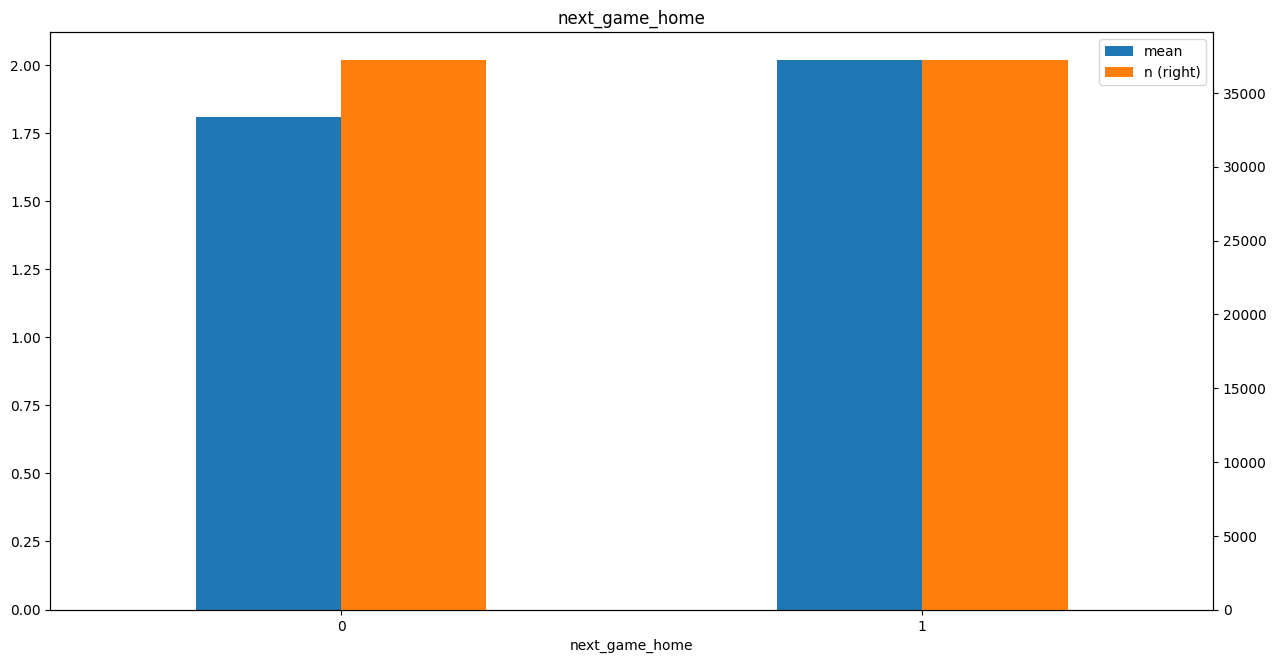

                                              mean      n
yellow_cards_per_minute_rolling_avg_bins                 
(-0.101, 0.00278]                         1.874789  61480
(0.00278, 1.1]                            2.096251  13018


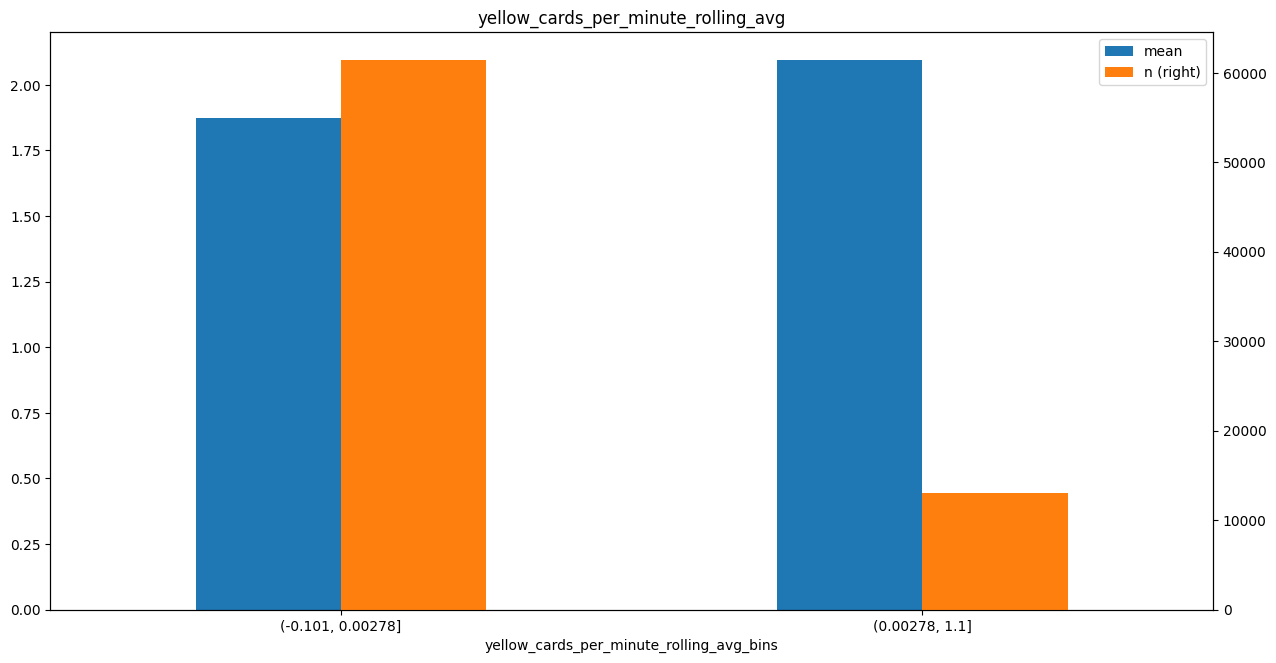

               mean      n
red_cards                 
1.0        0.377358    212
0.0        1.917871  74286


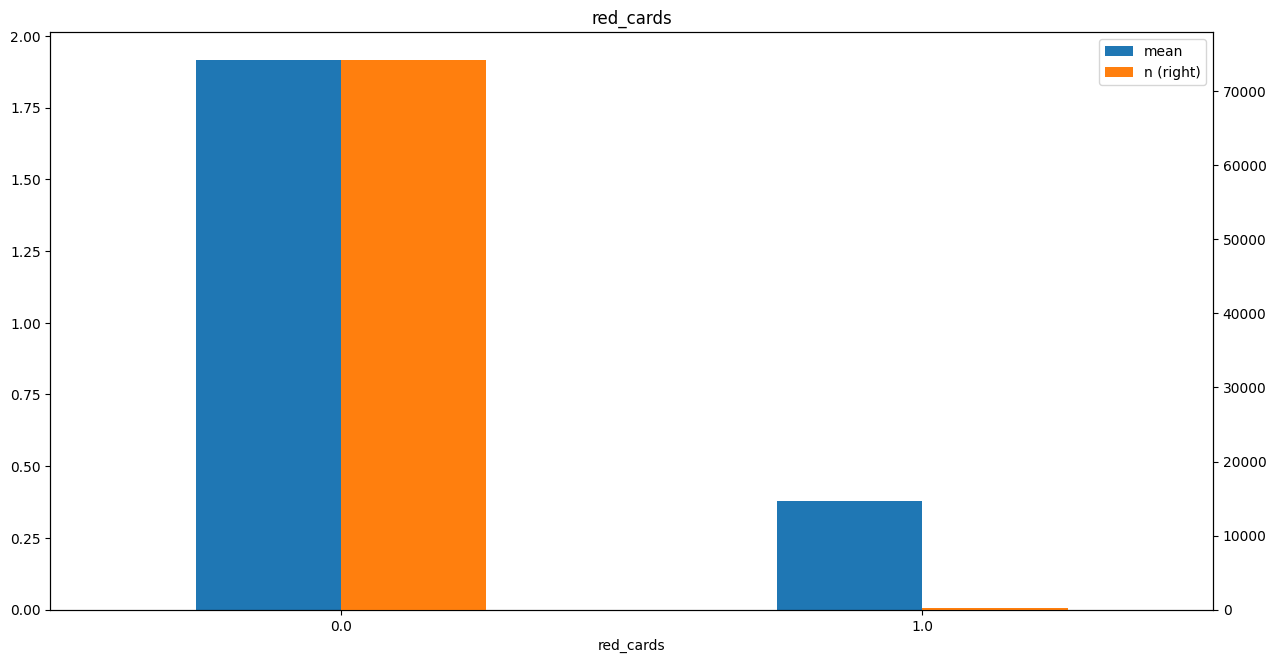

                      mean      n
penalties_missed                 
0.0               1.910825  74404
1.0               4.021277     94


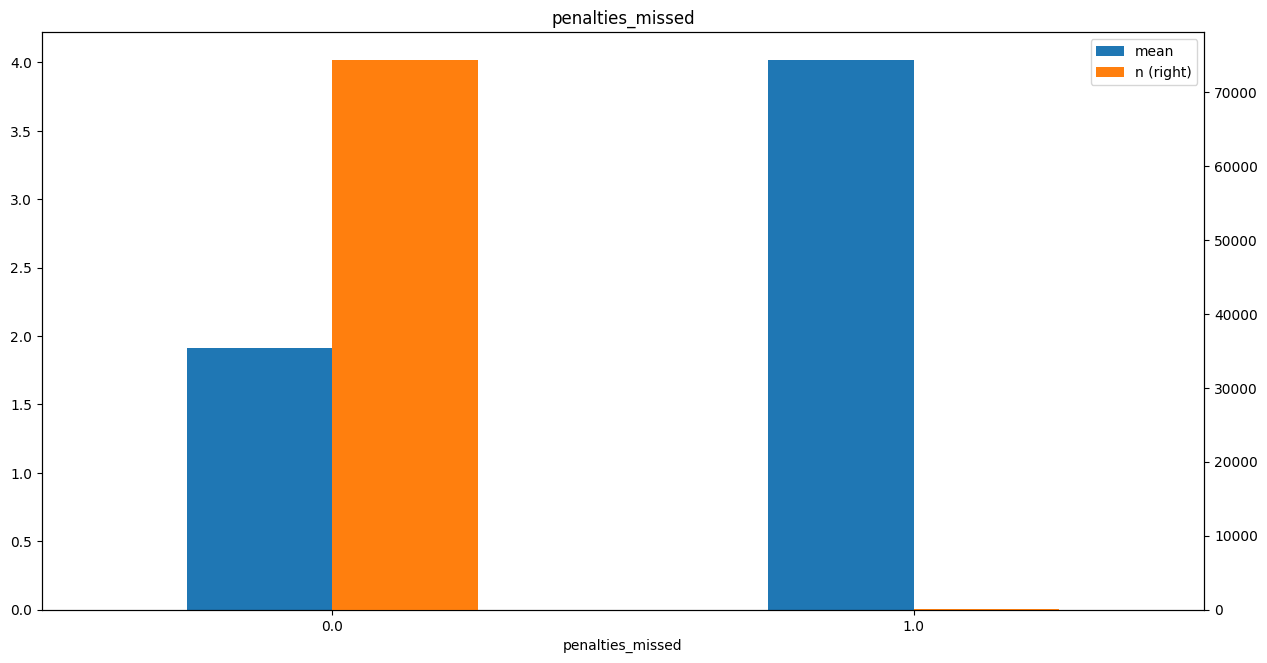

         mean      n
win                 
0    1.857099  45612
1    2.002527  28886


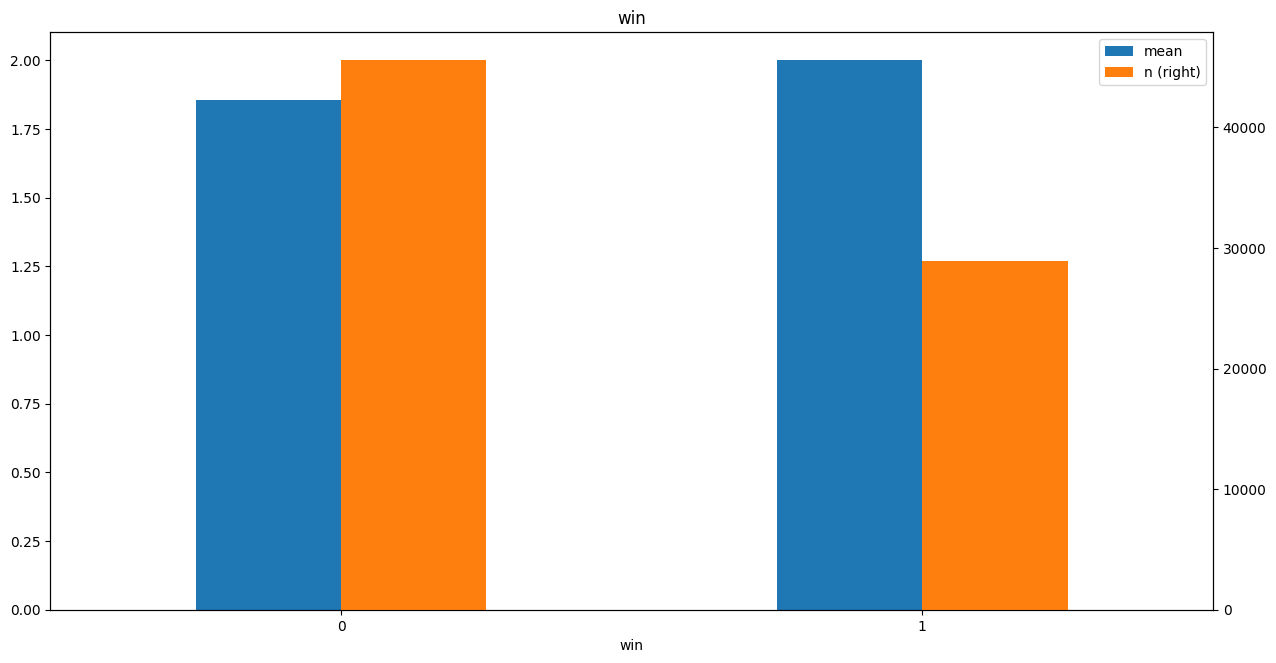

          mean      n
loss                 
1     1.824688  28492
0     1.968482  46006


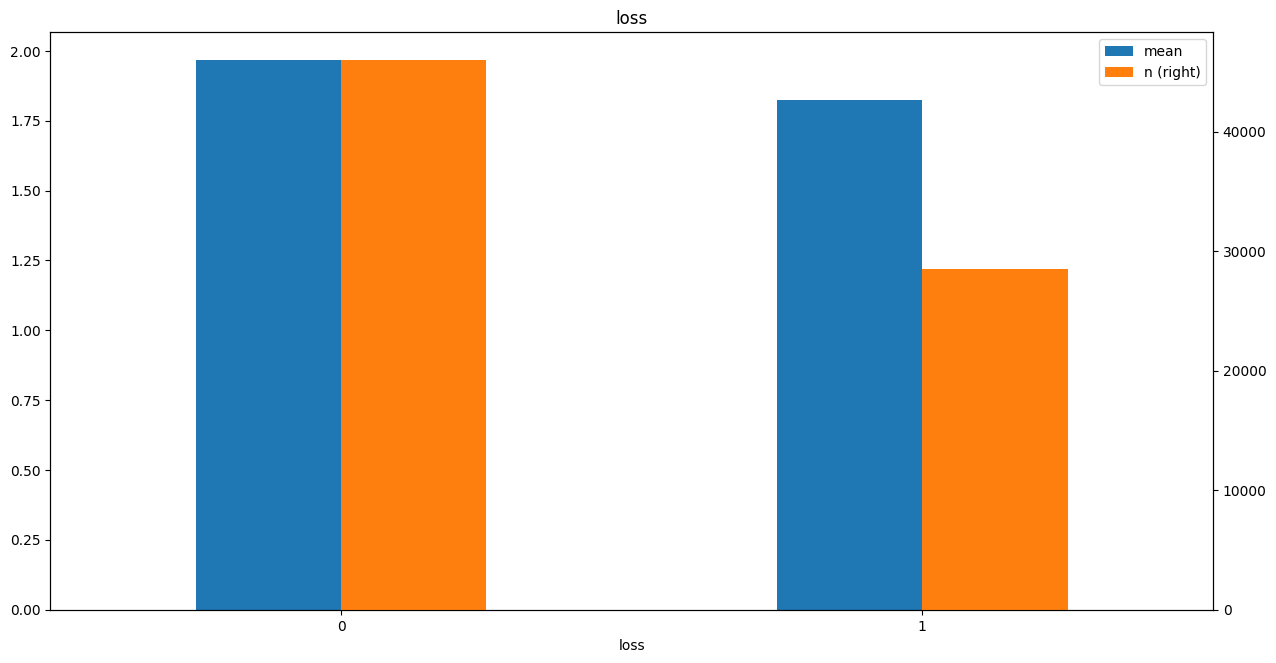

                 mean      n
team_scored                 
0.0          1.837387  19980
1.0          1.878705  24362
3.0          1.914096   8719
2.0          1.977916  16528
4.0          2.137523   3214
5.0          2.190179   1120
6.0          2.211111    360
9.0          2.606557     61
7.0          2.612613    111
8.0          2.860465     43


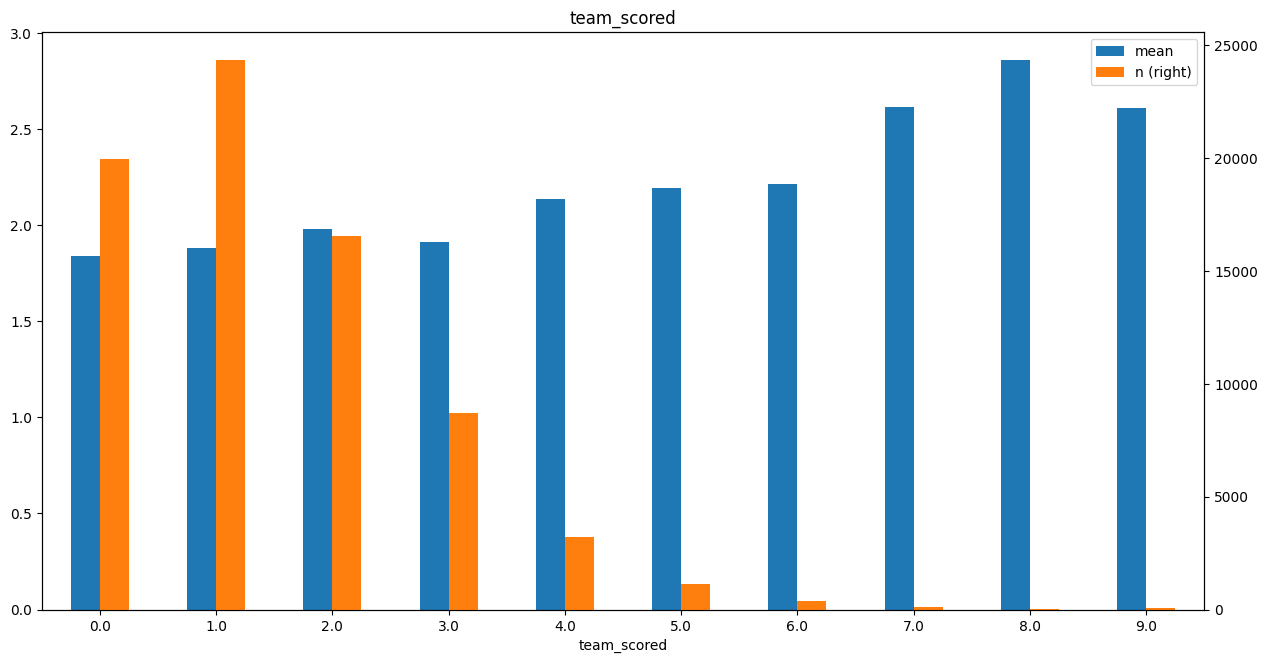

                   mean      n
team_conceded                 
8.0            0.795455     44
7.0            1.466019    103
9.0            1.661538     65
4.0            1.690430   3114
3.0            1.834109   8590
2.0            1.864141  16495
1.0            1.918731  24462
5.0            1.982569   1090
0.0            2.014957  20191
6.0            2.058140    344


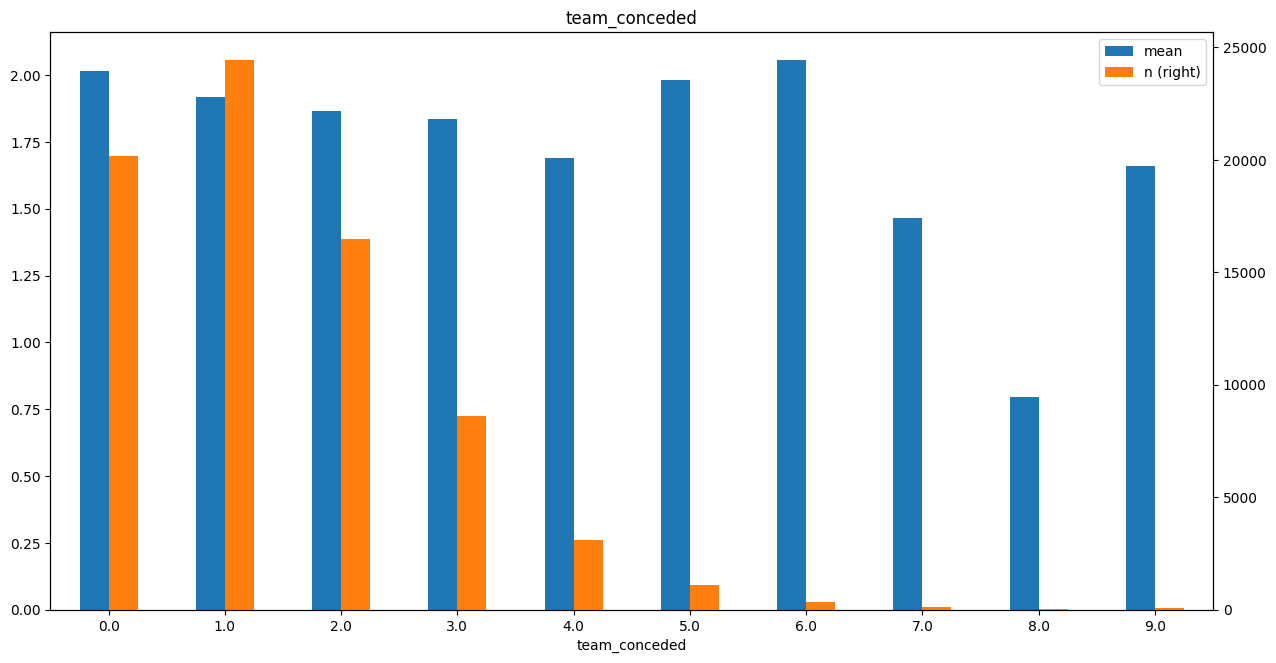

                           mean      n
red_cards_rolling_avg                 
1.000000               0.000000      4
0.500000               0.235294     17
0.333333               1.413793     29
0.250000               1.441953    758
0.000000               1.919026  73690


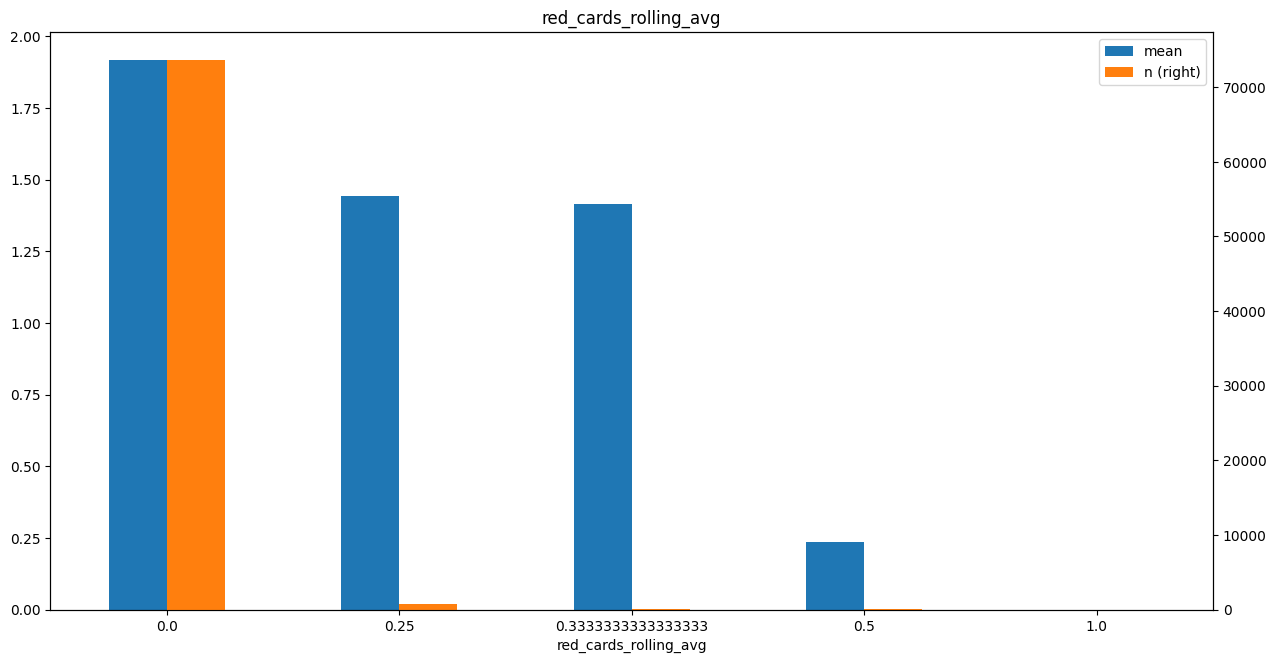

                                 mean      n
penalties_saved_rolling_avg                 
0.000000                     1.910554  74268
0.500000                     2.800000     15
0.250000                     2.848039    204
0.333333                     3.111111      9
1.000000                     3.500000      2


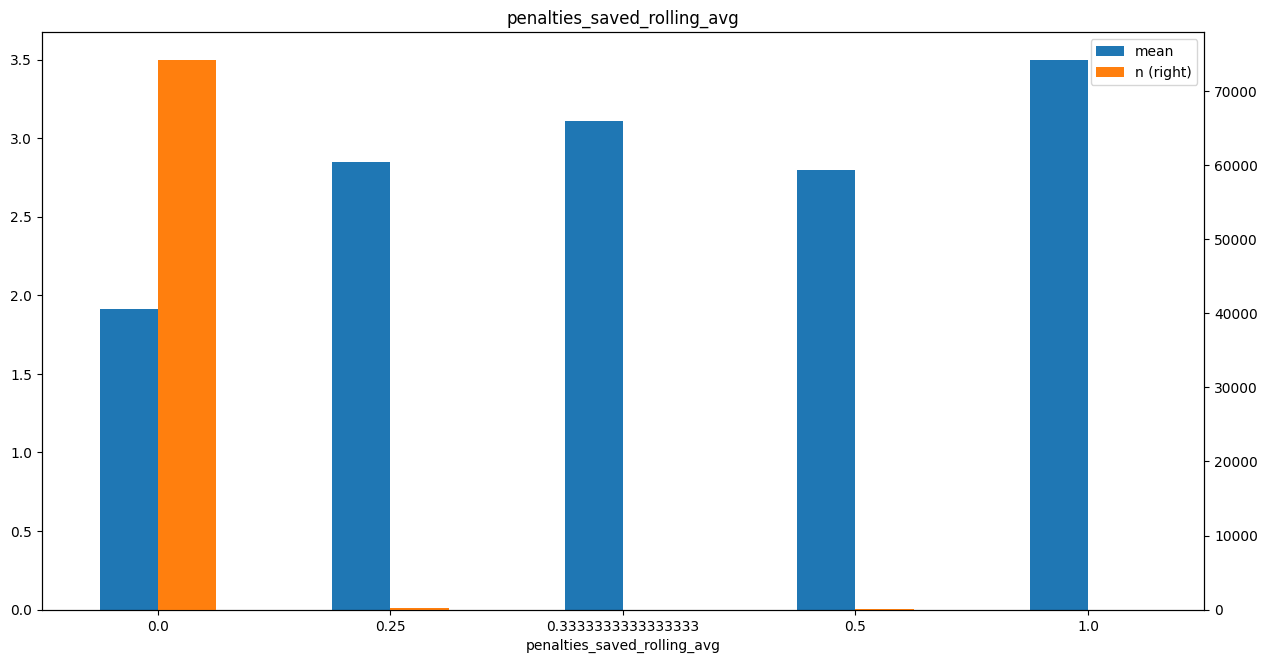

                       mean      n
season_start_year                 
24                 1.745495   2220
23                 1.840244  10347
21                 1.881357  15888
22                 1.920847  15767
19                 1.957872  15097
20                 1.969827  15179


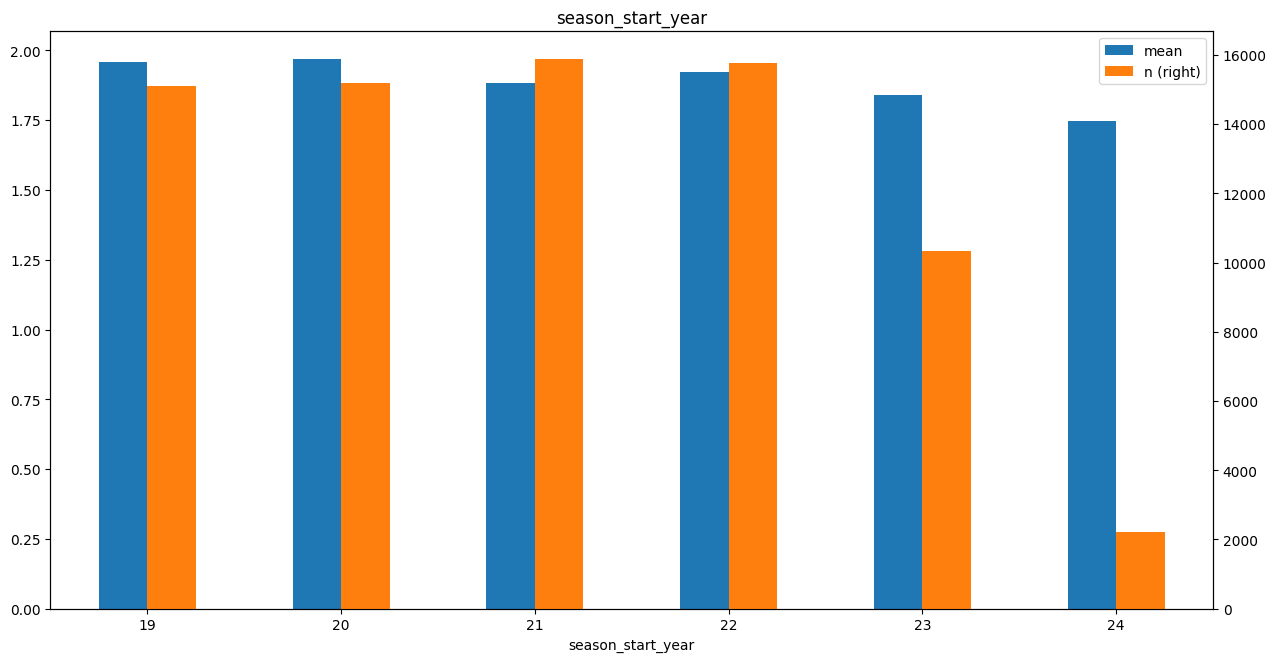

                           mean      n
own_goals_rolling_avg                 
0.333333               1.600000     20
0.000000               1.908997  73811
0.500000               2.045455     22
1.000000               2.111111      9
0.250000               2.437107    636


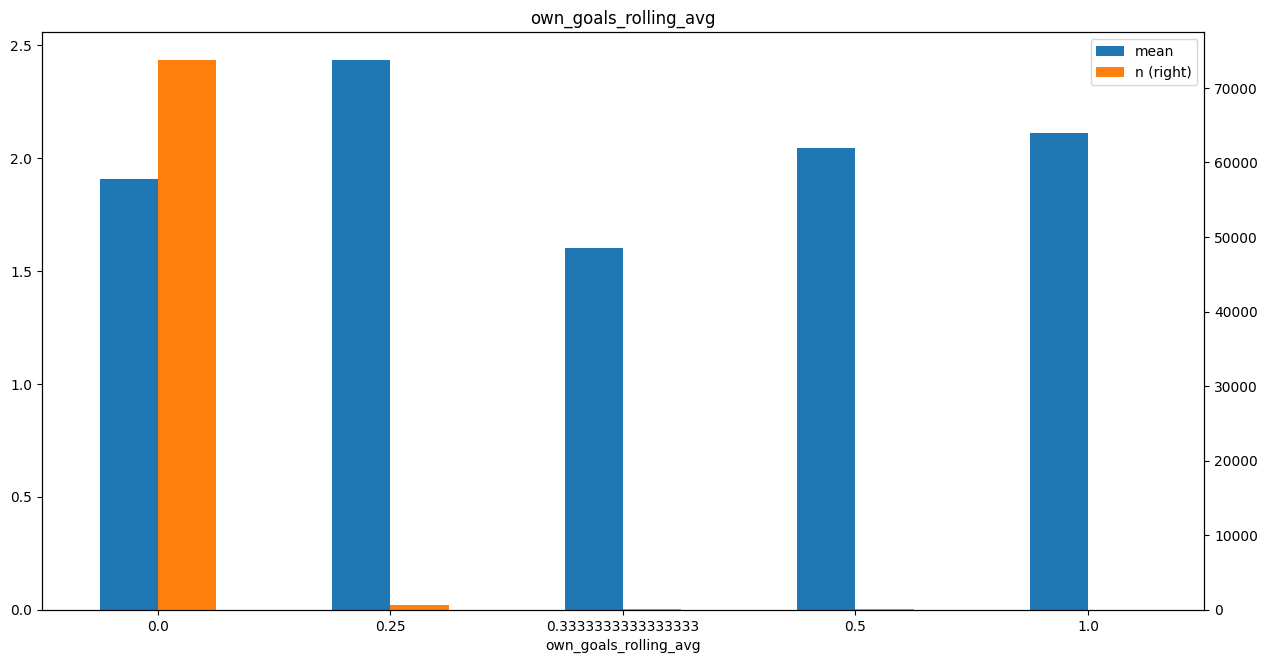

               mean      n
own_goals                 
0.0        1.911449  74319
2.0        2.000000      1
1.0        2.764045    178


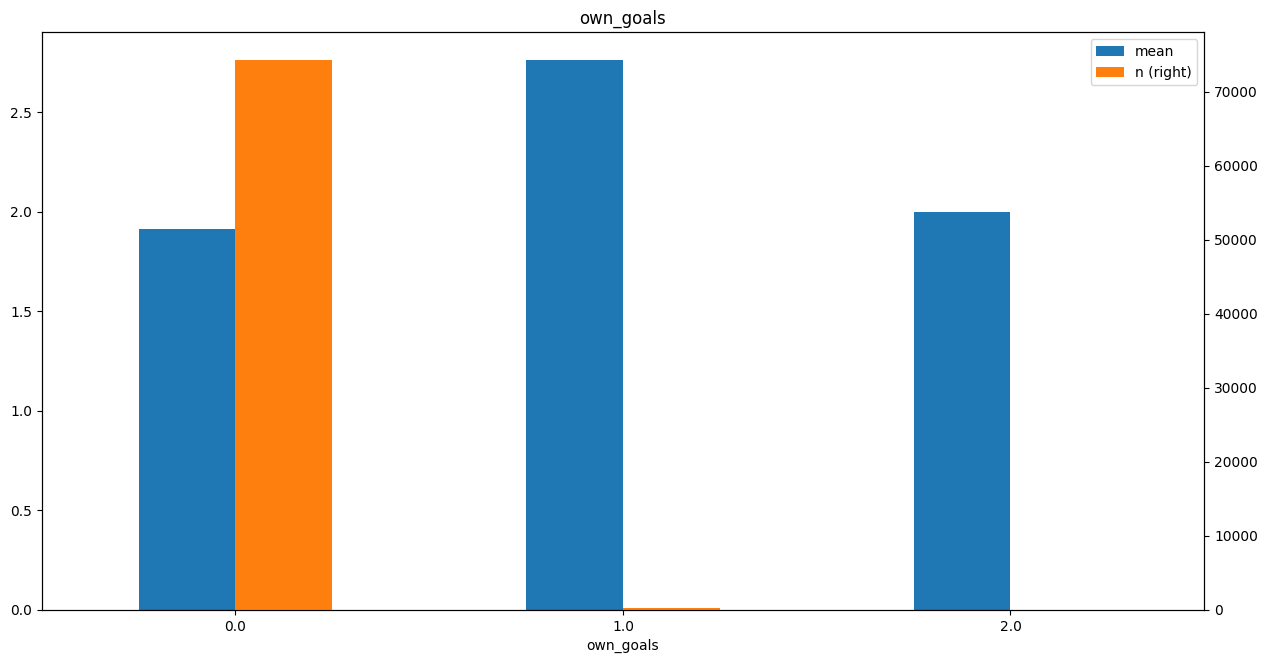

                                  mean      n
yellow_cards_per_minute_bins                 
(-0.101, 0.1]                 1.914964  74392
(0.1, 1.1]                    0.877358    106


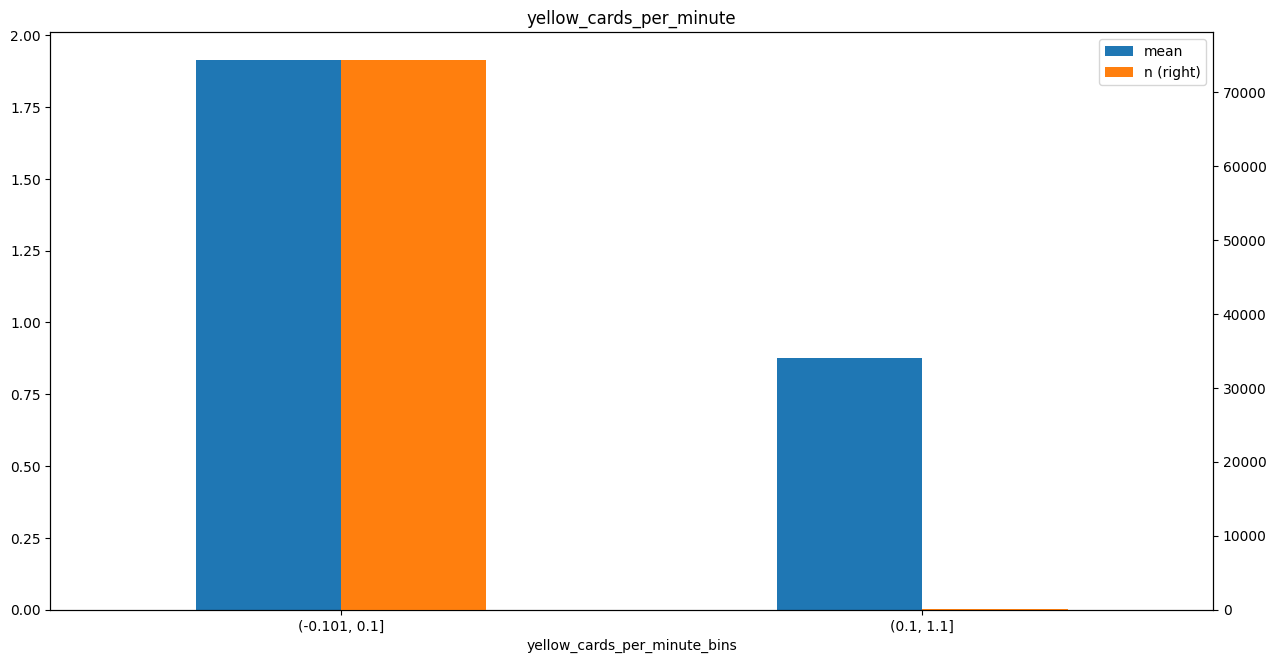

                     mean      n
penalties_saved                 
0.0              1.912393  74435
2.0              2.000000      1
1.0              3.225806     62


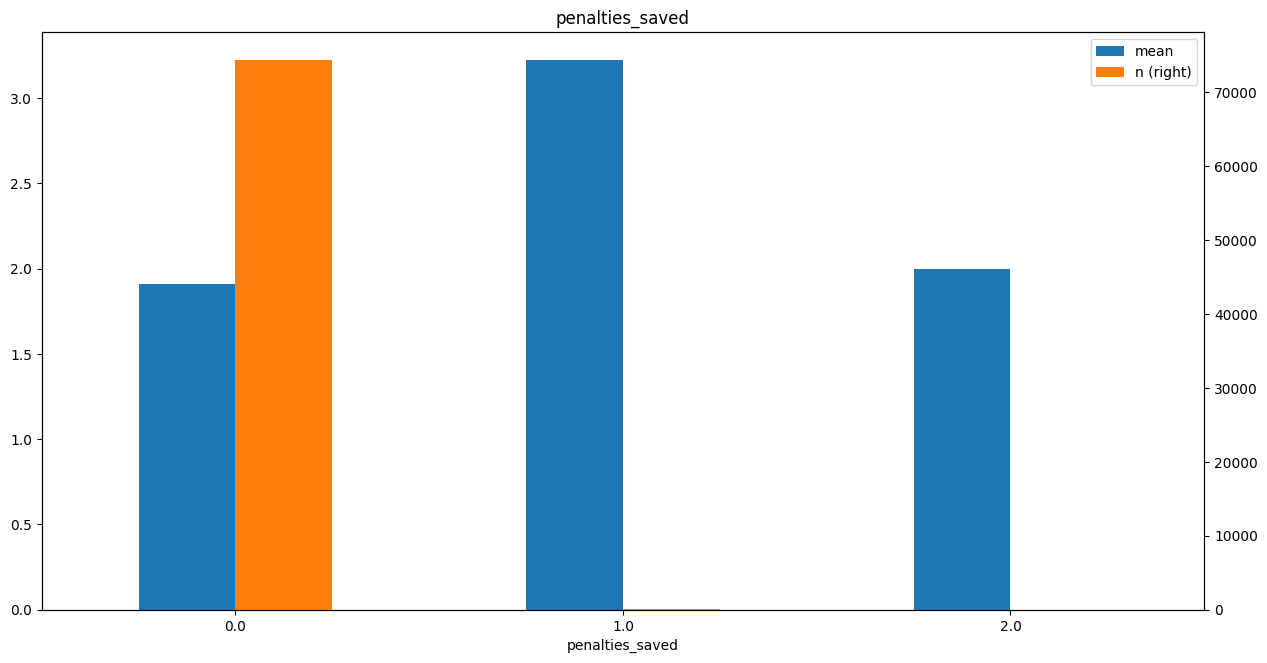

                                mean      n
penalties_saved_per_minute                 
0.000000                    1.912393  74435
0.022222                    2.000000      1
0.011111                    3.225806     62


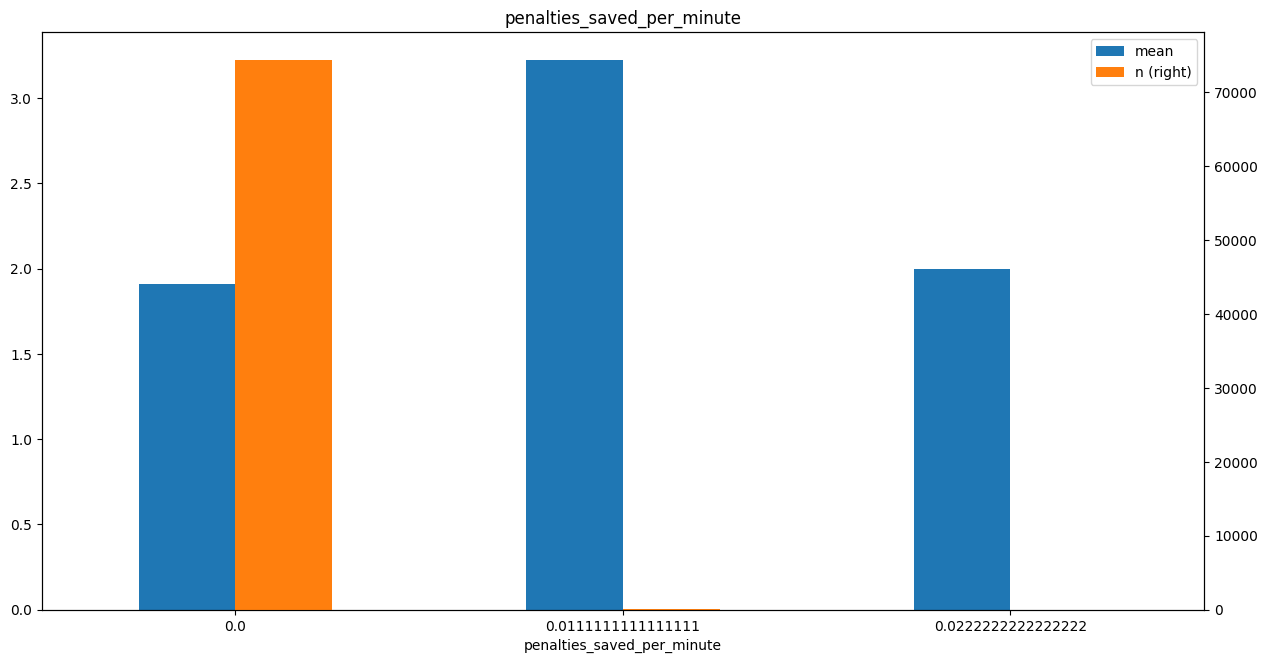

                                         mean      n
assists_per_minute_rolling_avg_bins                 
(-0.101, 0.1]                        1.914725  74406
(0.1, 1.1]                           0.913043     92


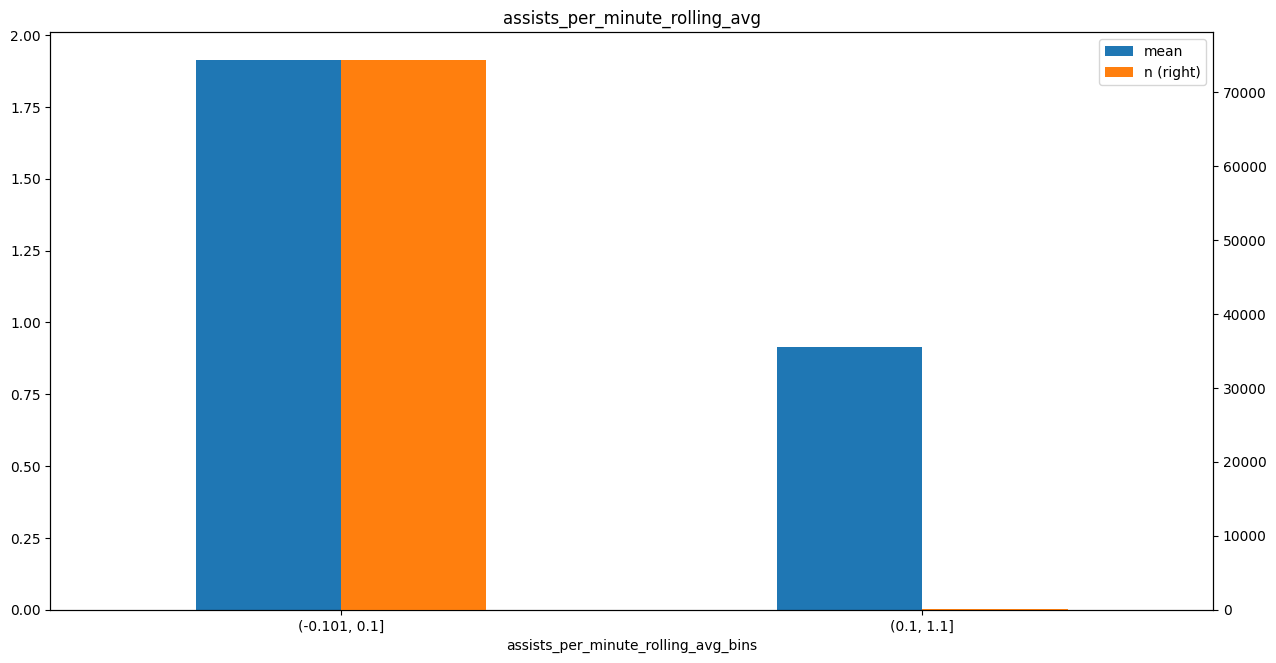

          mean      n
home                 
1     1.880098  37222
0     1.946829  37276


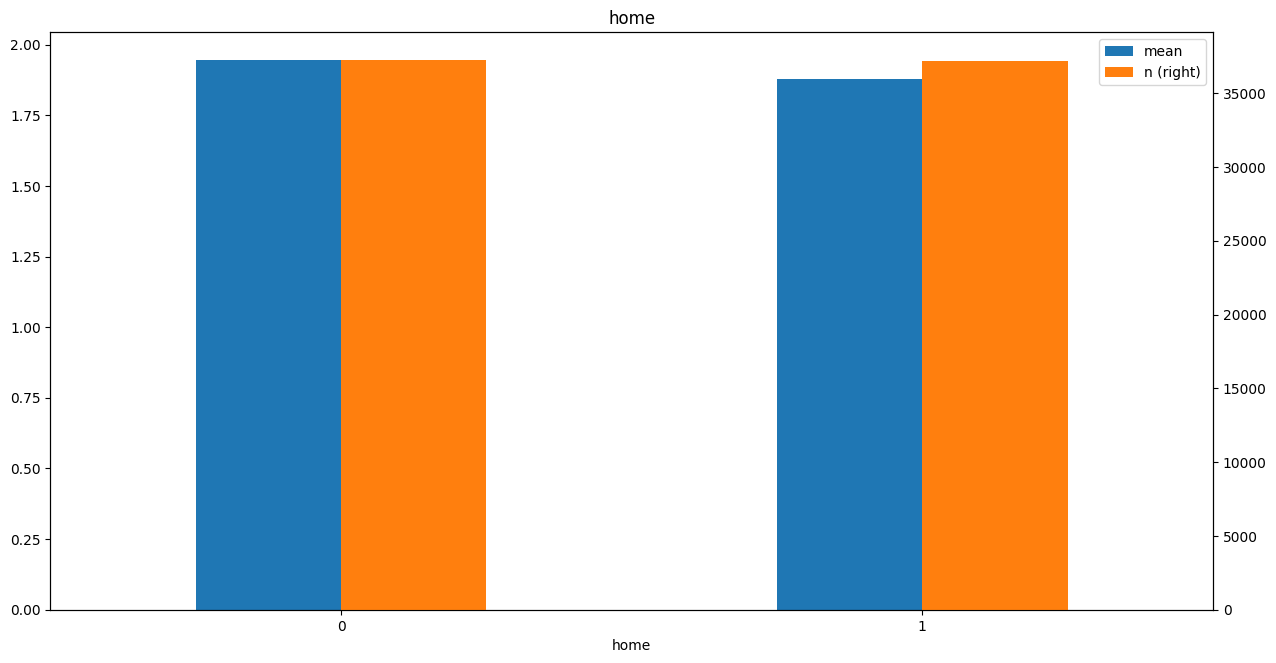

              mean     n
opponent                
LEI       1.786792  3180
AVL       1.787440  3726
CRY       1.799733  3745
MCI       1.823672  3709
LUT       1.825558   493
NFO       1.851746  1403
SHU       1.871858  2029
CHE       1.886194  3752
BOU       1.889505  2163
ARS       1.893554  3692
BHA       1.895615  3717
BRE       1.908159  2243
MUN       1.910208  3742
EVE       1.912417  3745
IPS       1.921739   115
LEE       1.933673  2352
FUL       1.957261  2176
SOU       1.958059  3195
NOR       1.961514  1559
WHU       1.966093  3716
TOT       1.969443  3698
WOL       1.973642  3756
LIV       1.980233  3693
NEW       1.987714  3744
WAT       2.007767  1545
BUR       2.048489  2846
WBA       2.077225   764


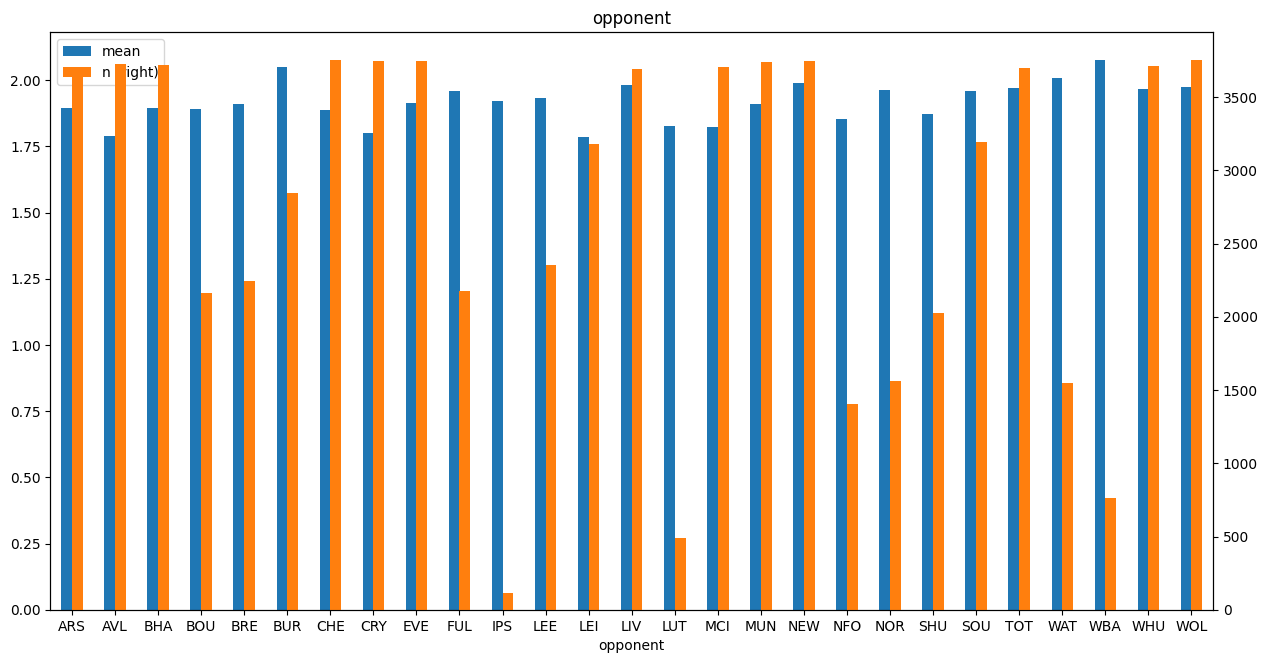

                                              mean      n
goals_scored_per_minute_rolling_avg_bins                 
(-0.101, 0.1]                             1.914243  74431
(0.1, 1.1]                                1.074627     67


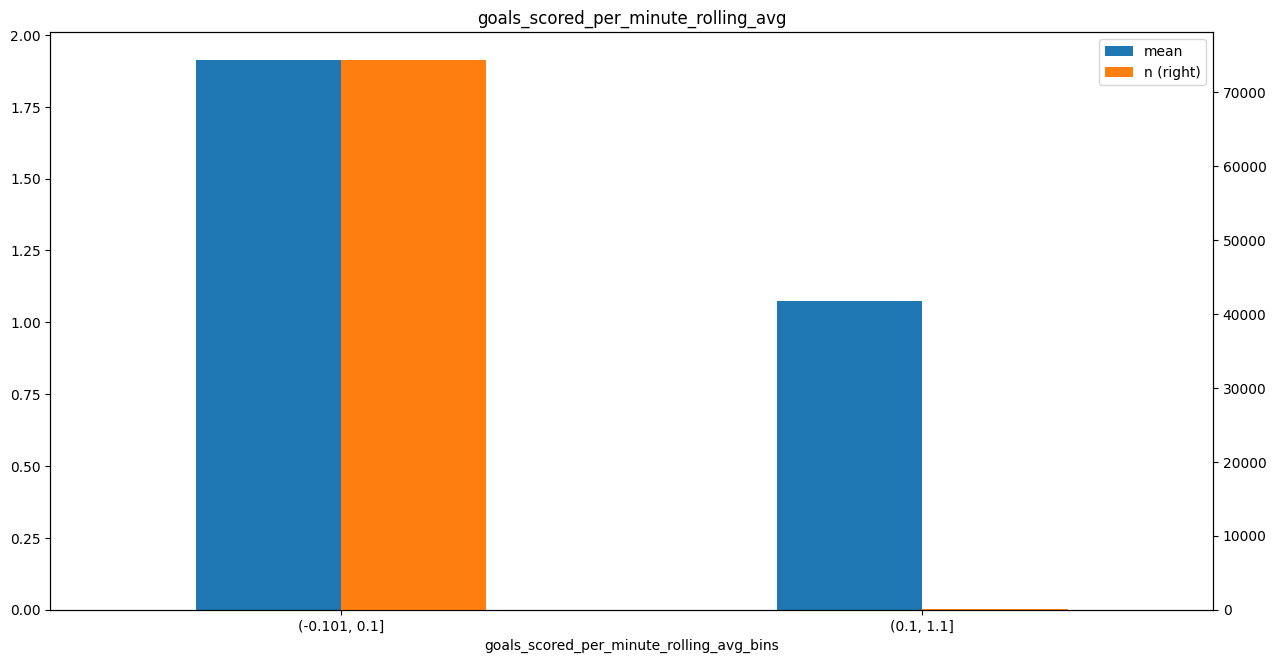

                             mean      n
assists_per_minute_bins                 
(-0.101, 0.1]            1.914218  74433
(0.1, 1.1]               1.076923     65


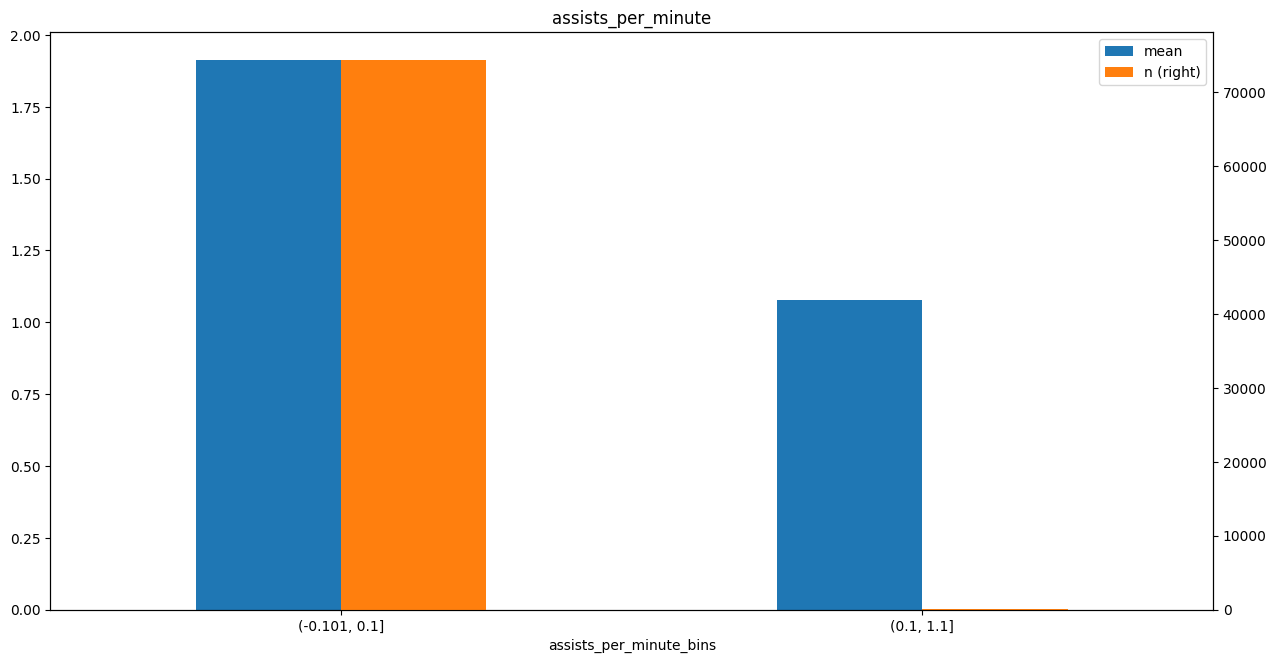

                                           mean      n
red_cards_per_minute_rolling_avg_bins                 
(-0.101, 0.1]                          1.913845  74482
(0.1, 1.1]                             0.250000     16


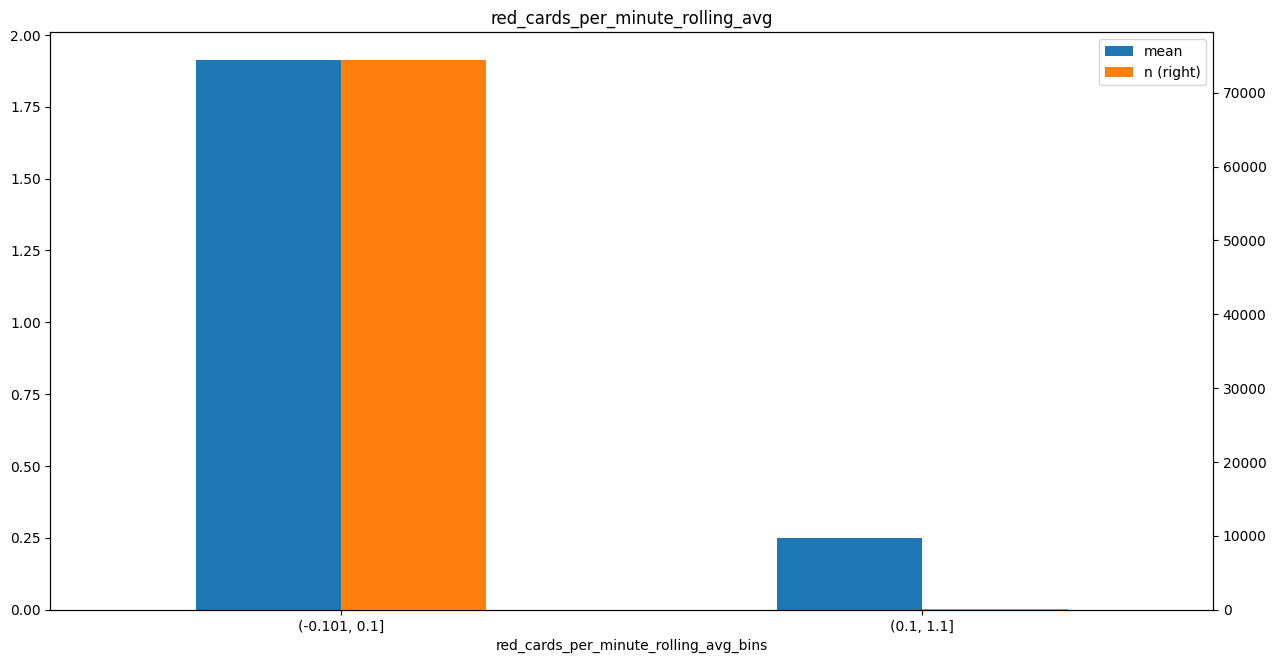

                                                        mean      n
expected_goals_conceded_per_minute_rolling_avg_...                 
(-0.101, 0.0144]                                    1.901882  59602
(0.0144, 1.53]                                      1.959922  14896


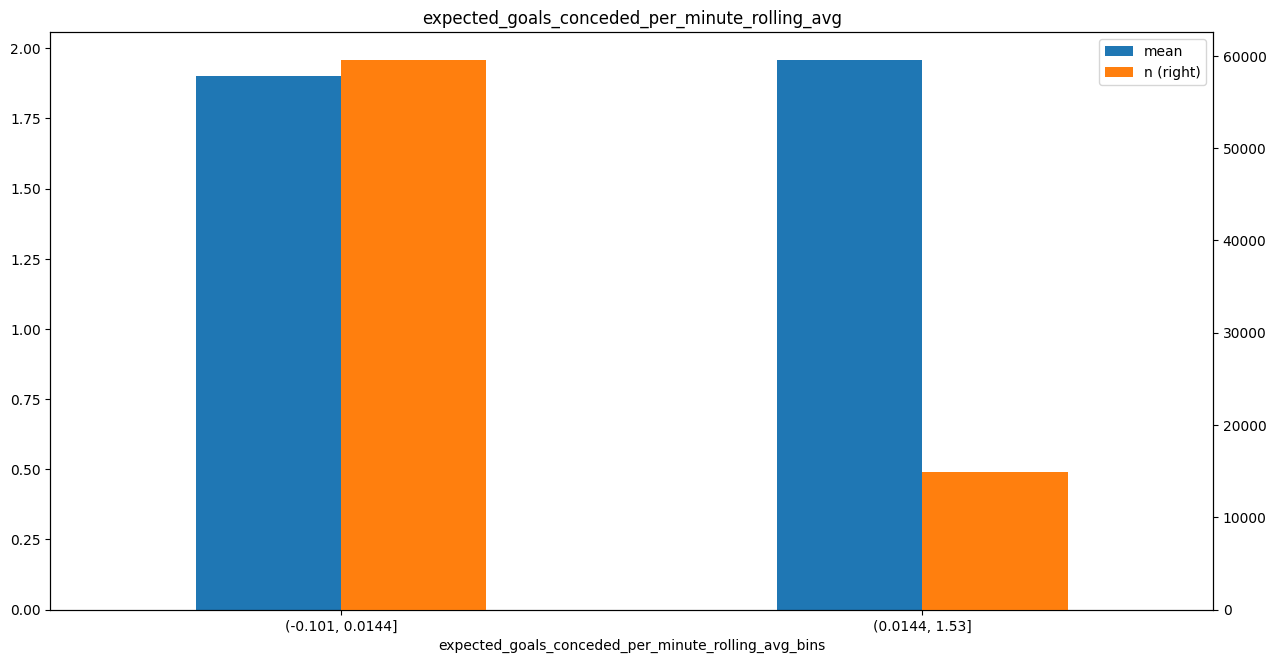

                      mean      n
home_rolling_avg                 
1.000000          1.809778   1309
0.666667          1.838576   1208
0.750000          1.876114   9759
0.500000          1.891816  49804
0.250000          2.028374   9833
0.333333          2.062943   1271
0.000000          2.180365   1314


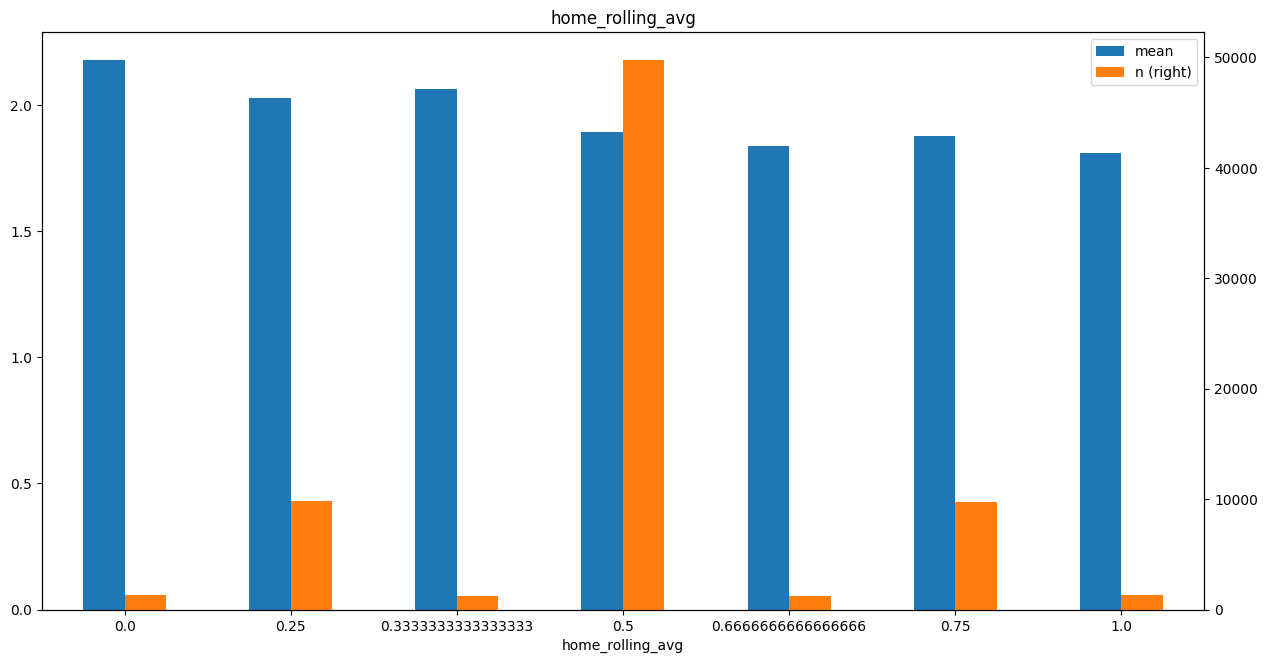

                                       mean      n
saves_per_minute_rolling_avg_bins                 
(-0.101, 0.1]                      1.913731  74488
(0.1, 0.267]                       0.100000     10


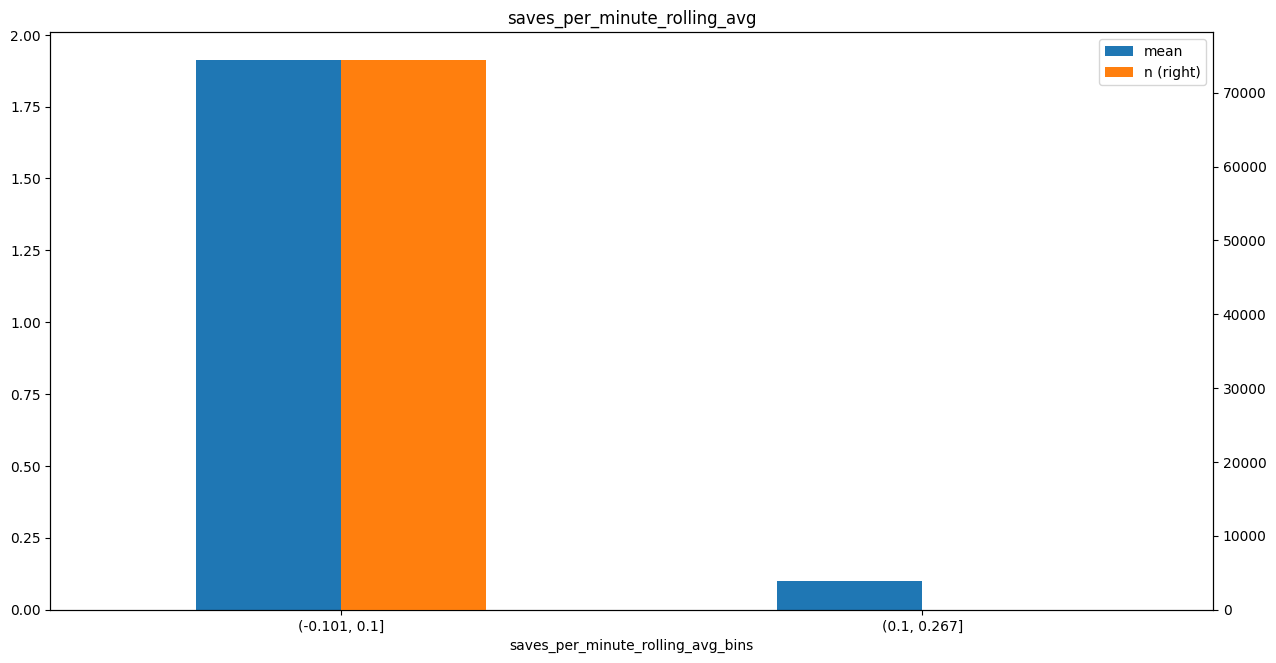

                               mean      n
red_cards_per_minute_bins                 
(-0.101, 0.1]              1.913731  74488
(0.1, 1.1]                 0.100000     10


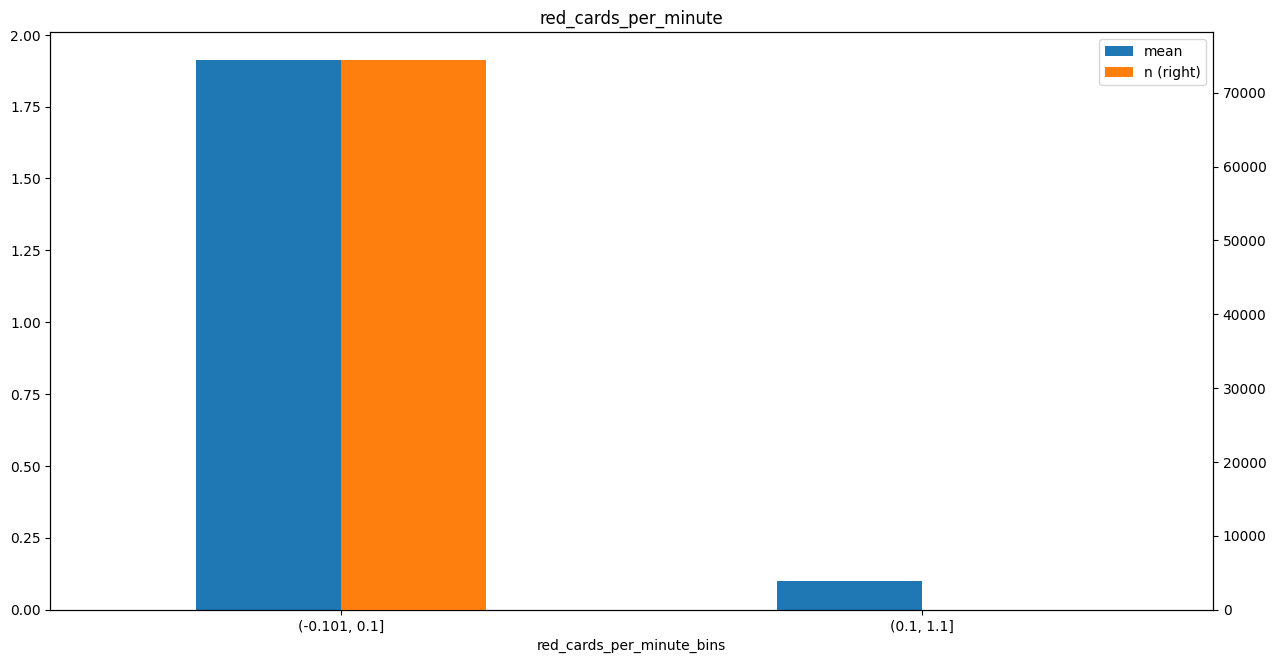

                                  mean      n
goals_scored_per_minute_bins                 
(-0.101, 0.1]                 1.914004  74434
(0.1, 1.1]                    1.312500     64


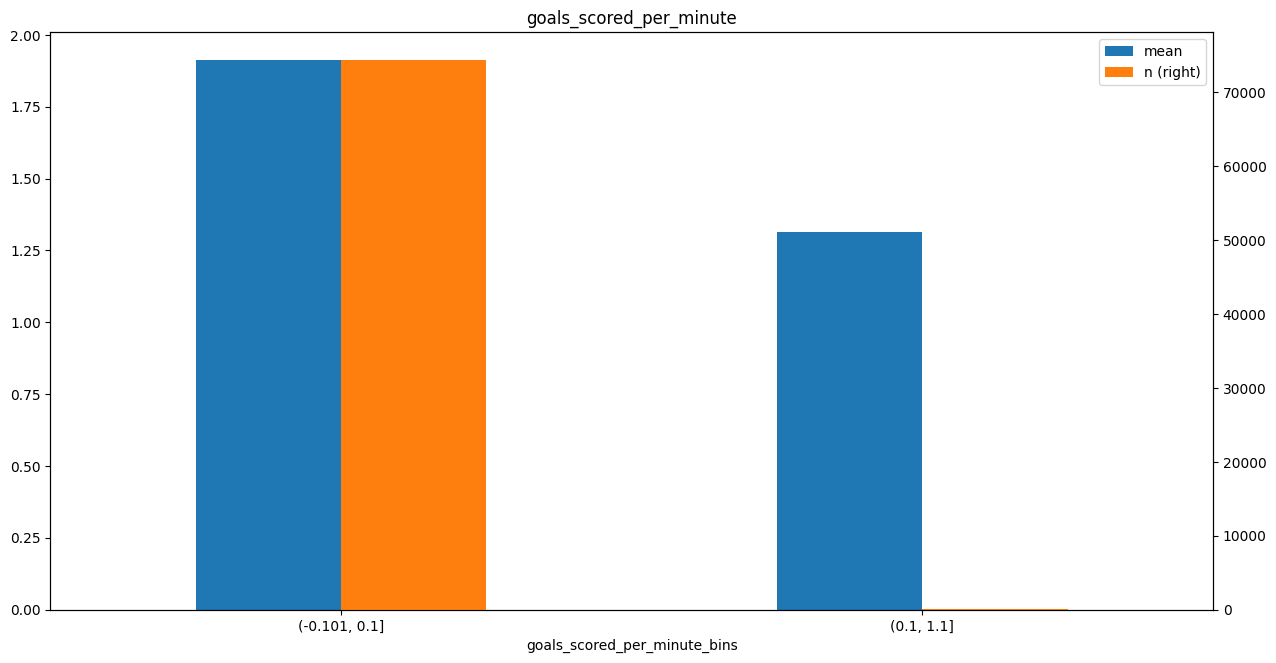

In [30]:
n_significant_features = p_values.loc[p_values['PR(>F)'] <= 0.05].count()[0]
features = p_values.iloc[0:(n_significant_features+1),0].to_list()
for p in features:
    plot_feature_against_target(df, p, target)